### **Environment Verification**[only to see our GPU specifications]

In [1]:
!nvidia-smi

Fri Dec 26 13:06:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### **All Packages and Libraries (C1)**

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

!pip install gensim

import gensim
from gensim.models import Word2Vec

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from tqdm import tqdm

## **Random- C2**

In [35]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
tf.random.set_seed(SEED)

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## **Dataset Loading (C3)**

In [36]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
import pandas as pd

BASE_PATH = "/content/drive/MyDrive/CSE440/dataset"

train_df = pd.read_csv(f"{BASE_PATH}/train.csv")
test_df  = pd.read_csv(f"{BASE_PATH}/test.csv")

print(train_df.shape)
print(test_df.shape)


(93333, 2)
(59999, 2)


##**EDA(c4)**

In [ ]:
train_df.head()
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93333 entries, 0 to 93332
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   QA Text  93333 non-null  object
 1   Class    93333 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB


Class
Family & Relationships    9481
Computers & Internet      9440
Science & Mathematics     9440
Business & Finance        9383
Education & Reference     9367
Entertainment & Music     9366
Politics & Government     9308
Health                    9243
Society & Culture         9204
Sports                    9101
Name: count, dtype: int64


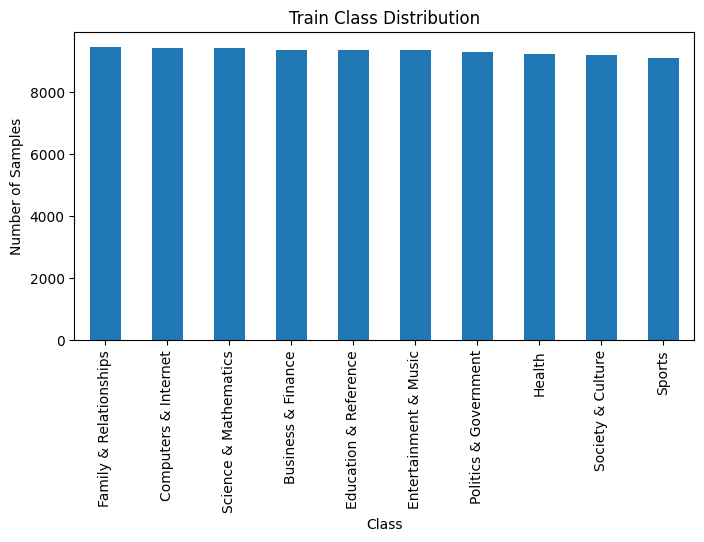

In [ ]:
class_counts = train_df['Class'].value_counts()
print(class_counts)

class_counts.plot(kind='bar', figsize=(8,4))
plt.title("Train Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()


Class
Science & Mathematics     6000
Education & Reference     6000
Health                    6000
Computers & Internet      6000
Entertainment & Music     6000
Business & Finance        6000
Society & Culture         6000
Politics & Government     6000
Sports                    6000
Family & Relationships    5999
Name: count, dtype: int64


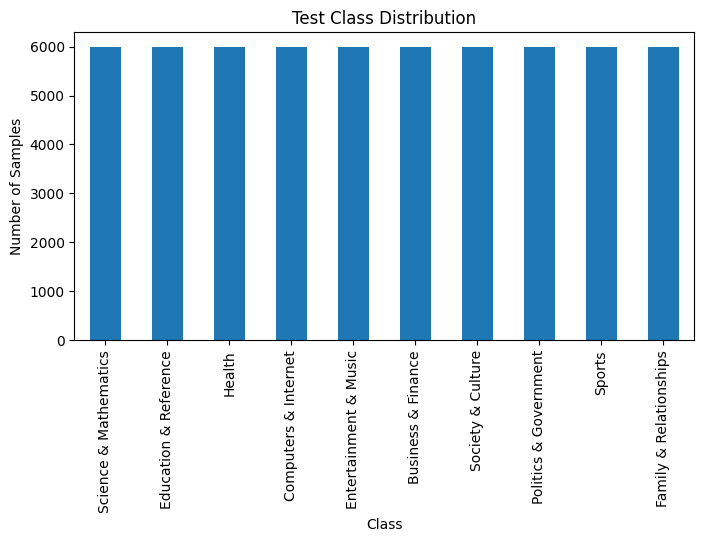

In [ ]:
class_counts = test_df['Class'].value_counts()
print(class_counts)

class_counts.plot(kind='bar', figsize=(8,4))
plt.title("Test Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

In [ ]:
TEXT_COL = 'QA Text'
LABEL_COL = 'Class'

print("Train Dataset")
train_df['text_length'] = train_df['QA Text'].apply(
    lambda x: len(str(x).split())
)

train_df['num_upper'] = train_df[TEXT_COL].str.count(r'[A-Z]')
train_df[['text_length', 'num_upper']].describe()


Train Dataset


text_length     num_upper
count  93333.000000  93333.000000
mean     106.445309     22.515155
std       98.570510     35.121923
min       16.000000      6.000000
25%       46.000000      9.000000
50%       76.000000     14.000000
75%      129.000000     24.000000
max     1103.000000   2127.000000

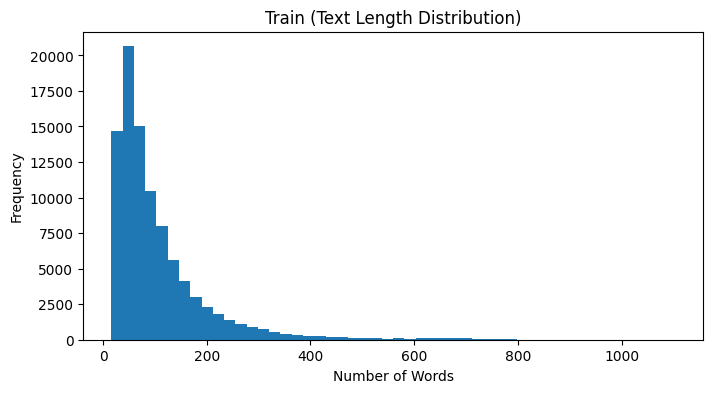

In [ ]:
plt.figure(figsize=(8,4))
plt.hist(train_df['text_length'], bins=50)
plt.title("Train (Text Length Distribution)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


In [ ]:
print("Test Dataset")
test_df['text_length'] = test_df['QA Text'].apply(
    lambda x: len(str(x).split())
)
test_df['text_length'].describe()

Test Dataset


count    59999.000000
mean        95.200503
std         99.093726
min          6.000000
25%         34.000000
50%         64.000000
75%        117.000000
max       1024.000000
Name: text_length, dtype: float64

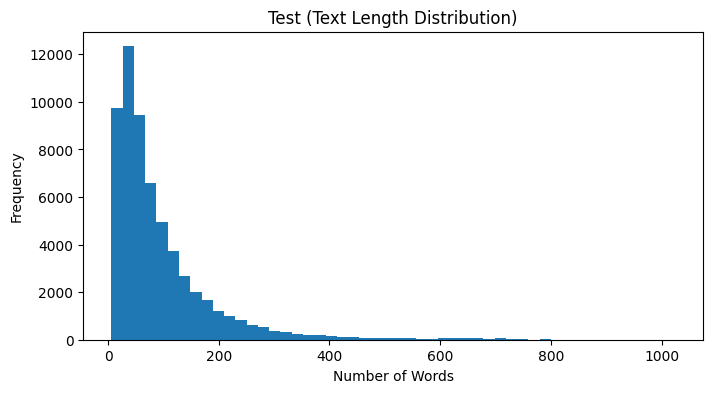

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(test_df['text_length'], bins=50)
plt.title("Test (Text Length Distribution)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

##**Text Preprocessing(C4)**

In [38]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [39]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [40]:
TEXT_COL = 'QA Text'
LABEL_COL = 'Class'

In [41]:
def clean_text(text):
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'question title', ' ', text, flags=re.IGNORECASE)
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


In [42]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])


In [43]:
train_df['clean_text'] = train_df[TEXT_COL].apply(clean_text)
test_df['clean_text']  = test_df[TEXT_COL].apply(clean_text)

train_df['clean_text'] = train_df['clean_text'].apply(remove_stopwords)
test_df['clean_text']  = test_df['clean_text'].apply(remove_stopwords)

In [44]:
train_df[[TEXT_COL, 'clean_text']].head()

QA Text  \
0  <html> Question Title:\n <br> Would thoughts g...   
1  <html> Question Title:\n <br> How is "not bein...   
2  <html> Question Title:\n <br> thunder from dow...   
3  <html> Question Title:\n <br> On average, how ...   
4  <html> Question Title:\n <br> What happen to t...   

                                          clean_text  
0  would thoughts go head see major hottie walkin...  
1  verified paypal user going affect account use ...  
2  thunder question content best answer buy ticke...  
3  average many bills become laws year question c...  
4  happen person created famous love bug computer...

In [45]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])


In [46]:
train_df['clean_text'] = train_df['clean_text'].apply(lemmatize_text)
test_df['clean_text']  = test_df['clean_text'].apply(lemmatize_text)



from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(train_df[LABEL_COL])

train_df['label_id'] = label_encoder.transform(train_df[LABEL_COL])
test_df['label_id'] = label_encoder.transform(test_df[LABEL_COL])

num_classes = len(label_encoder.classes_)
print(f"Number of classes: {num_classes}")

Number of classes: 10


In [47]:
train_df[[TEXT_COL, 'clean_text']].head()

QA Text  \
0  <html> Question Title:\n <br> Would thoughts g...   
1  <html> Question Title:\n <br> How is "not bein...   
2  <html> Question Title:\n <br> thunder from dow...   
3  <html> Question Title:\n <br> On average, how ...   
4  <html> Question Title:\n <br> What happen to t...   

                                          clean_text  
0  would thought go head see major hottie walking...  
1  verified paypal user going affect account use ...  
2  thunder question content best answer buy ticke...  
3  average many bill become law year question con...  
4  happen person created famous love bug computer...

## **DATA SPLITTING(C5)**

In [48]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
SEED=42
train_idx, val_idx, train_labels, val_labels = train_test_split(
    train_df.index, train_df['label_id'],
    test_size=0.2, random_state=42, stratify=train_df['label_id']
)

train_texts = train_df['clean_text'].loc[train_idx]
val_texts = train_df['clean_text'].loc[val_idx]

raw_train_texts = train_df[TEXT_COL].loc[train_idx]
raw_val_texts = train_df[TEXT_COL].loc[val_idx]
raw_test_texts = test_df[TEXT_COL]

### **TFIDF (C6)**

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_config = {'max_features': 10000, 'ngram_range': (1, 2), 'min_df': 2}

tfidf_vec = TfidfVectorizer(**vectorizer_config)

X_train_tfidf = tfidf_vec.fit_transform(train_texts)
X_val_tfidf   = tfidf_vec.transform(val_texts)
X_test_tfidf  = tfidf_vec.transform(test_df['clean_text'])

print(" TF-IDF Vectorization complete!")
print("Train TF-IDF shape:", X_train_tfidf.shape)
print("Val TF-IDF shape:", X_val_tfidf.shape)
print("Test TF-IDF shape:", X_test_tfidf.shape)


✅ TF-IDF Vectorization complete!
Train TF-IDF shape: (74666, 10000)
Val TF-IDF shape: (18667, 10000)
Test TF-IDF shape: (59999, 10000)


### **Model Evaluation framework**

In [20]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_metrics(y_true, y_pred):
    """Calculate classification metrics."""
    return {
        'acc': accuracy_score(y_true, y_pred),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted'),
        'f1_macro': f1_score(y_true, y_pred, average='macro')
    }

def print_metrics(metrics, labels_name, experiment_name):
    """Print formatted metrics."""
    print("=" * 80)
    print(f"EXPERIMENT: {experiment_name}")
    print("=" * 80)
    print(f"[{labels_name}] Accuracy: {metrics['acc']:.4f}  "
          f"F1-weighted: {metrics['f1_weighted']:.4f}  "
          f"F1-macro: {metrics['f1_macro']:.4f}")

def plot_confusion_matrix(y_true, y_pred, class_names, experiment_name, labels_name):
    """Plot confusion matrix heatmap."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {experiment_name} ({labels_name})',
              fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def evaluate_and_report(y_true, y_pred, labels_name='val', experiment_name='', class_names=None):
    """Comprehensive evaluation with metrics, report, and confusion matrix."""
    metrics = calculate_metrics(y_true, y_pred)
    print_metrics(metrics, labels_name, experiment_name)

    print('\nClassification Report:')
    print(classification_report(y_true, y_pred, target_names=class_names))

    plot_confusion_matrix(y_true, y_pred, class_names, experiment_name, labels_name)
    print("=" * 80)
    return metrics

def train_eval_ml(model, X_train, y_train, X_val, y_val, X_test, experiment_name, class_names):
    """Train model and evaluate on validation set."""
    print(f"\n Training {experiment_name}...")
    model.fit(X_train, y_train)
    print(f" Training completed for {experiment_name}")

    val_pred = model.predict(X_val)
    test_pred = model.predict(X_test)
    val_metrics = evaluate_and_report(y_val, val_pred, 'Validation', experiment_name, class_names)

    return model, val_metrics, test_pred

## **TF-IDF + ML models**

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

🔬 STARTING MACHINE LEARNING EXPERIMENT

📊 EXPERIMENT: Random Forest + TF-IDF

🚀 Training Random Forest + TF-IDF...
✅ Training completed for Random Forest + TF-IDF
EXPERIMENT: Random Forest + TF-IDF
[Validation] Accuracy: 0.5904  F1-weighted: 0.5845  F1-macro: 0.5846

Classification Report:
                        precision    recall  f1-score   support

    Business & Finance       0.49      0.40      0.44      1877
  Computers & Internet       0.66      0.81      0.72      1888
 Education & Reference       0.43      0.38      0.41      1873
 Entertainment & Music       0.56      0.53      0.54      1873
Family & Relationships       0.57      0.75      0.65      1896
                Health       0.66      0.64      0.65      1849
 Politics & Government       0.65      0.65      0.65      1862
 Science & Mathematics       0.54      0.65      0.59      1888
     Society & Culture       0.57      0.40      0.47      1841
                Sports       0.76      0.68      0.72      1820

   

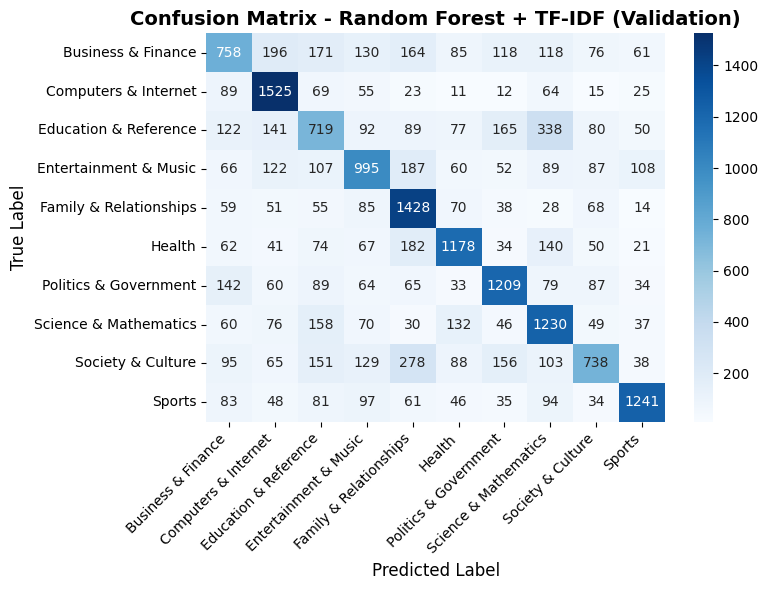


🎯 MACHINE LEARNING EXPERIMENT COMPLETED!

📈 RESULTS SUMMARY:
    experiment     acc  f1_weighted  f1_macro
0  RF + TF-IDF  0.5904       0.5845    0.5846


In [21]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

print(" STARTING MACHINE LEARNING EXPERIMENT")
print("="*60)

results = []

def log_result(name, metrics):
    """Log experiment result, removing duplicates."""
    global results
    results = [r for r in results if r['experiment'] != name]

    row = {'experiment': name}
    row.update(metrics)
    results.append(row)

experiment = {
    'name': 'RF + TF-IDF',
    'model': RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42, n_jobs=-1),
    'X_train': X_train_tfidf,
    'X_val': X_val_tfidf,
    'X_test': X_test_tfidf,
    'desc': 'Random Forest + TF-IDF'
}

print(f"\n EXPERIMENT: {experiment['desc']}")
_, metrics, _ = train_eval_ml(
    experiment['model'],
    experiment['X_train'], train_labels,
    experiment['X_val'], val_labels,
    experiment['X_test'],
    experiment['desc'],
    class_names=label_encoder.classes_
)
log_result(experiment['name'], metrics)

print("\n MACHINE LEARNING EXPERIMENT COMPLETED!")
print("="*60)
print("\n RESULTS SUMMARY:")
results_df_ml = pd.DataFrame(results)
print(results_df_ml[['experiment', 'acc', 'f1_weighted', 'f1_macro']].round(4))

# DNN + functions for dense feature vectors

🔬 MEMORY-EFFICIENT TF-IDF + DNN EXPERIMENT

📊 STEP 1: Verifying Data Splits...
✅ Data verified:
   Train: 74666 texts, 74666 labels
   Val: 18667 texts, 18667 labels
   Test: 59999 texts, 59999 labels
   Number of classes: 10

🔤 STEP 2: Memory-Efficient TF-IDF Vectorization...
Fitting TF-IDF vectorizer on training data...
✅ TF-IDF Vectorization complete!
   Vocabulary size: 5000
   Train shape: (74666, 5000)
   Val shape: (18667, 5000)
   Test shape: (59999, 5000)

🔄 STEP 3: Converting to Dense Arrays (Memory-Safe)...
Converting X_train: estimated size ~1424.1 MB
⚠️ Large matrix detected, converting in chunks...
✅ X_train converted successfully
Converting X_val: estimated size ~356.0 MB
✅ X_val converted: (18667, 5000)
Converting X_test: estimated size ~1144.4 MB
⚠️ Large matrix detected, converting in chunks...
✅ X_test converted successfully

✅ All matrices converted to dense
   Total memory usage: ~2924.58 MB

🏗️ STEP 4: Building Memory-Efficient DNN...

📊 Model Architecture:


Model: "Compact_TF_IDF_DNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 256)            │     1,280,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_1                    │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,323,082 (5.05 MB)

 Trainable params: 1,322,570 (5.05 MB)

 Non-trainable params: 512 (2.00 KB)


✅ Compact model built!
   Total parameters: 1,323,082
   Input features: 5000
   Output classes: 10

⚙️ STEP 5: Setting up Callbacks...
✅ Callbacks configured

🚀 STEP 6: Training TF-IDF + DNN Model...
Training configuration:
   Epochs: 25
   Batch size: 32
   Training samples: 74666

🔥 Starting training...
Epoch 1/25
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.4564 - loss: 1.6364 - val_accuracy: 0.6663 - val_loss: 1.0941 - learning_rate: 0.0010
Epoch 2/25
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6506 - loss: 1.1494 - val_accuracy: 0.6695 - val_loss: 1.0790 - learning_rate: 0.0010
Epoch 3/25
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6824 - loss: 1.0420 - val_accuracy: 0.6657 - val_loss: 1.0973 - learning_rate: 0.0010
Epoch 4/25
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7070 - loss: 0.9530 - val_accuracy: 0.6628 - val_loss: 1.1179 - learning_rate: 0.0010
Epoch 5/25
2318/2334 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7338 -

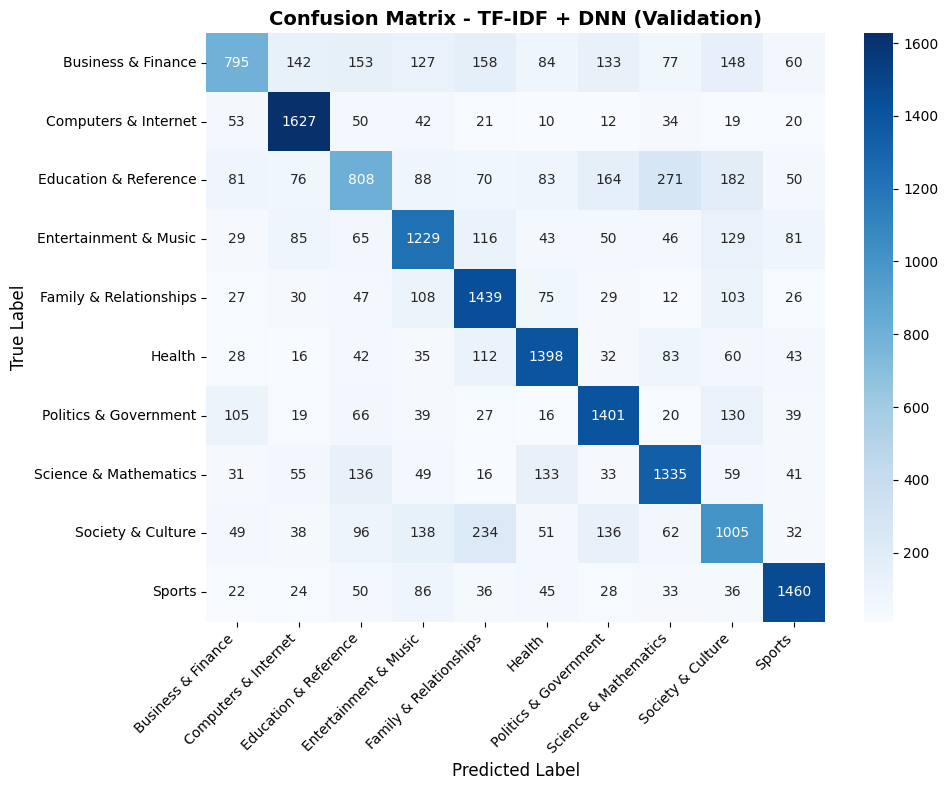


📊 STEP 8: Plotting Training History...


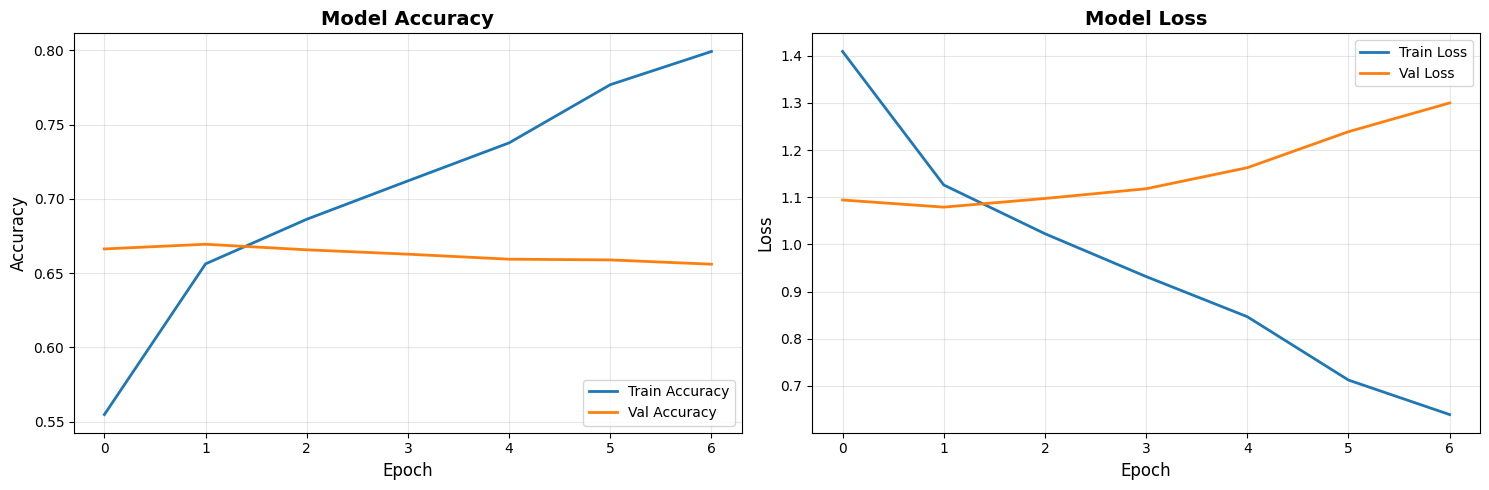


✅ Best validation accuracy: 0.6695 at epoch 2

🎯 STEP 9: Generating Test Predictions...


✅ Test predictions generated: 59999 samples

💾 STEP 10: Saving Results...
✅ Results logged
✅ Model and predictions saved

🎉 TF-IDF + DNN COMPLETED!

📊 Performance:
   Validation Accuracy: 0.6695
   Validation F1-Weighted: 0.6634

💾 Saved: tfidf_dnn_model.h5, tfidf_dnn_test_predictions.npy

✅ Memory cleaned up


In [22]:

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import issparse
import gc

print("="*80)
print(" MEMORY-EFFICIENT TF-IDF + DNN EXPERIMENT")
print("="*80)


print("\n STEP 1: Verifying Data Splits...")
print("="*80)

train_texts = train_df.loc[train_idx, 'clean_text'].astype(str)
val_texts = train_df.loc[val_idx, 'clean_text'].astype(str)
test_texts = test_df['clean_text'].astype(str)

y_train = train_labels.values if hasattr(train_labels, 'values') else np.array(train_labels)
y_val = val_labels.values if hasattr(val_labels, 'values') else np.array(val_labels)
y_test = test_df['label_id'].values

print(f" Data verified:")
print(f"   Train: {len(train_texts)} texts, {len(y_train)} labels")
print(f"   Val: {len(val_texts)} texts, {len(y_val)} labels")
print(f"   Test: {len(test_texts)} texts, {len(y_test)} labels")
print(f"   Number of classes: {num_classes}")


print("\n STEP 2: Memory-Efficient TF-IDF Vectorization...")
print("="*80)

vectorizer_config = {
    'max_features': 5000,
    'ngram_range': (1, 1),
    'min_df': 3,
    'max_df': 0.90,
    'sublinear_tf': True
}

tfidf_vectorizer = TfidfVectorizer(**vectorizer_config)

print("Fitting TF-IDF vectorizer on training data...")
X_train_tfidf = tfidf_vectorizer.fit_transform(train_texts)
X_val_tfidf = tfidf_vectorizer.transform(val_texts)
X_test_tfidf = tfidf_vectorizer.transform(test_texts)

print(f" TF-IDF Vectorization complete!")
print(f"   Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")
print(f"   Train shape: {X_train_tfidf.shape}")
print(f"   Val shape: {X_val_tfidf.shape}")
print(f"   Test shape: {X_test_tfidf.shape}")


print("\n STEP 3: Converting to Dense Arrays (Memory-Safe)...")
print("="*80)

def safe_to_dense(sparse_matrix, name="data"):
    """Safely convert sparse to dense with memory monitoring"""
    if issparse(sparse_matrix):
        estimated_size_mb = (sparse_matrix.shape[0] * sparse_matrix.shape[1] * 4) / (1024**2)
        print(f"Converting {name}: estimated size ~{estimated_size_mb:.1f} MB")

        if estimated_size_mb > 500:
            print(f" Large matrix detected, converting in chunks...")
            chunk_size = 1000
            dense_chunks = []
            for i in range(0, sparse_matrix.shape[0], chunk_size):
                chunk = sparse_matrix[i:i+chunk_size].toarray().astype('float32')
                dense_chunks.append(chunk)
            dense = np.vstack(dense_chunks)
            print(f" {name} converted successfully")
            return dense
        else:
            dense = sparse_matrix.toarray().astype('float32')
            print(f" {name} converted: {dense.shape}")
            return dense
    return sparse_matrix.astype('float32')

X_train_dense = safe_to_dense(X_train_tfidf, "X_train")
gc.collect()

X_val_dense = safe_to_dense(X_val_tfidf, "X_val")
gc.collect()

X_test_dense = safe_to_dense(X_test_tfidf, "X_test")
gc.collect()

print(f"\n All matrices converted to dense")
total_memory = (X_train_dense.nbytes + X_val_dense.nbytes + X_test_dense.nbytes) / (1024**2)
print(f"   Total memory usage: ~{total_memory:.2f} MB")


print("\n STEP 4: Building Memory-Efficient DNN...")
print("="*80)

def build_compact_dnn(input_dim, num_classes, seed=SEED):
    """
    Build a compact DNN that's less memory-intensive

    Architecture:
    - Smaller layers (256 -> 128 -> 64)
    - Fewer parameters
    - Still effective for classification
    """
    tf.keras.backend.clear_session()
    tf.keras.utils.set_random_seed(seed)

    model = models.Sequential([
        layers.Input(shape=(input_dim,), name='input'),

        layers.Dense(256, activation='relu', name='dense_1'),
        layers.BatchNormalization(name='batch_norm_1'),
        layers.Dropout(0.5, name='dropout_1'),

        layers.Dense(128, activation='relu', name='dense_2'),
        layers.Dropout(0.4, name='dropout_2'),

        layers.Dense(64, activation='relu', name='dense_3'),
        layers.Dropout(0.3, name='dropout_3'),

        layers.Dense(num_classes, activation='softmax', name='output')
    ], name='Compact_TF_IDF_DNN')

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

input_dim = X_train_dense.shape[1]
dnn_model = build_compact_dnn(input_dim, num_classes, SEED)

print("\n Model Architecture:")
dnn_model.summary()

total_params = dnn_model.count_params()
print(f"\n Compact model built!")
print(f"   Total parameters: {total_params:,}")
print(f"   Input features: {input_dim}")
print(f"   Output classes: {num_classes}")


print("\n STEP 5: Setting up Callbacks...")
print("="*80)

early_stop = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

callback_list = [early_stop, reduce_lr]

print(" Callbacks configured")


print("\n STEP 6: Training TF-IDF + DNN Model...")
print("="*80)

EPOCHS = 25
BATCH_SIZE = 32

print(f"Training configuration:")
print(f"   Epochs: {EPOCHS}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Training samples: {len(X_train_dense)}")

print("\n Starting training...")

try:
    history = dnn_model.fit(
        X_train_dense, y_train,
        validation_data=(X_val_dense, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callback_list,
        verbose=1
    )
    print("\n Training completed successfully!")

except Exception as e:
    print(f"\n Training failed: {e}")
    print("\n Trying with even smaller batch size...")

    BATCH_SIZE = 16
    history = dnn_model.fit(
        X_train_dense, y_train,
        validation_data=(X_val_dense, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callback_list,
        verbose=1
    )
    print("\n Training completed with smaller batch size!")


print("\n STEP 7: Evaluating on Validation Set...")
print("="*80)

val_probs = dnn_model.predict(X_val_dense, batch_size=BATCH_SIZE, verbose=0)
val_pred = np.argmax(val_probs, axis=1)

val_acc = accuracy_score(y_val, val_pred)
val_f1_macro = f1_score(y_val, val_pred, average='macro')
val_f1_weighted = f1_score(y_val, val_pred, average='weighted')

print("\n" + "="*80)
print(" VALIDATION RESULTS: TF-IDF + DNN")
print("="*80)
print(f"Accuracy:     {val_acc:.4f}")
print(f"F1-Macro:     {val_f1_macro:.4f}")
print(f"F1-Weighted:  {val_f1_weighted:.4f}")

print("\n Classification Report:")
print(classification_report(y_val, val_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_val, val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - TF-IDF + DNN (Validation)',
          fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


print("\n STEP 8: Plotting Training History...")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

best_epoch = np.argmax(history.history['val_accuracy']) + 1
best_val_acc = max(history.history['val_accuracy'])
print(f"\n Best validation accuracy: {best_val_acc:.4f} at epoch {best_epoch}")


print("\n STEP 9: Generating Test Predictions...")
print("="*80)

test_probs = dnn_model.predict(X_test_dense, batch_size=BATCH_SIZE, verbose=0)
test_pred = np.argmax(test_probs, axis=1)

print(f" Test predictions generated: {len(test_pred)} samples")


print("\n STEP 10: Saving Results...")
print("="*80)

dnn_metrics = {
    'experiment': 'TF-IDF + DNN',
    'acc': val_acc,
    'f1_macro': val_f1_macro,
    'f1_weighted': val_f1_weighted
}

try:
    if 'results' not in globals():
        results = []
    results = [r for r in results if r['experiment'] != 'TF-IDF + DNN']
    results.append(dnn_metrics)
    print(" Results logged")
except:
    results = [dnn_metrics]

dnn_model.save('tfidf_dnn_model.h5')
np.save('tfidf_dnn_test_predictions.npy', test_pred)
print(" Model and predictions saved")


print("\n" + "="*80)
print(" TF-IDF + DNN COMPLETED!")
print("="*80)
print(f"\n Performance:")
print(f"   Validation Accuracy: {val_acc:.4f}")
print(f"   Validation F1-Weighted: {val_f1_weighted:.4f}")
print(f"\n Saved: tfidf_dnn_model.h5, tfidf_dnn_test_predictions.npy")
print("="*80)

del X_train_dense, X_val_dense, X_test_dense, X_train_tfidf, X_val_tfidf, X_test_tfidf
gc.collect()
print("\n Memory cleaned up")

# **SKIPGRAM + NN models**

##SKIPGRAM

In [23]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

train_tokens = train_df['clean_text'].apply(lambda x: word_tokenize(str(x)))
val_tokens   = train_df.loc[val_idx, 'clean_text'].apply(lambda x: word_tokenize(str(x)))
test_tokens  = test_df['clean_text'].apply(lambda x: word_tokenize(str(x)))

all_tokens = list(train_tokens)

w2v_model = Word2Vec(
    sentences=all_tokens,
    vector_size=100,
    window=5,
    min_count=2,
    sg=1,
    workers=4,
    seed=42
)

print(" Skipgram Word2Vec trained!")
print("Embedding dim:", w2v_model.vector_size)


✅ Skipgram Word2Vec trained!
Embedding dim: 100


In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

MAX_WORDS = 20000
MAX_LEN   = 200

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df.loc[train_idx, 'clean_text'])

X_train_seq = tokenizer.texts_to_sequences(train_df.loc[train_idx, 'clean_text'])
X_val_seq   = tokenizer.texts_to_sequences(train_df.loc[val_idx, 'clean_text'])
X_test_seq  = tokenizer.texts_to_sequences(test_df['clean_text'])

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding="post", truncating="post")
X_val_pad   = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding="post", truncating="post")
X_test_pad  = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding="post", truncating="post")

print(" Sequences padded!")
print("Train shape:", X_train_pad.shape)


✅ Sequences padded!
Train shape: (74666, 200)


In [25]:
VOCAB_SIZE = min(MAX_WORDS, len(tokenizer.word_index) + 1)
EMB_DIM = w2v_model.vector_size

embedding_matrix = np.random.normal(size=(VOCAB_SIZE, EMB_DIM)).astype(np.float32)

for word, idx in tokenizer.word_index.items():
    if idx >= VOCAB_SIZE:
        continue
    if word in w2v_model.wv:
        embedding_matrix[idx] = w2v_model.wv[word]

print(" Embedding matrix built:", embedding_matrix.shape)


✅ Embedding matrix built: (20000, 100)


##Skipgraam+ DNN

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,000,000 (7.63 MB)

Epoch 1/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.1510 - loss: 2.2548 - val_accuracy: 0.3705 - val_loss: 1.9031
Epoch 2/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3071 - loss: 1.9397 - val_accuracy: 0.4957 - val_loss: 1.6936
Epoch 3/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3494 - loss: 1.8355 - val_accuracy: 0.5029 - val_loss: 1.6165
Epoch 4/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3707 - loss: 1.7876 - val_accuracy: 0.5059 - val_loss: 1.5813
Epoch 5/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3731 - loss: 1.7847 - val_accuracy: 0.4417 - val_loss: 1.6312
Epoch 6/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3853 - loss: 1.7512 - val_accuracy: 0.5136 - val_loss: 1.5312
Epoch 7/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3965 - loss: 1.7245 - val_accuracy: 0.5468 - val_loss: 1.4608
Epoch 8/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4109 - loss: 1.6939 -

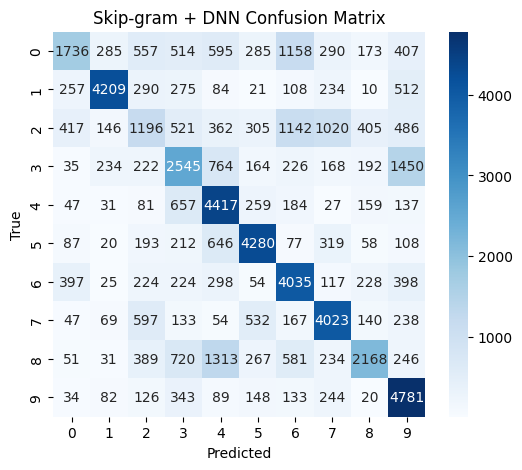

In [59]:


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

embedding_dim=100
max_len=MAX_LEN
sg_dnn_model = Sequential([
    Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False
    ),
    GlobalAveragePooling1D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

sg_dnn_model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

sg_dnn_model.summary()

X_train_sg= X_train_pad
X_val_sg= X_val_pad
X_test_sg= X_test_pad

history = sg_dnn_model.fit(
    X_train_sg, y_train,
    validation_data=(X_val_sg, y_val),
    epochs=15,
    batch_size=64,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
    verbose=1
)


y_test_pred = sg_dnn_model.predict(X_test_sg)
y_test_pred_cls = y_test_pred.argmax(axis=1)

print("Accuracy:", accuracy_score(y_test, y_test_pred_cls))
print("Macro F1:", f1_score(y_test, y_test_pred_cls, average='macro'))
print("\nClassification Report:\n")
print(classification_report(y_test, y_test_pred_cls))

cm = confusion_matrix(y_test, y_test_pred_cls)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Skip-gram + DNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, X_val, y_val, class_names, exp_name):
    val_probs = model.predict(X_val)
    val_pred = np.argmax(val_probs, axis=1)

    acc = accuracy_score(y_val, val_pred)
    f1_macro = f1_score(y_val, val_pred, average="macro")
    f1_weighted = f1_score(y_val, val_pred, average="weighted")

    print("="*80)
    print(f" EXPERIMENT: {exp_name}")
    print("="*80)
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Macro: {f1_macro:.4f}")
    print(f"F1 Weighted: {f1_weighted:.4f}")

    print("\nClassification Report:\n")
    print(classification_report(y_val, val_pred, target_names=class_names))

    cm = confusion_matrix(y_val, val_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix - {exp_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    return {"acc": acc, "f1_macro": f1_macro, "f1_weighted": f1_weighted}

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=True
)


## Skipgram + SimpleRNN

Epoch 1/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 29s 22ms/step - accuracy: 0.1006 - loss: 2.3301 - val_accuracy: 0.1057 - val_loss: 2.2960
Epoch 2/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - accuracy: 0.1059 - loss: 2.2966 - val_accuracy: 0.1056 - val_loss: 2.2973
Epoch 3/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - accuracy: 0.1046 - loss: 2.2920 - val_accuracy: 0.1057 - val_loss: 2.2971
Epoch 4/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.1030 - loss: 2.3063 - val_accuracy: 0.1022 - val_loss: 2.3018
Epoch 5/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.1023 - loss: 2.3031 - val_accuracy: 0.1031 - val_loss: 2.3012
Epoch 6/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.1024 - loss: 2.3029 - val_accuracy: 0.1035 - val_loss: 2.3022
584/584 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
✅ EXPERIMENT: Skipgram + SimpleRNN
Accuracy: 0.1057
F1 Macro: 0.0298
F1 Weighted: 0.0300

Classification Report:

                        precision    recall  f1-score

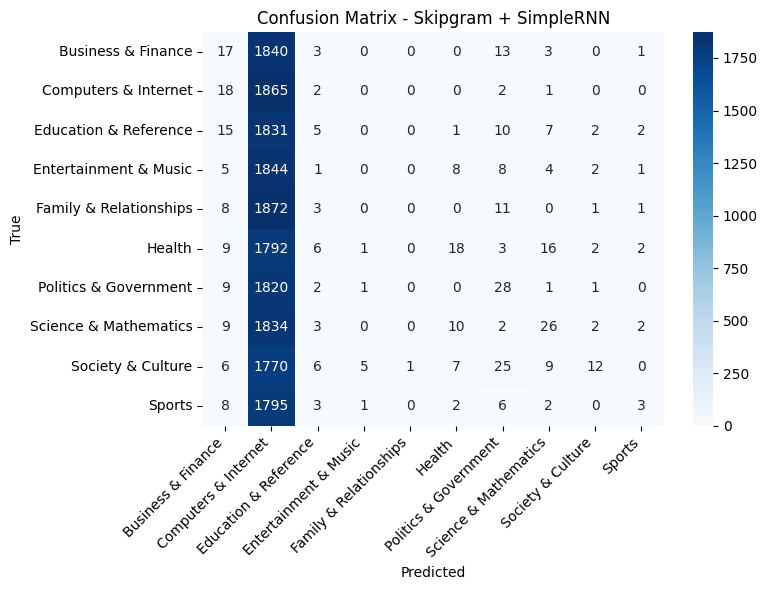

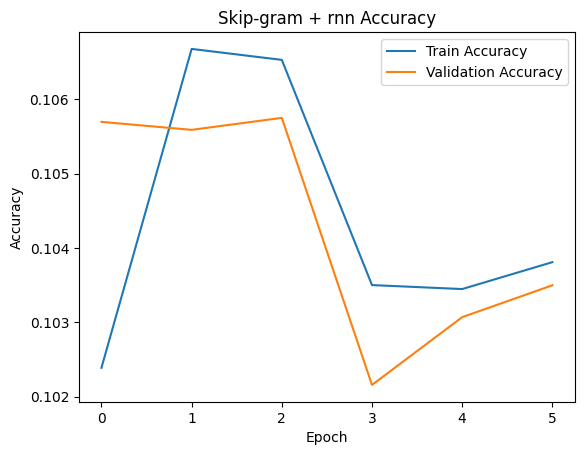

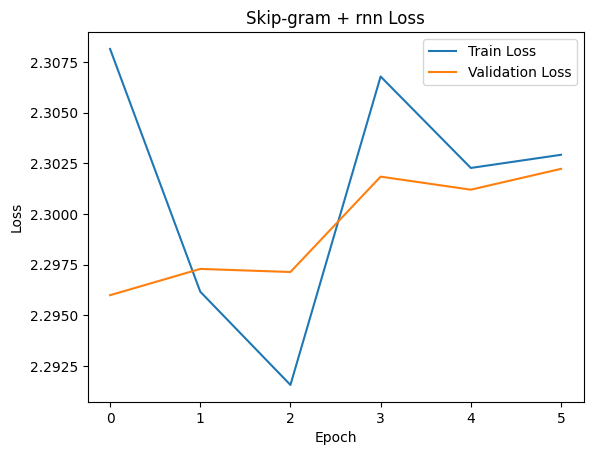

In [27]:
tf.keras.backend.clear_session()

model_rnn = models.Sequential([
    layers.Input(shape=(X_train_pad.shape[1],)),

    layers.Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMB_DIM,
        weights=[embedding_matrix],
        trainable=True
    ),

    layers.SimpleRNN(128),
    layers.Dropout(0.3),

    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),

    layers.Dense(num_classes, activation="softmax")
])

model_rnn.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_rnn = model_rnn.fit(
    X_train_pad, train_labels,
    validation_data=(X_val_pad, val_labels),
    epochs=15,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

metrics_rnn = evaluate_model(model_rnn, X_val_pad, val_labels, label_encoder.classes_, "Skipgram + SimpleRNN")


plt.figure()
plt.plot(history_rnn.history["accuracy"], label="Train Accuracy")
plt.plot(history_rnn.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Skip-gram + rnn Accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(history_rnn.history["loss"], label="Train Loss")
plt.plot(history_rnn.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Skip-gram + rnn Loss")
plt.legend()
plt.show()

## Skipgram + GRU

Epoch 1/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.1054 - loss: 2.3065 - val_accuracy: 0.5342 - val_loss: 1.3498
Epoch 2/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.6258 - loss: 1.1801 - val_accuracy: 0.6973 - val_loss: 0.9676
Epoch 3/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.7231 - loss: 0.8979 - val_accuracy: 0.6994 - val_loss: 0.9658
Epoch 4/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.7585 - loss: 0.7867 - val_accuracy: 0.6929 - val_loss: 1.0116
Epoch 5/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.7885 - loss: 0.6862 - val_accuracy: 0.6863 - val_loss: 1.0990
Epoch 6/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.8209 - loss: 0.5841 - val_accuracy: 0.6704 - val_loss: 1.2607
584/584 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
✅ EXPERIMENT: Skipgram + GRU
Accuracy: 0.6994
F1 Macro: 0.6947
F1 Weighted: 0.6945

Classification Report:

                        precision    recall  f1-score   sup

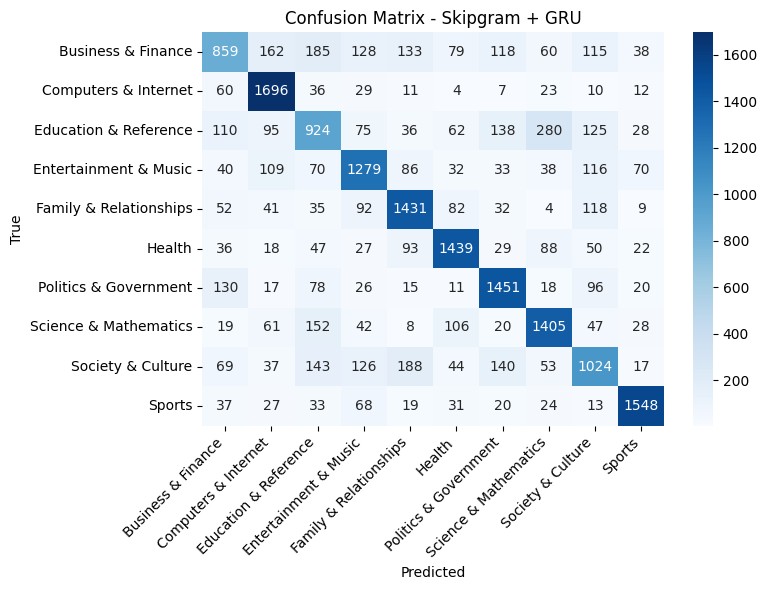

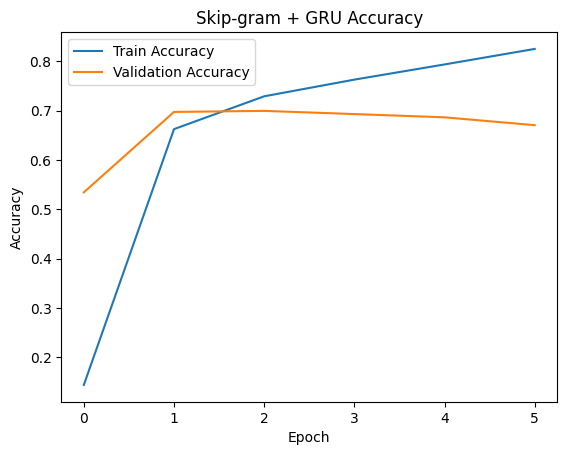

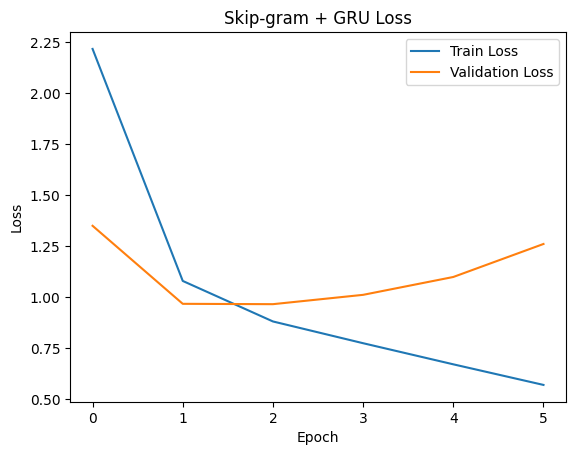

In [28]:
tf.keras.backend.clear_session()

model_gru = models.Sequential([
    layers.Input(shape=(X_train_pad.shape[1],)),

    layers.Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMB_DIM,
        weights=[embedding_matrix],
        trainable=True
    ),

    layers.GRU(128),
    layers.Dropout(0.3),

    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),

    layers.Dense(num_classes, activation="softmax")
])

model_gru.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_gru = model_gru.fit(
    X_train_pad, train_labels,
    validation_data=(X_val_pad, val_labels),
    epochs=15,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

metrics_gru = evaluate_model(model_gru, X_val_pad, val_labels, label_encoder.classes_, "Skipgram + GRU")

plt.figure()
plt.plot(history_gru.history["accuracy"], label="Train Accuracy")
plt.plot(history_gru.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Skip-gram + GRU Accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(history_gru.history["loss"], label="Train Loss")
plt.plot(history_gru.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Skip-gram + GRU Loss")
plt.legend()
plt.show()

## Skipgram + LSTM

Epoch 1/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.1023 - loss: 2.3077 - val_accuracy: 0.1070 - val_loss: 2.2926
Epoch 2/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.1059 - loss: 2.2867 - val_accuracy: 0.3767 - val_loss: 1.7250
Epoch 3/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.5122 - loss: 1.4859 - val_accuracy: 0.6680 - val_loss: 1.0946
Epoch 4/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.6957 - loss: 1.0235 - val_accuracy: 0.6746 - val_loss: 1.0787
Epoch 5/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.7386 - loss: 0.8897 - val_accuracy: 0.6809 - val_loss: 1.0693
Epoch 6/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.7695 - loss: 0.7905 - val_accuracy: 0.6789 - val_loss: 1.1068
Epoch 7/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.7941 - loss: 0.7078 - val_accuracy: 0.6733 - val_loss: 1.1823
Epoch 8/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.8190 -

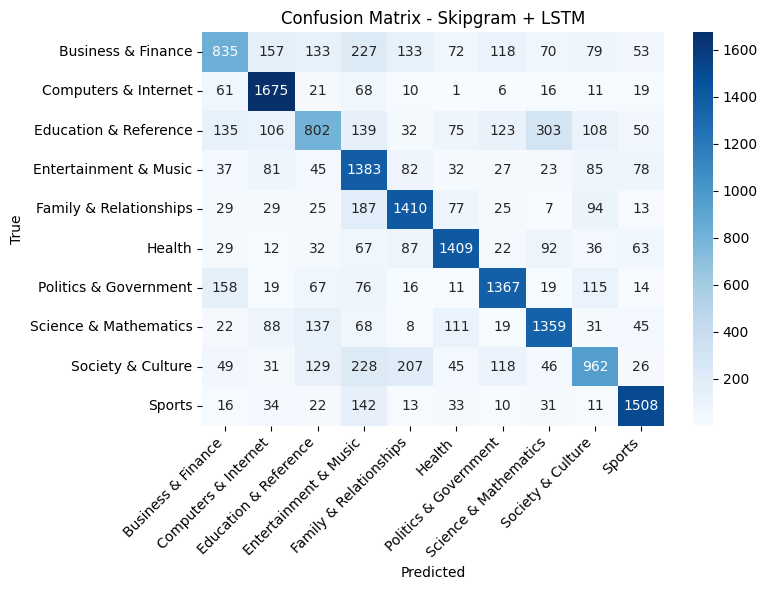

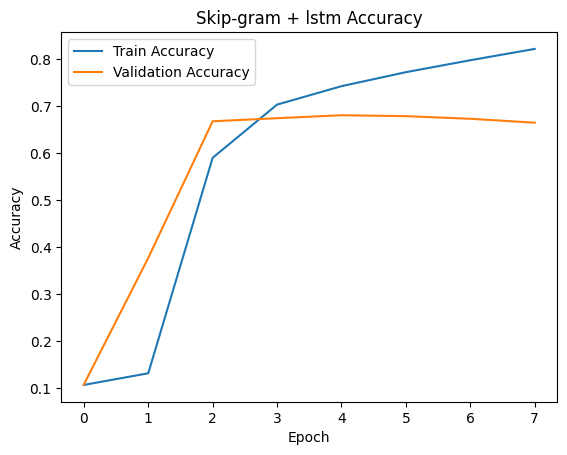

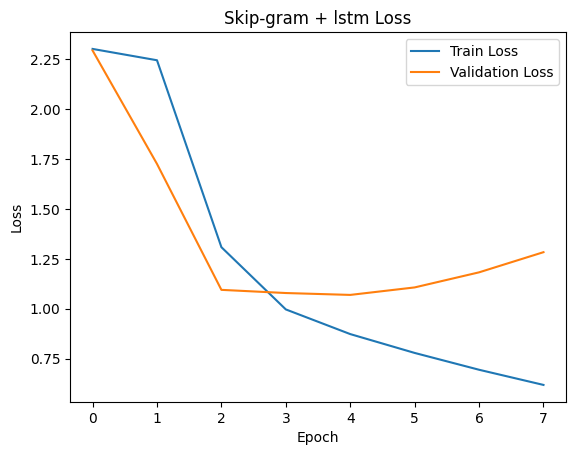

In [29]:
tf.keras.backend.clear_session()

model_lstm = models.Sequential([
    layers.Input(shape=(X_train_pad.shape[1],)),

    layers.Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMB_DIM,
        weights=[embedding_matrix],
        trainable=True
    ),

    layers.LSTM(128),
    layers.Dropout(0.3),

    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),

    layers.Dense(num_classes, activation="softmax")
])

model_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_lstm = model_lstm.fit(
    X_train_pad, train_labels,
    validation_data=(X_val_pad, val_labels),
    epochs=15,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

metrics_lstm = evaluate_model(model_lstm, X_val_pad, val_labels, label_encoder.classes_, "Skipgram + LSTM")


plt.figure()
plt.plot(history_lstm.history["accuracy"], label="Train Accuracy")
plt.plot(history_lstm.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Skip-gram + lstm Accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(history_lstm.history["loss"], label="Train Loss")
plt.plot(history_lstm.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Skip-gram + lstm Loss")
plt.legend()
plt.show()

## 4)Skipgram + Bidirectional SimpleRNN

Epoch 1/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 49s 38ms/step - accuracy: 0.4788 - loss: 1.5533 - val_accuracy: 0.6640 - val_loss: 1.0740
Epoch 2/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.6585 - loss: 1.1099 - val_accuracy: 0.6693 - val_loss: 1.0775
Epoch 3/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 56s 48ms/step - accuracy: 0.7012 - loss: 0.9865 - val_accuracy: 0.6302 - val_loss: 1.1931
Epoch 4/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 65s 34ms/step - accuracy: 0.7108 - loss: 0.9558 - val_accuracy: 0.6741 - val_loss: 1.0784
Epoch 5/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.7360 - loss: 0.8797 - val_accuracy: 0.6773 - val_loss: 1.0921
Epoch 6/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 42s 35ms/step - accuracy: 0.7420 - loss: 0.8523 - val_accuracy: 0.6691 - val_loss: 1.1510
Epoch 7/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.7403 - loss: 0.8571 - val_accuracy: 0.6700 - val_loss: 1.1546
Epoch 8/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.7521 -

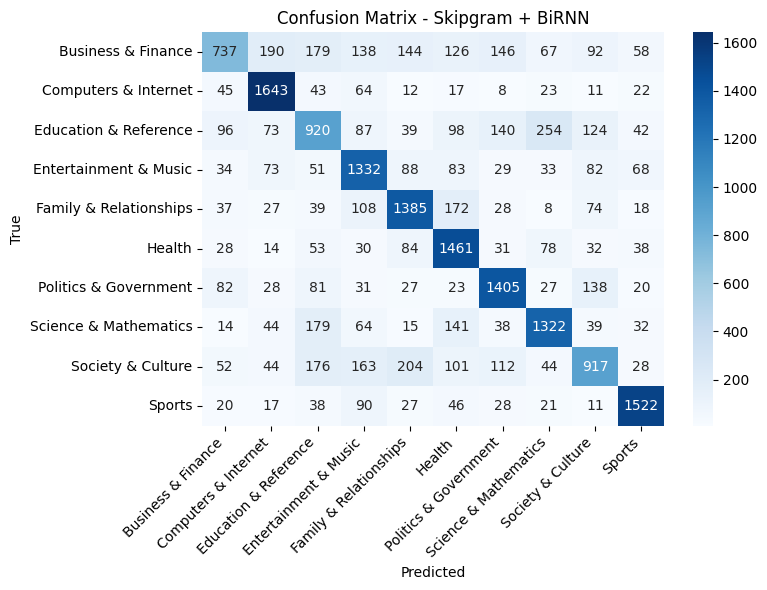

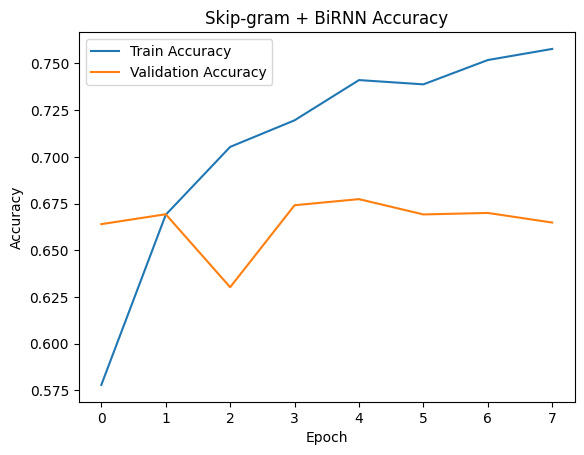

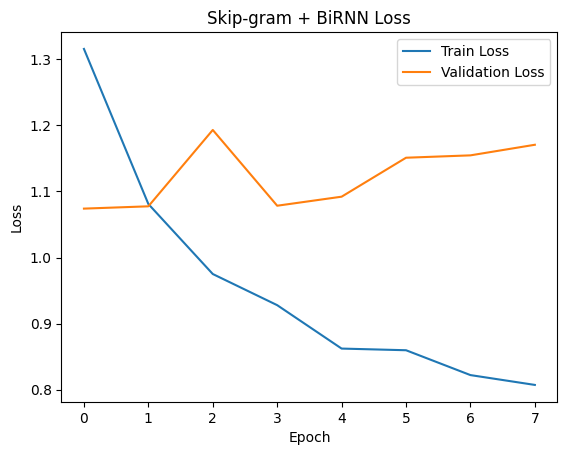

In [30]:
tf.keras.backend.clear_session()

model_birnn = models.Sequential([
    layers.Input(shape=(X_train_pad.shape[1],)),

    layers.Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMB_DIM,
        weights=[embedding_matrix],
        trainable=True
    ),

    layers.Bidirectional(layers.SimpleRNN(128)),
    layers.Dropout(0.3),

    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),

    layers.Dense(num_classes, activation="softmax")
])

model_birnn.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_birnn = model_birnn.fit(
    X_train_pad, train_labels,
    validation_data=(X_val_pad, val_labels),
    epochs=15,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

metrics_birnn = evaluate_model(model_birnn, X_val_pad, val_labels, label_encoder.classes_, "Skipgram + BiRNN")


import matplotlib.pyplot as plt

plt.figure()
plt.plot(history_birnn.history["accuracy"], label="Train Accuracy")
plt.plot(history_birnn.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Skip-gram + BiRNN Accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(history_birnn.history["loss"], label="Train Loss")
plt.plot(history_birnn.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Skip-gram + BiRNN Loss")
plt.legend()
plt.show()

## 5) Skipgram + Bidirectional LSTM

Epoch 1/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 42s 35ms/step - accuracy: 0.5398 - loss: 1.3761 - val_accuracy: 0.6821 - val_loss: 0.9999
Epoch 2/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 38s 33ms/step - accuracy: 0.6757 - loss: 1.0235 - val_accuracy: 0.6883 - val_loss: 0.9712
Epoch 3/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 39s 33ms/step - accuracy: 0.6895 - loss: 0.9794 - val_accuracy: 0.6952 - val_loss: 0.9445
Epoch 4/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 34s 28ms/step - accuracy: 0.6973 - loss: 0.9517 - val_accuracy: 0.6966 - val_loss: 0.9399
Epoch 5/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 27s 23ms/step - accuracy: 0.6997 - loss: 0.9308 - val_accuracy: 0.6980 - val_loss: 0.9320
Epoch 6/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.7060 - loss: 0.9136 - val_accuracy: 0.7000 - val_loss: 0.9265
Epoch 7/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.7104 - loss: 0.8963 - val_accuracy: 0.7032 - val_loss: 0.9245
Epoch 8/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 27s 23ms/step - accuracy: 0.7148 -

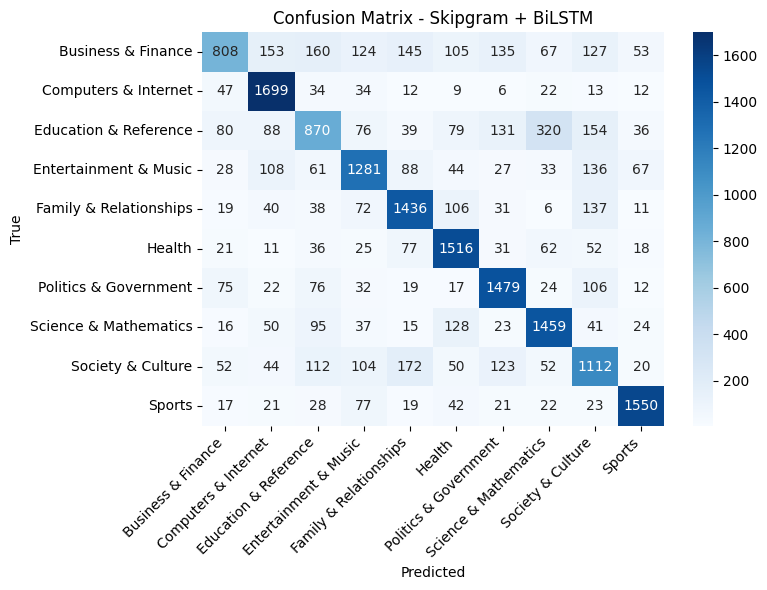

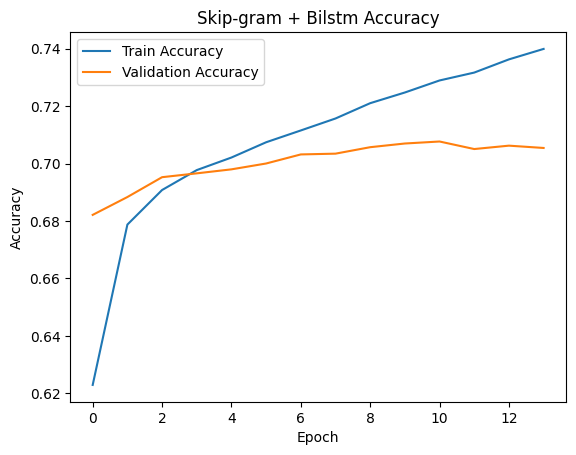

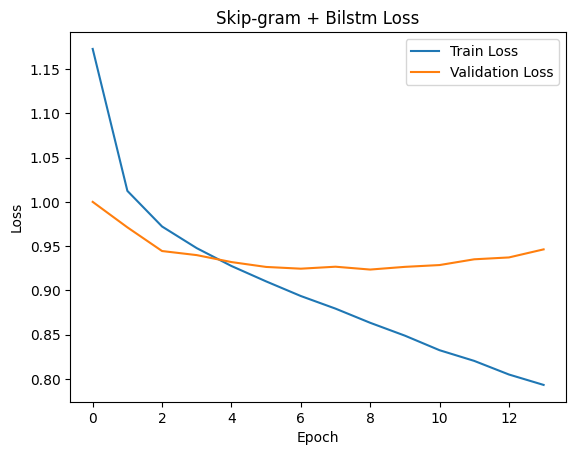

In [31]:
tf.keras.backend.clear_session()

model_bilstm = models.Sequential([
    layers.Input(shape=(X_train_pad.shape[1],)),

    layers.Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMB_DIM,
        weights=[embedding_matrix],
        trainable=False
    ),

    layers.Bidirectional(layers.LSTM(128)),
    layers.Dropout(0.3),

    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),

    layers.Dense(num_classes, activation="softmax")
])

model_bilstm.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_bilstm = model_bilstm.fit(
    X_train_pad, train_labels,
    validation_data=(X_val_pad, val_labels),
    epochs=15,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

metrics_bilstm = evaluate_model(model_bilstm, X_val_pad, val_labels, label_encoder.classes_, "Skipgram + BiLSTM")


import matplotlib.pyplot as plt

plt.figure()
plt.plot(history_bilstm.history["accuracy"], label="Train Accuracy")
plt.plot(history_bilstm.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Skip-gram + Bilstm Accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(history_bilstm.history["loss"], label="Train Loss")
plt.plot(history_bilstm.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Skip-gram + Bilstm Loss")
plt.legend()
plt.show()

## 6) Skipgram + Bidirectional GRU

Epoch 1/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.5269 - loss: 1.4009 - val_accuracy: 0.7025 - val_loss: 0.9376
Epoch 2/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.7135 - loss: 0.9152 - val_accuracy: 0.7055 - val_loss: 0.9315
Epoch 3/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.7474 - loss: 0.8013 - val_accuracy: 0.6997 - val_loss: 0.9652
Epoch 4/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.7782 - loss: 0.7017 - val_accuracy: 0.6893 - val_loss: 1.0432
Epoch 5/15
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.8091 - loss: 0.6022 - val_accuracy: 0.6769 - val_loss: 1.1806
584/584 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step
✅ EXPERIMENT: Skipgram + BiGRU
Accuracy: 0.7055
F1 Macro: 0.6975
F1 Weighted: 0.6972

Classification Report:

                        precision    recall  f1-score   support

    Business & Finance       0.68      0.40      0.50      1877
  Computers & Internet       0.70      0.93      0.80      1

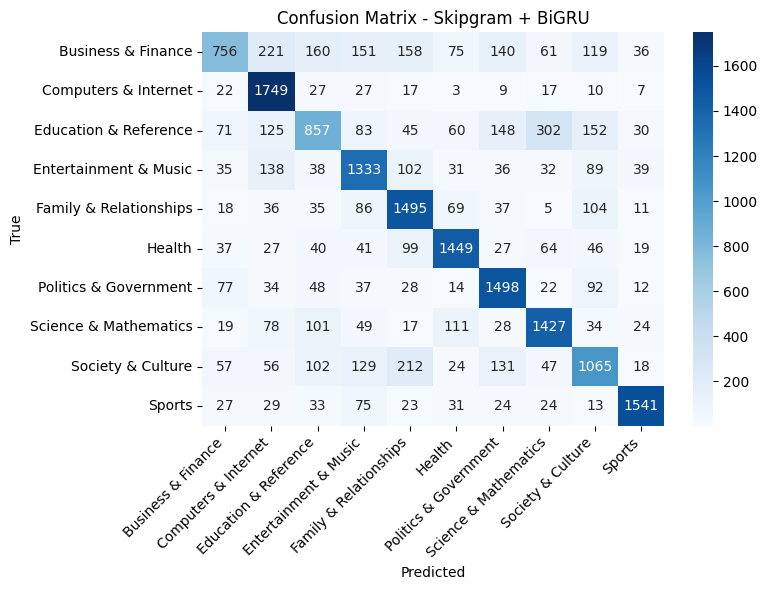

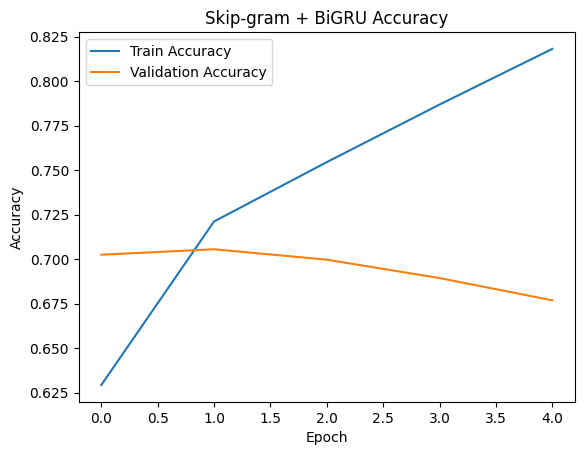

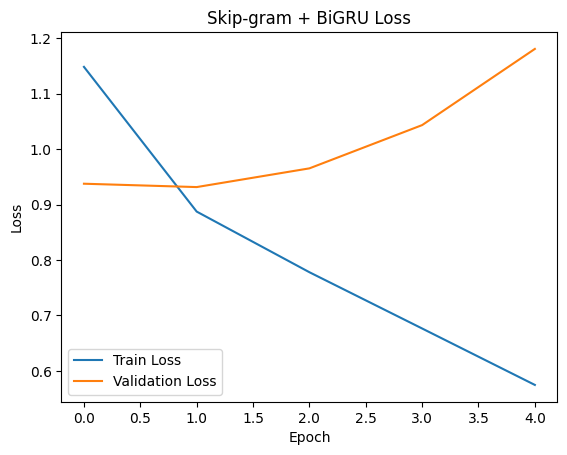

In [32]:
tf.keras.backend.clear_session()

model_bigru = models.Sequential([
    layers.Input(shape=(X_train_pad.shape[1],)),

    layers.Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMB_DIM,
        weights=[embedding_matrix],
        trainable=True
    ),

    layers.Bidirectional(layers.GRU(128)),
    layers.Dropout(0.3),

    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),

    layers.Dense(num_classes, activation="softmax")
])

model_bigru.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_bigru = model_bigru.fit(
    X_train_pad, train_labels,
    validation_data=(X_val_pad, val_labels),
    epochs=15,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

metrics_bigru = evaluate_model(model_bigru, X_val_pad, val_labels, label_encoder.classes_, "Skipgram + BiGRU")

import matplotlib.pyplot as plt

plt.figure()
plt.plot(history_bigru.history["accuracy"], label="Train Accuracy")
plt.plot(history_bigru.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Skip-gram + BiGRU Accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(history_bigru.history["loss"], label="Train Loss")
plt.plot(history_bigru.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Skip-gram + BiGRU Loss")
plt.legend()
plt.show()

## **Hyperparam TUNING**


HYPERPARAMETER TUNING - TF-IDF + DNN

Testing TF-IDF+DNN with params: {'hidden': 256, 'dropout': 0.3, 'lr': 0.001, 'batch': 64}
Epoch 1/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.5473 - loss: 1.4412 - val_accuracy: 0.6812 - val_loss: 1.0039
Epoch 2/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7499 - loss: 0.7921 - val_accuracy: 0.6733 - val_loss: 1.0345
Epoch 3/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8069 - loss: 0.6095 - val_accuracy: 0.6599 - val_loss: 1.1322
Epoch 4/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8620 - loss: 0.4380 - val_accuracy: 0.6478 - val_loss: 1.3118


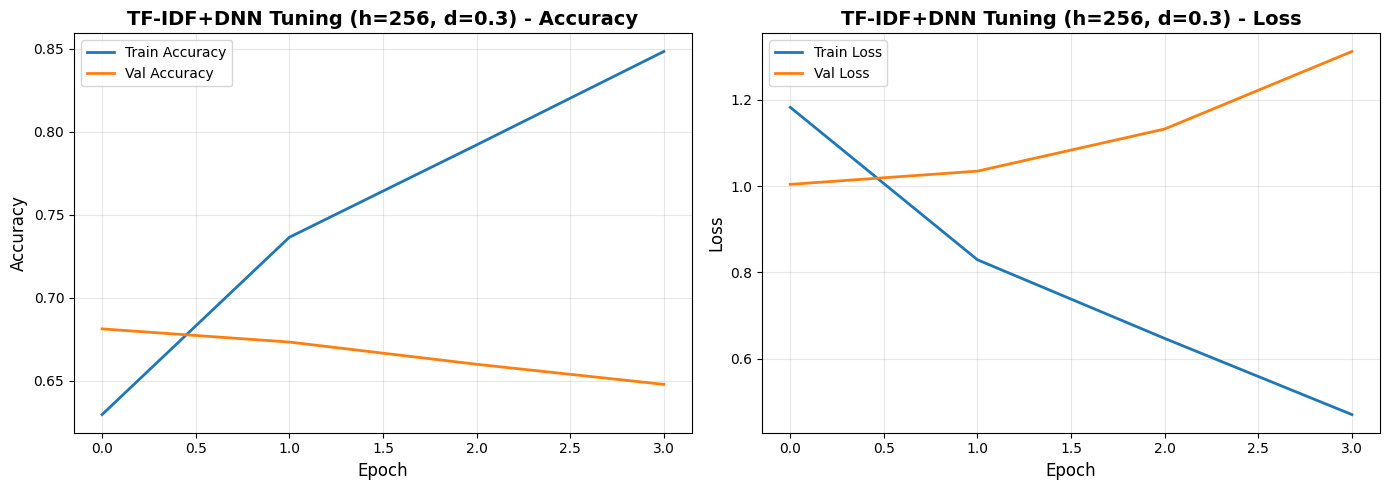

Val Acc: 0.6812, Val F1: 0.6760

Testing TF-IDF+DNN with params: {'hidden': 512, 'dropout': 0.4, 'lr': 0.0005, 'batch': 64}
Epoch 1/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.5164 - loss: 1.5210 - val_accuracy: 0.6854 - val_loss: 0.9992
Epoch 2/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7407 - loss: 0.8224 - val_accuracy: 0.6775 - val_loss: 1.0223
Epoch 3/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7950 - loss: 0.6494 - val_accuracy: 0.6649 - val_loss: 1.0908
Epoch 4/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.8416 - loss: 0.4995 - val_accuracy: 0.6563 - val_loss: 1.2142


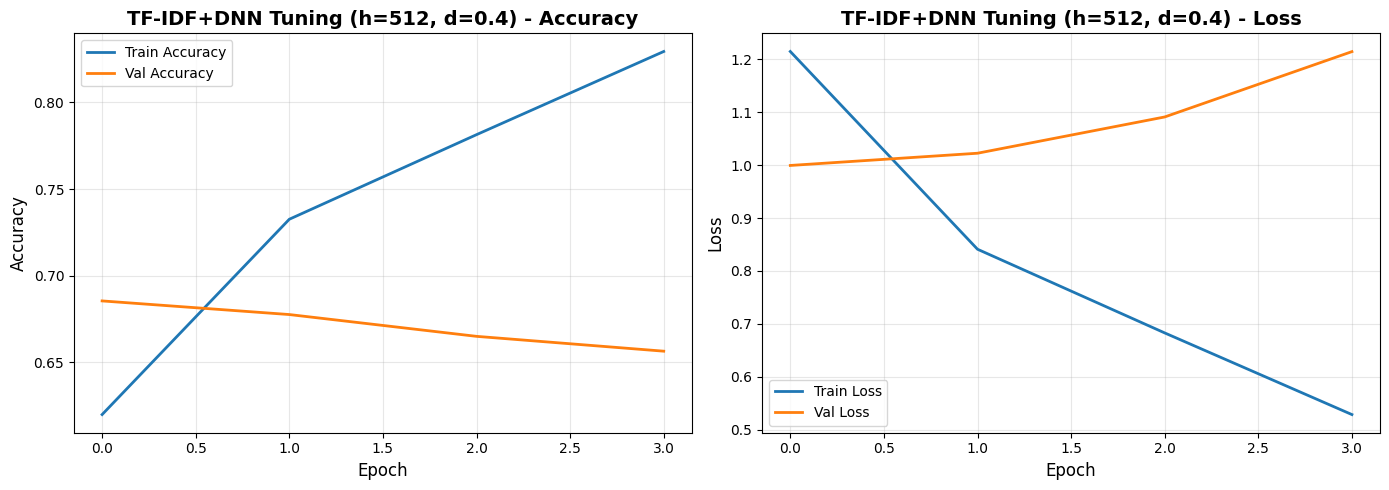

Val Acc: 0.6854, Val F1: 0.6821

HYPERPARAMETER TUNING - SKIP-GRAM + RNN MODELS

Testing Skipgram+RNN with params: {'units': 128, 'dropout': 0.3, 'lr': 0.001, 'batch': 64, 'trainable_embed': False}
Epoch 1/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step - accuracy: 0.1008 - loss: 2.3222 - val_accuracy: 0.1031 - val_loss: 2.3015
Epoch 2/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.0999 - loss: 2.3022 - val_accuracy: 0.1042 - val_loss: 2.3024
Epoch 3/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.0999 - loss: 2.3007 - val_accuracy: 0.1044 - val_loss: 2.2988
Epoch 4/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.1029 - loss: 2.2997 - val_accuracy: 0.1051 - val_loss: 2.2977
Epoch 5/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.1000 - loss: 2.2985 - val_accuracy: 0.1044 - val_loss: 2.2992
Epoch 6/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.1034 - loss: 2.2961 - val_accuracy: 0.1059 - val_loss: 2.2980
Epoch 7/10

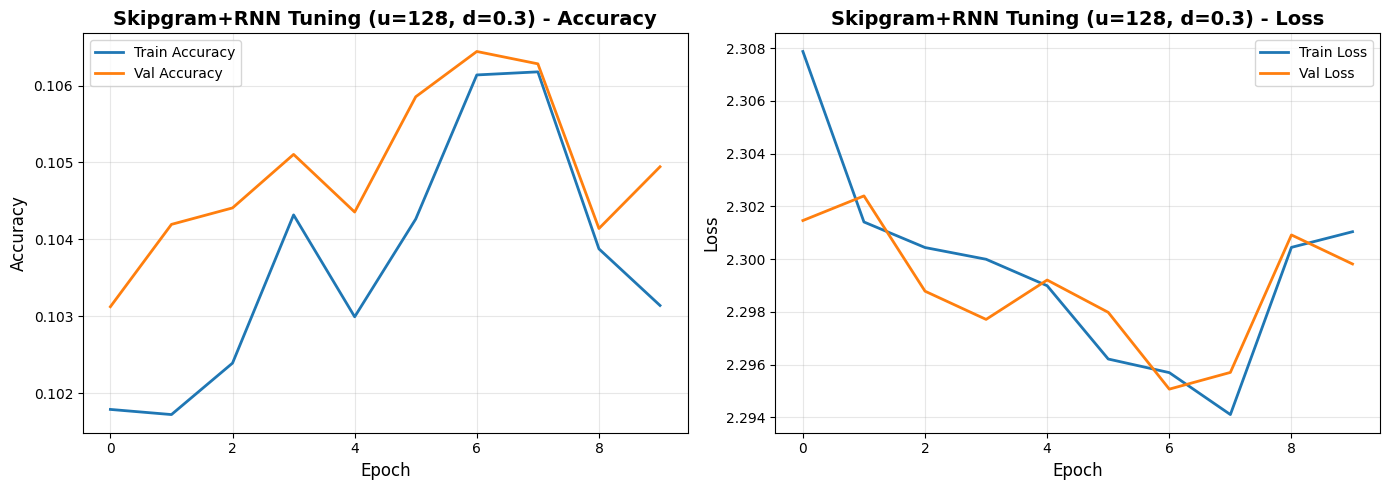

Val Acc: 0.1064, Val F1: 0.0302

Testing Skipgram+RNN with params: {'units': 256, 'dropout': 0.4, 'lr': 0.0005, 'batch': 64, 'trainable_embed': False}
Epoch 1/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 30s 23ms/step - accuracy: 0.0997 - loss: 2.3366 - val_accuracy: 0.1041 - val_loss: 2.3009
Epoch 2/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - accuracy: 0.1023 - loss: 2.3021 - val_accuracy: 0.1035 - val_loss: 2.3013
Epoch 3/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.1009 - loss: 2.3029 - val_accuracy: 0.1021 - val_loss: 2.3024
Epoch 4/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.1005 - loss: 2.3042 - val_accuracy: 0.1037 - val_loss: 2.3021


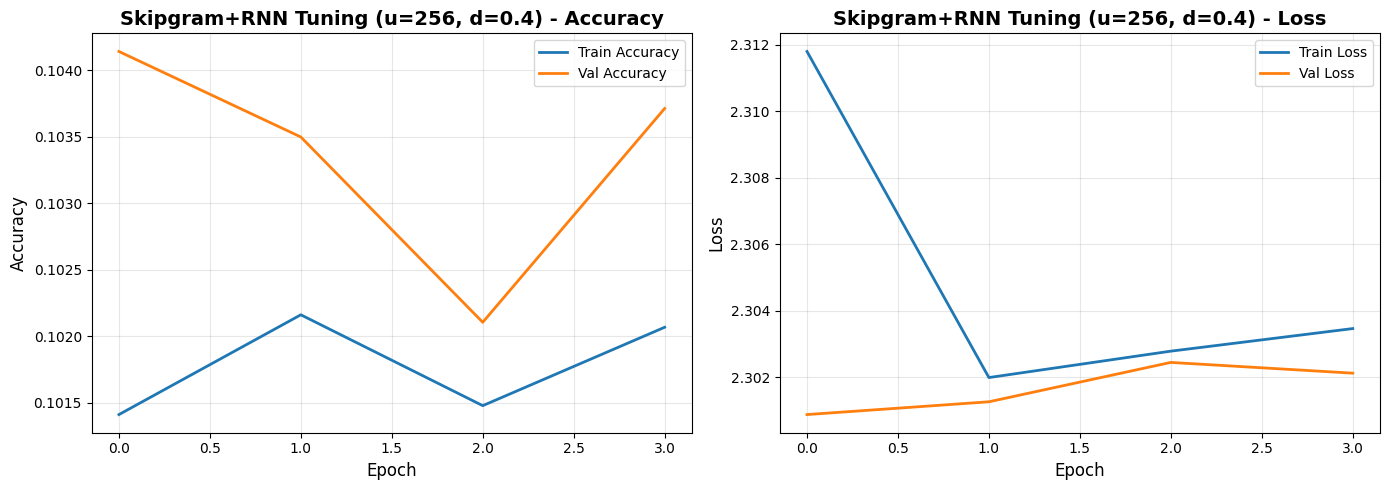

Val Acc: 0.1041, Val F1: 0.0250

Testing Skipgram+GRU with params: {'units': 128, 'dropout': 0.3, 'lr': 0.001, 'batch': 64, 'trainable_embed': False}
Epoch 1/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.1533 - loss: 2.2028 - val_accuracy: 0.5854 - val_loss: 1.2270
Epoch 2/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.6316 - loss: 1.1681 - val_accuracy: 0.6821 - val_loss: 1.0077
Epoch 3/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.6763 - loss: 1.0357 - val_accuracy: 0.6895 - val_loss: 0.9805
Epoch 4/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.6857 - loss: 0.9980 - val_accuracy: 0.6927 - val_loss: 0.9505
Epoch 5/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.6950 - loss: 0.9699 - val_accuracy: 0.6969 - val_loss: 0.9472
Epoch 6/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.6997 - loss: 0.9506 - val_accuracy: 0.7004 - val_loss: 0.9317
Epoch 7/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - 

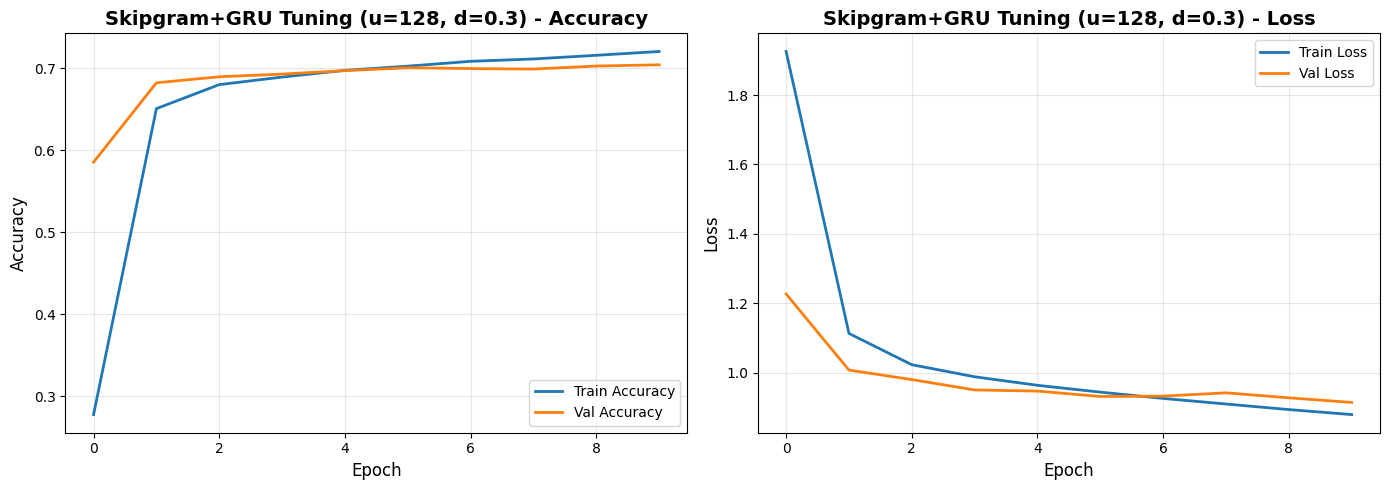

Val Acc: 0.7040, Val F1: 0.6971

Testing Skipgram+GRU with params: {'units': 256, 'dropout': 0.4, 'lr': 0.0005, 'batch': 64, 'trainable_embed': False}
Epoch 1/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step - accuracy: 0.1012 - loss: 2.3158 - val_accuracy: 0.1069 - val_loss: 2.2927
Epoch 2/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.1059 - loss: 2.2921 - val_accuracy: 0.1288 - val_loss: 2.4419
Epoch 3/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.1683 - loss: 2.1774 - val_accuracy: 0.6477 - val_loss: 1.1023
Epoch 4/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.6437 - loss: 1.1429 - val_accuracy: 0.6663 - val_loss: 1.0412
Epoch 5/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.6726 - loss: 1.0560 - val_accuracy: 0.6858 - val_loss: 0.9833
Epoch 6/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.6839 - loss: 1.0140 - val_accuracy: 0.6853 - val_loss: 0.9737
Epoch 7/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step -

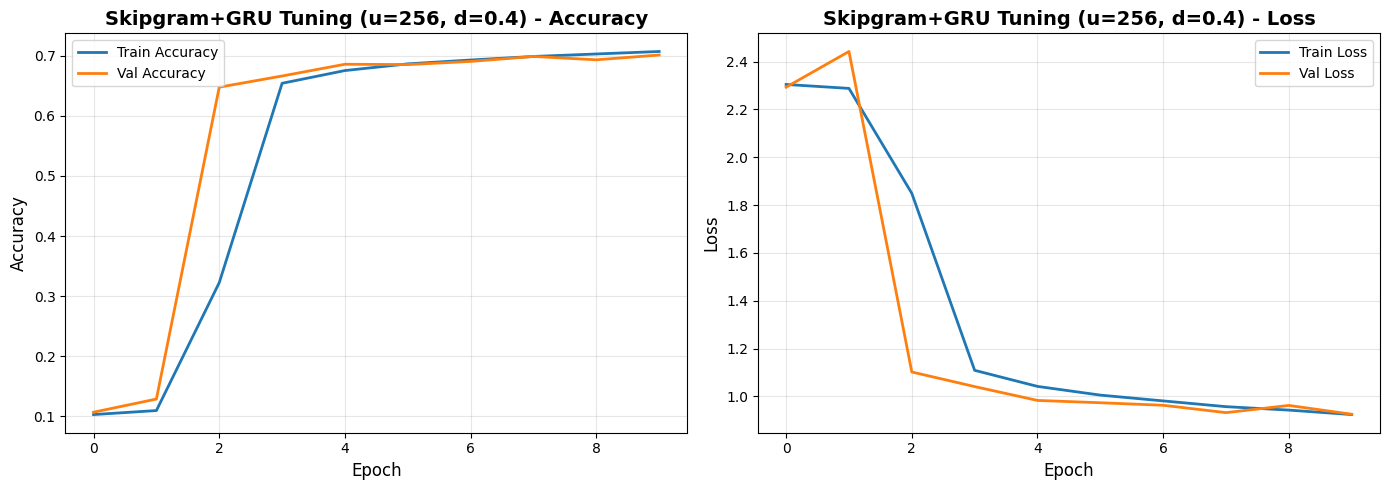

Val Acc: 0.7012, Val F1: 0.7005

Testing Skipgram+LSTM with params: {'units': 128, 'dropout': 0.3, 'lr': 0.001, 'batch': 64, 'trainable_embed': False}
Epoch 1/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.1031 - loss: 2.3068 - val_accuracy: 0.1095 - val_loss: 2.2916
Epoch 2/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.1438 - loss: 2.2088 - val_accuracy: 0.5282 - val_loss: 1.4307
Epoch 3/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.5444 - loss: 1.4214 - val_accuracy: 0.6186 - val_loss: 1.2382
Epoch 4/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.6188 - loss: 1.2493 - val_accuracy: 0.6490 - val_loss: 1.1213
Epoch 5/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.6511 - loss: 1.1512 - val_accuracy: 0.6726 - val_loss: 1.0576
Epoch 6/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.6679 - loss: 1.0926 - val_accuracy: 0.6734 - val_loss: 1.0381
Epoch 7/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step -

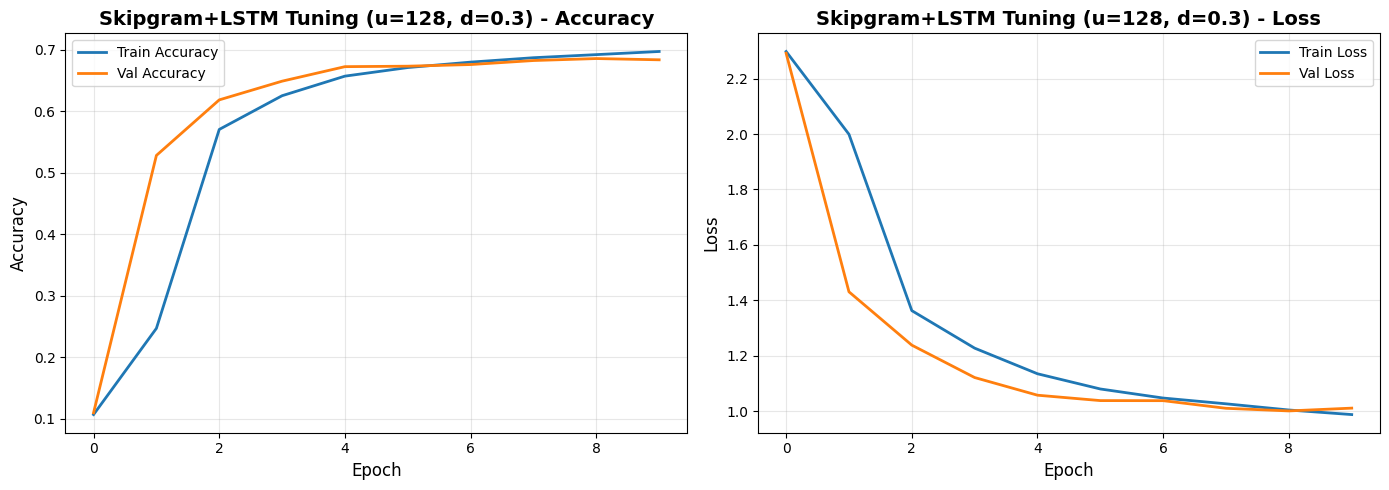

Val Acc: 0.6858, Val F1: 0.6804

Testing Skipgram+LSTM with params: {'units': 256, 'dropout': 0.4, 'lr': 0.0005, 'batch': 64, 'trainable_embed': False}
Epoch 1/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - accuracy: 0.1023 - loss: 2.3105 - val_accuracy: 0.1044 - val_loss: 2.2995
Epoch 2/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.1043 - loss: 2.2965 - val_accuracy: 0.1088 - val_loss: 2.2907
Epoch 3/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.1063 - loss: 2.2897 - val_accuracy: 0.1105 - val_loss: 2.2868
Epoch 4/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.1304 - loss: 2.2522 - val_accuracy: 0.5679 - val_loss: 1.3528
Epoch 5/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.5781 - loss: 1.3388 - val_accuracy: 0.6371 - val_loss: 1.1449
Epoch 6/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.6425 - loss: 1.1593 - val_accuracy: 0.6636 - val_loss: 1.0680
Epoch 7/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step 

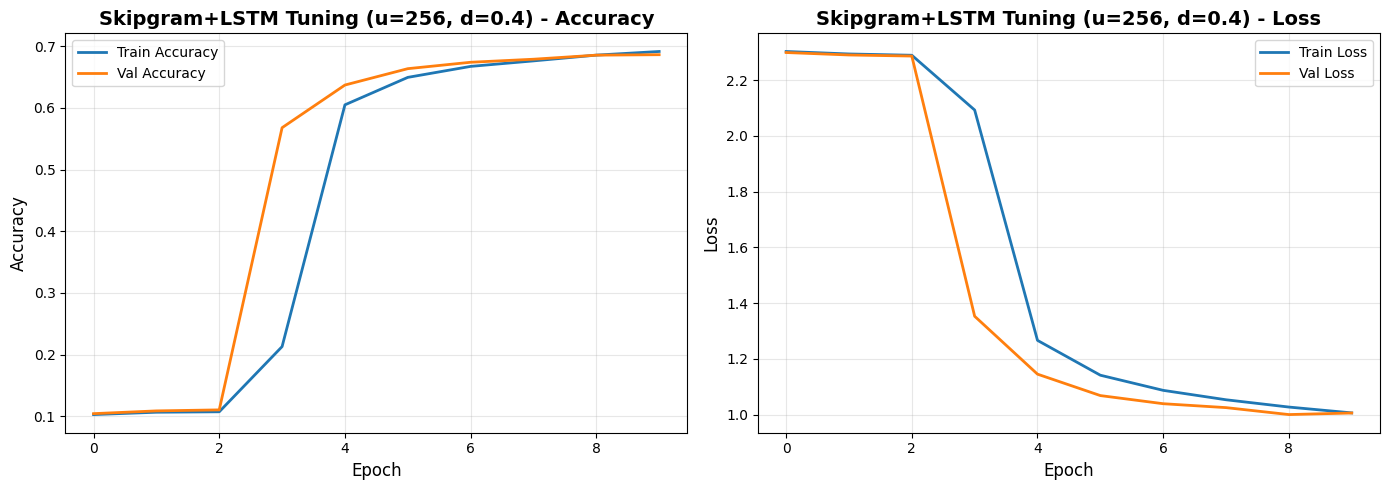

Val Acc: 0.6862, Val F1: 0.6826

Testing Skipgram+BiRNN with params: {'units': 128, 'dropout': 0.3, 'lr': 0.001, 'batch': 64, 'trainable_embed': False}
Epoch 1/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 46s 35ms/step - accuracy: 0.4644 - loss: 1.5821 - val_accuracy: 0.6288 - val_loss: 1.1587
Epoch 2/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 37s 32ms/step - accuracy: 0.6193 - loss: 1.2167 - val_accuracy: 0.6300 - val_loss: 1.1629
Epoch 3/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 37s 32ms/step - accuracy: 0.6335 - loss: 1.1801 - val_accuracy: 0.6476 - val_loss: 1.1177
Epoch 4/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 37s 32ms/step - accuracy: 0.6399 - loss: 1.1591 - val_accuracy: 0.6345 - val_loss: 1.1553
Epoch 5/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 37s 32ms/step - accuracy: 0.6369 - loss: 1.1772 - val_accuracy: 0.6420 - val_loss: 1.1318
Epoch 6/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 37s 32ms/step - accuracy: 0.6417 - loss: 1.1519 - val_accuracy: 0.6404 - val_loss: 1.1291


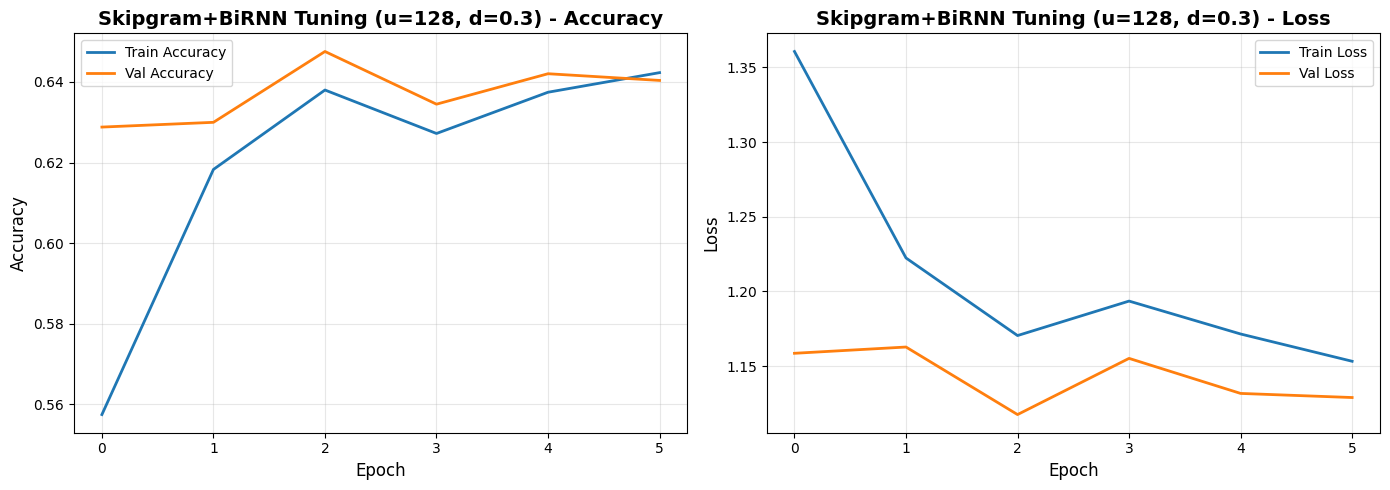

Val Acc: 0.6476, Val F1: 0.6421

Testing Skipgram+BiRNN with params: {'units': 256, 'dropout': 0.4, 'lr': 0.0005, 'batch': 64, 'trainable_embed': False}
Epoch 1/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 53s 40ms/step - accuracy: 0.3890 - loss: 1.7687 - val_accuracy: 0.6411 - val_loss: 1.1267
Epoch 2/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 42s 36ms/step - accuracy: 0.6055 - loss: 1.2587 - val_accuracy: 0.6306 - val_loss: 1.1772
Epoch 3/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 42s 36ms/step - accuracy: 0.6340 - loss: 1.1871 - val_accuracy: 0.6353 - val_loss: 1.1510
Epoch 4/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 42s 36ms/step - accuracy: 0.6347 - loss: 1.1796 - val_accuracy: 0.6532 - val_loss: 1.1072
Epoch 5/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 42s 36ms/step - accuracy: 0.6457 - loss: 1.1375 - val_accuracy: 0.6513 - val_loss: 1.1037
Epoch 6/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 42s 36ms/step - accuracy: 0.6523 - loss: 1.1254 - val_accuracy: 0.6485 - val_loss: 1.1075
Epoch 7/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 42s 36ms/step

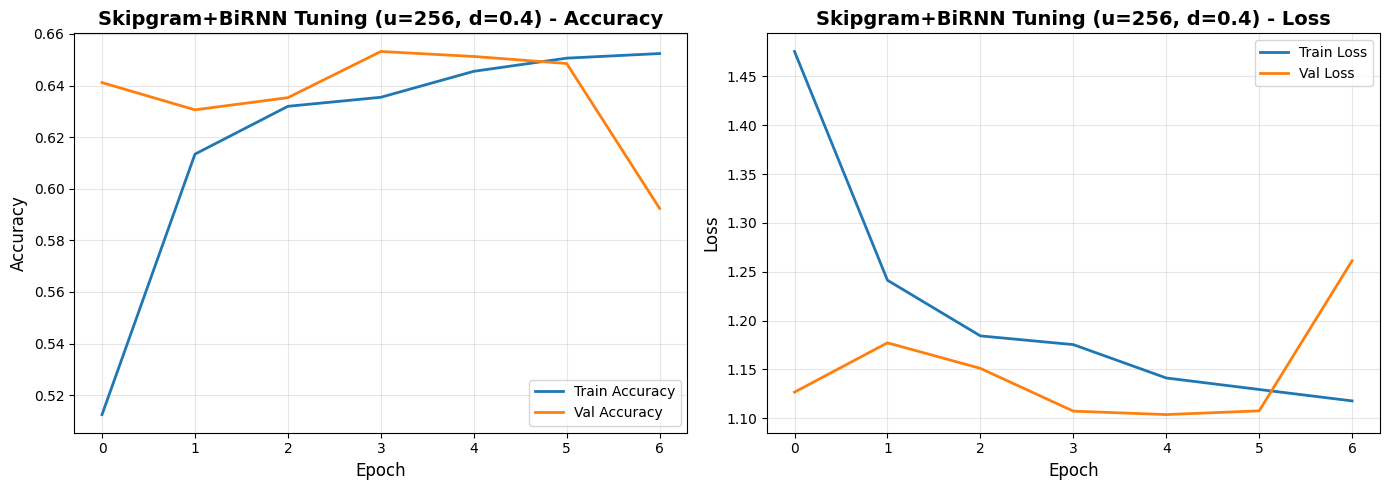

Val Acc: 0.6532, Val F1: 0.6448

Testing Skipgram+BiGRU with params: {'units': 128, 'dropout': 0.3, 'lr': 0.001, 'batch': 64, 'trainable_embed': False}
Epoch 1/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 30s 21ms/step - accuracy: 0.5219 - loss: 1.4139 - val_accuracy: 0.6773 - val_loss: 1.0068
Epoch 2/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 38s 22ms/step - accuracy: 0.6804 - loss: 1.0151 - val_accuracy: 0.6889 - val_loss: 0.9619
Epoch 3/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.6923 - loss: 0.9727 - val_accuracy: 0.6967 - val_loss: 0.9402
Epoch 4/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - accuracy: 0.6973 - loss: 0.9492 - val_accuracy: 0.6975 - val_loss: 0.9319
Epoch 5/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - accuracy: 0.6995 - loss: 0.9341 - val_accuracy: 0.6968 - val_loss: 0.9380
Epoch 6/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - accuracy: 0.7061 - loss: 0.9180 - val_accuracy: 0.6991 - val_loss: 0.9282
Epoch 7/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step 

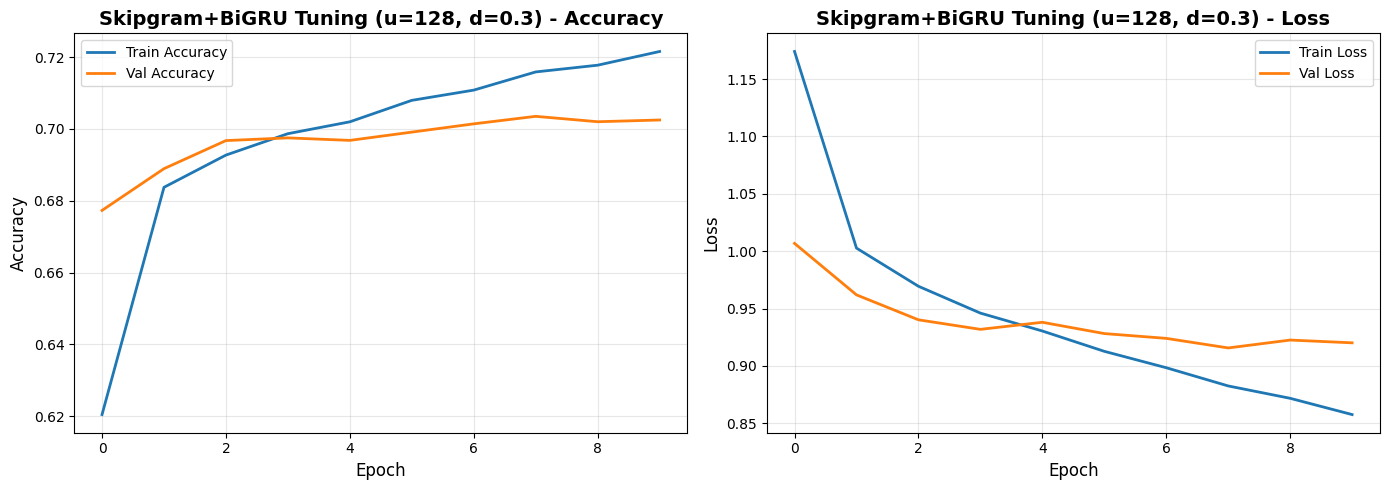

Val Acc: 0.7035, Val F1: 0.6991

Testing Skipgram+BiGRU with params: {'units': 256, 'dropout': 0.4, 'lr': 0.0005, 'batch': 64, 'trainable_embed': False}
Epoch 1/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 43s 32ms/step - accuracy: 0.4922 - loss: 1.4921 - val_accuracy: 0.6766 - val_loss: 1.0108
Epoch 2/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 38s 33ms/step - accuracy: 0.6701 - loss: 1.0491 - val_accuracy: 0.6837 - val_loss: 0.9850
Epoch 3/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - accuracy: 0.6848 - loss: 1.0030 - val_accuracy: 0.6937 - val_loss: 0.9571
Epoch 4/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - accuracy: 0.6899 - loss: 0.9811 - val_accuracy: 0.6919 - val_loss: 0.9479
Epoch 5/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - accuracy: 0.6941 - loss: 0.9634 - val_accuracy: 0.6986 - val_loss: 0.9258
Epoch 6/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - accuracy: 0.6991 - loss: 0.9473 - val_accuracy: 0.6964 - val_loss: 0.9335
Epoch 7/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 38s 33ms/step

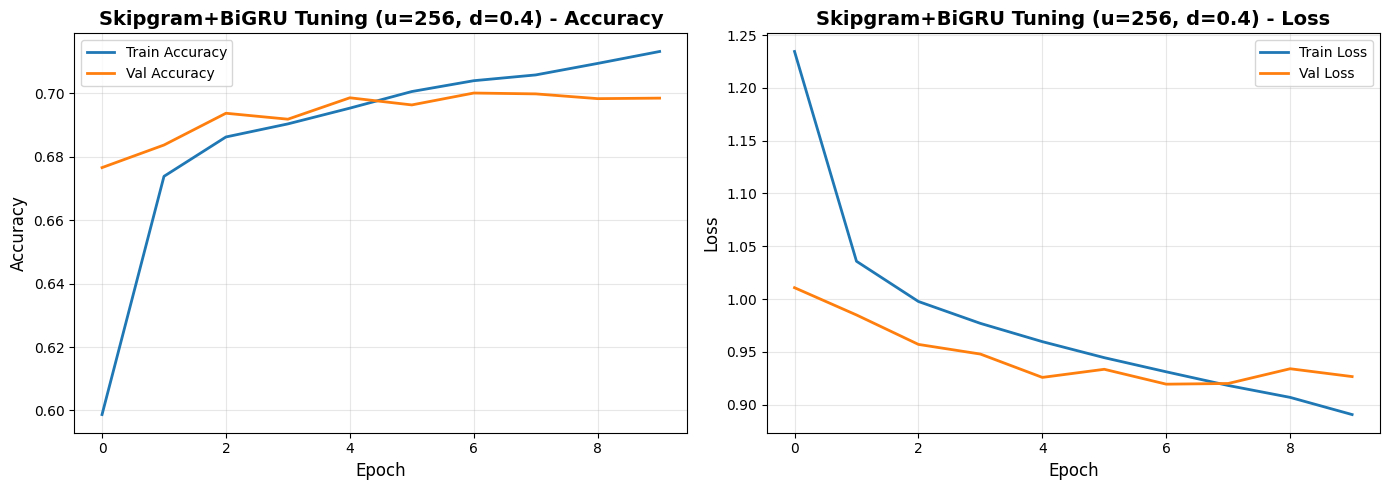

Val Acc: 0.7001, Val F1: 0.6938

Testing Skipgram+BiLSTM with params: {'units': 128, 'dropout': 0.3, 'lr': 0.001, 'batch': 64, 'trainable_embed': False}
Epoch 1/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 34s 24ms/step - accuracy: 0.5458 - loss: 1.3751 - val_accuracy: 0.6718 - val_loss: 1.0338
Epoch 2/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 27s 23ms/step - accuracy: 0.6742 - loss: 1.0278 - val_accuracy: 0.6898 - val_loss: 0.9698
Epoch 3/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - accuracy: 0.6873 - loss: 0.9838 - val_accuracy: 0.6954 - val_loss: 0.9558
Epoch 4/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - accuracy: 0.6949 - loss: 0.9573 - val_accuracy: 0.6985 - val_loss: 0.9362
Epoch 5/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step - accuracy: 0.7026 - loss: 0.9335 - val_accuracy: 0.7010 - val_loss: 0.9292
Epoch 6/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - accuracy: 0.7075 - loss: 0.9130 - val_accuracy: 0.7002 - val_loss: 0.9254
Epoch 7/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step

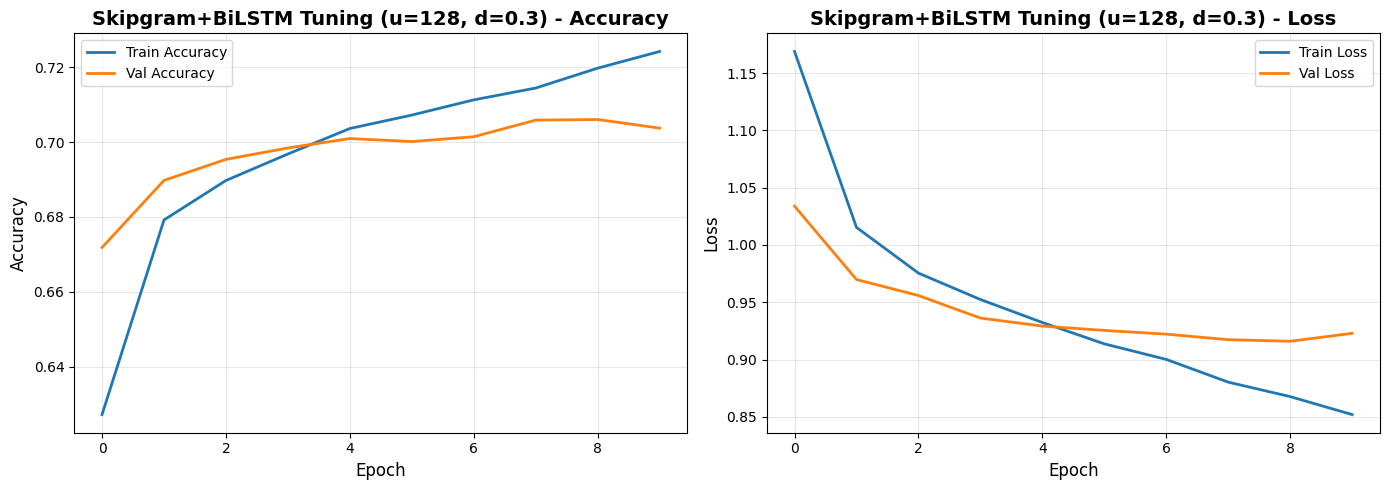

Val Acc: 0.7061, Val F1: 0.7003

Testing Skipgram+BiLSTM with params: {'units': 256, 'dropout': 0.4, 'lr': 0.0005, 'batch': 64, 'trainable_embed': False}
Epoch 1/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 49s 36ms/step - accuracy: 0.5102 - loss: 1.4700 - val_accuracy: 0.6749 - val_loss: 1.0371
Epoch 2/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 42s 36ms/step - accuracy: 0.6678 - loss: 1.0575 - val_accuracy: 0.6797 - val_loss: 0.9964
Epoch 3/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.6784 - loss: 1.0206 - val_accuracy: 0.6900 - val_loss: 0.9753
Epoch 4/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.6869 - loss: 0.9882 - val_accuracy: 0.6859 - val_loss: 0.9687
Epoch 5/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.6958 - loss: 0.9674 - val_accuracy: 0.6922 - val_loss: 0.9536
Epoch 6/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.6970 - loss: 0.9532 - val_accuracy: 0.6961 - val_loss: 0.9418
Epoch 7/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/ste

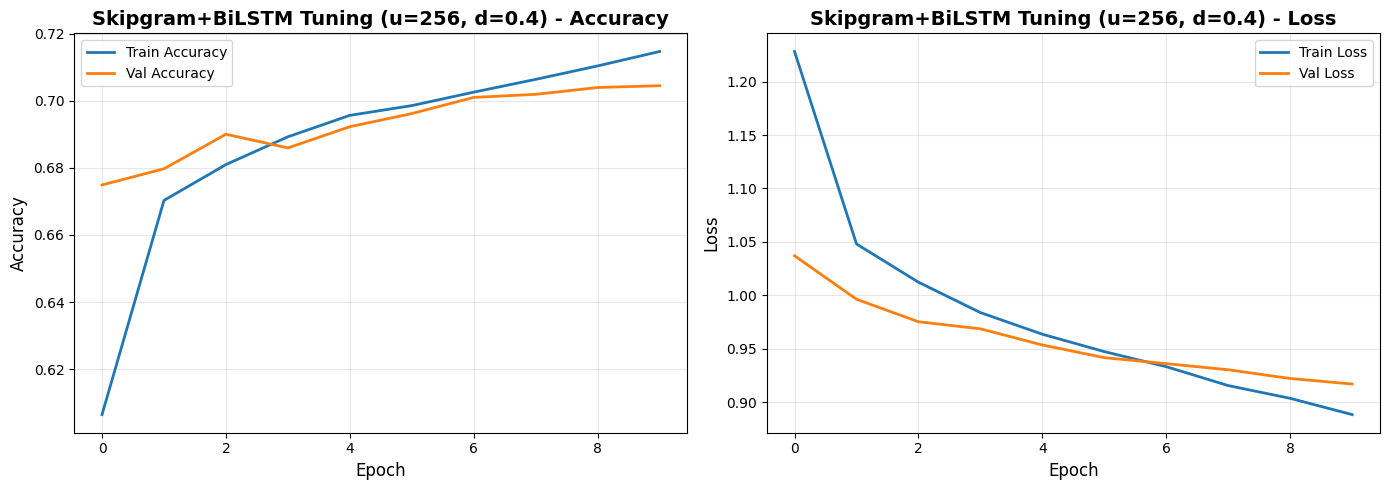

Val Acc: 0.7045, Val F1: 0.7009

HYPERPARAMETER TUNING RESULTS
          model  val_acc  val_f1_macro  time_sec
Skipgram+BiLSTM 0.704452      0.700912    412.34
   Skipgram+GRU 0.701184      0.700498    203.21
Skipgram+BiLSTM 0.706059      0.700341    262.57
 Skipgram+BiGRU 0.703487      0.699104    254.32
   Skipgram+GRU 0.704023      0.697140    146.81
 Skipgram+BiGRU 0.700112      0.693806    372.50
  Skipgram+LSTM 0.686238      0.682593    242.21
     TF-IDF+DNN 0.685381      0.682129     37.53
  Skipgram+LSTM 0.685809      0.680400    150.51
     TF-IDF+DNN 0.681202      0.676025     33.86
 Skipgram+BiRNN 0.653185      0.644820    305.44
 Skipgram+BiRNN 0.647560      0.642091    232.13
   Skipgram+RNN 0.106445      0.030175    208.90
   Skipgram+RNN 0.104141      0.025004    100.31

BEST CONFIGURATION PER MODEL
          model  val_f1_macro                                                                              params
 Skipgram+BiGRU      0.699104  {'units': 128, 'dropout': 0

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import time
import gc

tf.config.optimizer.set_jit(True)
AUTOTUNE = tf.data.AUTOTUNE

train_labels_np = np.array(train_labels)
val_labels_np = np.array(val_labels)
test_labels_np = np.array(test_df['label_id'])

def compute_metrics(y_true, y_pred):
    return {
        "acc": accuracy_score(y_true, y_pred),
        "f1_macro": f1_score(y_true, y_pred, average="macro"),
        "f1_weighted": f1_score(y_true, y_pred, average="weighted")
    }

def sparse_batch_generator(X_sparse, y_np, batch_size=64, shuffle=True):
    n = X_sparse.shape[0]
    idx = np.arange(n)
    while True:
        if shuffle:
            np.random.shuffle(idx)
        for start in range(0, n, batch_size):
            batch_idx = idx[start:start+batch_size]
            X_batch = X_sparse[batch_idx].toarray().astype(np.float32)
            y_batch = y_np[batch_idx]
            yield X_batch, y_batch

def build_tfidf_dnn(input_dim, num_classes, hidden=256, dropout=0.3, lr=1e-3):
    inp = layers.Input(shape=(input_dim,))
    x = layers.Dense(hidden, activation="relu")(inp)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(hidden//2, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inp, out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

def make_seq_dataset(X, y_np, batch_size=64, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((X, y_np))
    if shuffle:
        ds = ds.shuffle(5000)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

def build_skipgram_seq(model_type, vocab_size, embedding_matrix, max_len,
                       num_classes, units=128, dropout=0.3, lr=1e-3, trainable_embed=False):
    inp = layers.Input(shape=(max_len,))
    x = layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_matrix.shape[1],
        weights=[embedding_matrix],
        trainable=trainable_embed
    )(inp)
    if model_type == "RNN":
        x = layers.SimpleRNN(units)(x)
    elif model_type == "GRU":
        x = layers.GRU(units)(x)
    elif model_type == "LSTM":
        x = layers.LSTM(units)(x)
    elif model_type == "BiRNN":
        x = layers.Bidirectional(layers.SimpleRNN(units))(x)
    elif model_type == "BiGRU":
        x = layers.Bidirectional(layers.GRU(units))(x)
    elif model_type == "BiLSTM":
        x = layers.Bidirectional(layers.LSTM(units))(x)
    else:
        raise ValueError("Invalid model type")
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inp, out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

def plot_training_history(history, model_name):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[0].set_title(f'{model_name} - Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[1].set_title(f'{model_name} - Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=3, restore_best_weights=True
)

print("\n" + "="*80)
print("HYPERPARAMETER TUNING - TF-IDF + DNN")
print("="*80)

tfidf_grid = [
    {"hidden": 256, "dropout": 0.3, "lr": 1e-3, "batch": 64},
    {"hidden": 512, "dropout": 0.4, "lr": 5e-4, "batch": 64},
]

tuning_results = []
input_dim = X_train_tfidf.shape[1]

for params in tfidf_grid:
    print(f"\nTesting TF-IDF+DNN with params: {params}")
    model = build_tfidf_dnn(
        input_dim=input_dim,
        num_classes=num_classes,
        hidden=params["hidden"],
        dropout=params["dropout"],
        lr=params["lr"]
    )
    steps_per_epoch = int(np.ceil(X_train_tfidf.shape[0] / params["batch"]))
    val_steps = int(np.ceil(X_val_tfidf.shape[0] / params["batch"]))
    train_gen = sparse_batch_generator(X_train_tfidf, train_labels_np, params["batch"], shuffle=True)
    val_gen = sparse_batch_generator(X_val_tfidf, val_labels_np, params["batch"], shuffle=False)
    start = time.time()
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        steps_per_epoch=steps_per_epoch,
        validation_steps=val_steps,
        epochs=10,
        callbacks=[early_stop],
        verbose=1
    )
    duration = time.time() - start
    plot_training_history(history, f"TF-IDF+DNN Tuning (h={params['hidden']}, d={params['dropout']})")
    val_preds = []
    val_gen_eval = sparse_batch_generator(X_val_tfidf, val_labels_np, params["batch"], shuffle=False)
    for _ in range(val_steps):
        Xb, yb = next(val_gen_eval)
        probs = model.predict(Xb, verbose=0)
        val_preds.extend(np.argmax(probs, axis=1))
    val_preds = np.array(val_preds[:len(val_labels_np)])
    metrics = compute_metrics(val_labels_np, val_preds)
    tuning_results.append({
        "model": "TF-IDF+DNN",
        "params": str(params),
        "val_acc": metrics["acc"],
        "val_f1_macro": metrics["f1_macro"],
        "val_f1_weighted": metrics["f1_weighted"],
        "time_sec": round(duration, 2)
    })
    print(f"Val Acc: {metrics['acc']:.4f}, Val F1: {metrics['f1_macro']:.4f}")
    tf.keras.backend.clear_session()
    del model
    gc.collect()

print("\n" + "="*80)
print("HYPERPARAMETER TUNING - SKIP-GRAM + RNN MODELS")
print("="*80)

skipgram_grid = [
    {"units": 128, "dropout": 0.3, "lr": 1e-3, "batch": 64, "trainable_embed": False},
    {"units": 256, "dropout": 0.4, "lr": 5e-4, "batch": 64, "trainable_embed": False},
]

seq_models = ["RNN", "GRU", "LSTM", "BiRNN", "BiGRU", "BiLSTM"]

for arch in seq_models:
    for params in skipgram_grid:
        print(f"\nTesting Skipgram+{arch} with params: {params}")
        model = build_skipgram_seq(
            model_type=arch,
            vocab_size=VOCAB_SIZE,
            embedding_matrix=embedding_matrix,
            max_len=MAX_LEN,
            num_classes=num_classes,
            units=params["units"],
            dropout=params["dropout"],
            lr=params["lr"],
            trainable_embed=params["trainable_embed"]
        )
        train_ds = make_seq_dataset(X_train_pad, train_labels_np, params["batch"], shuffle=True)
        val_ds = make_seq_dataset(X_val_pad, val_labels_np, params["batch"], shuffle=False)
        start = time.time()
        history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[early_stop], verbose=1)
        duration = time.time() - start
        plot_training_history(history, f"Skipgram+{arch} Tuning (u={params['units']}, d={params['dropout']})")
        val_probs = model.predict(X_val_pad, verbose=0)
        val_pred = np.argmax(val_probs, axis=1)
        metrics = compute_metrics(val_labels_np, val_pred)
        tuning_results.append({
            "model": f"Skipgram+{arch}",
            "params": str(params),
            "val_acc": metrics["acc"],
            "val_f1_macro": metrics["f1_macro"],
            "val_f1_weighted": metrics["f1_weighted"],
            "time_sec": round(duration, 2)
        })
        print(f"Val Acc: {metrics['acc']:.4f}, Val F1: {metrics['f1_macro']:.4f}")
        tf.keras.backend.clear_session()
        del model
        gc.collect()

tuning_df = pd.DataFrame(tuning_results).sort_values("val_f1_macro", ascending=False)

print("\n" + "="*80)
print("HYPERPARAMETER TUNING RESULTS")
print("="*80)
print(tuning_df[["model","val_acc","val_f1_macro","time_sec"]].to_string(index=False))

best_per_model = tuning_df.groupby("model").first().reset_index()
print("\n" + "="*80)
print("BEST CONFIGURATION PER MODEL")
print("="*80)
print(best_per_model[["model","val_f1_macro","params"]].to_string(index=False))

## **TESTING**


RANDOM FOREST HYPERPARAMETER TUNING

🔍 Testing 6 different hyperparameter configurations...

[1/6] Training with parameters:
  n_estimators: 100
  max_depth: None
  min_samples_split: 2
  min_samples_leaf: 1
  max_features: sqrt
  ✅ Val Accuracy: 0.5904
  ✅ Val F1-macro: 0.5846
  ⏱️  Training time: 345.43s

[2/6] Training with parameters:
  n_estimators: 200
  max_depth: None
  min_samples_split: 2
  min_samples_leaf: 1
  max_features: sqrt
  ✅ Val Accuracy: 0.5931
  ✅ Val F1-macro: 0.5870
  ⏱️  Training time: 710.36s

[3/6] Training with parameters:
  n_estimators: 100
  max_depth: 20
  min_samples_split: 5
  min_samples_leaf: 2
  max_features: sqrt
  ✅ Val Accuracy: 0.5429
  ✅ Val F1-macro: 0.5387
  ⏱️  Training time: 11.30s

[4/6] Training with parameters:
  n_estimators: 200
  max_depth: 30
  min_samples_split: 5
  min_samples_leaf: 2
  max_features: sqrt
  ✅ Val Accuracy: 0.5606
  ✅ Val F1-macro: 0.5564
  ⏱️  Training time: 42.51s

[5/6] Training with parameters:
  n_estimators: 

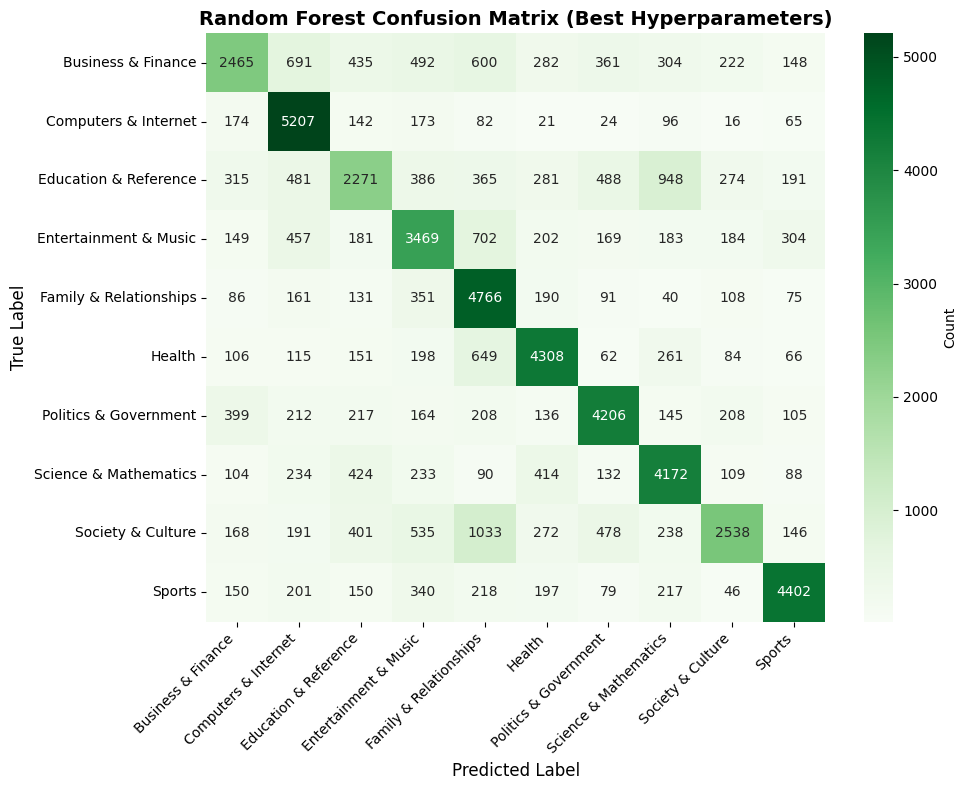


TOP 20 MOST IMPORTANT FEATURES

Rank | Feature | Importance
--------------------------------------------------
   1 | song                           | 0.009567
   2 | team                           | 0.009076
   3 | computer                       | 0.008503
   4 | player                         | 0.007002
   5 | god                            | 0.006314
   6 | guy                            | 0.006293
   7 | bush                           | 0.006260
   8 | girl                           | 0.006141
   9 | world cup                      | 0.005948
  10 | football                       | 0.005744
  11 | cup                            | 0.005735
  12 | doctor                         | 0.005695
  13 | game                           | 0.005458
  14 | window                         | 0.005125
  15 | software                       | 0.005076
  16 | love                           | 0.004818
  17 | file                           | 0.004764
  18 | president                      | 0.004375
  19 |

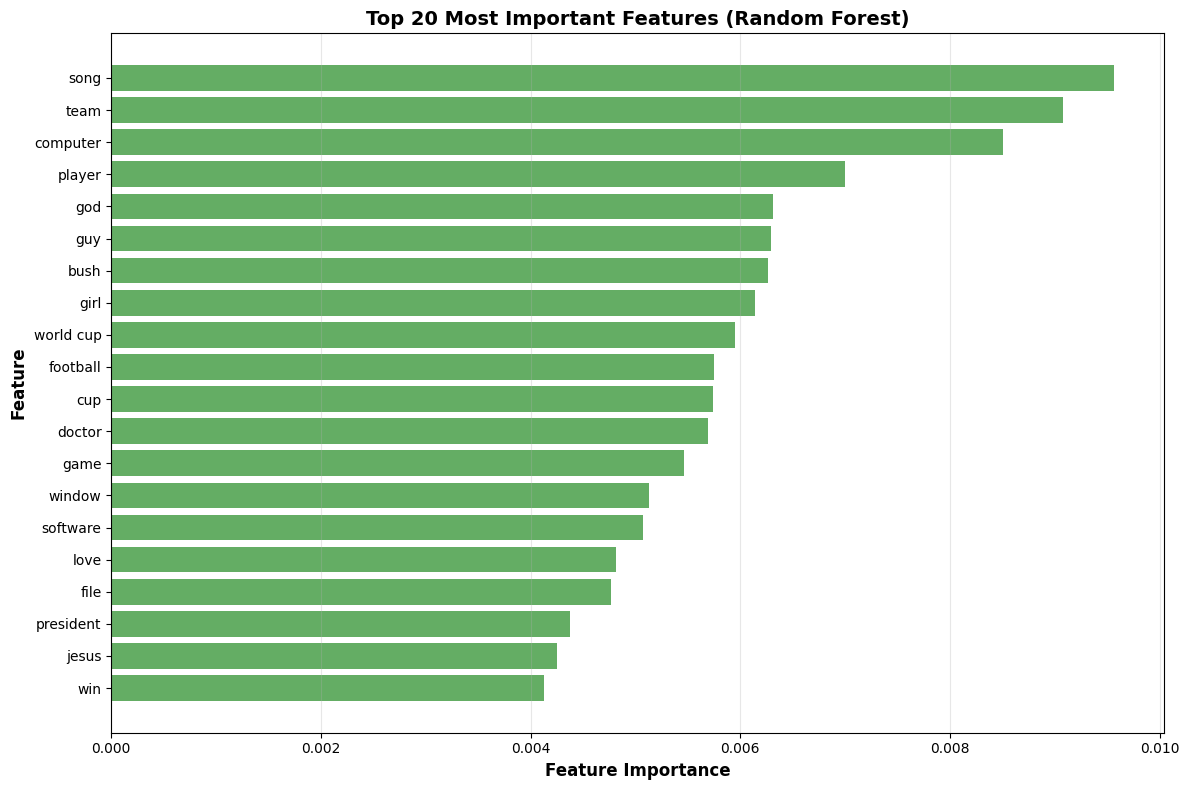


VALIDATION vs TEST PERFORMANCE COMPARISON
     Metric Validation   Test Difference
   Accuracy     0.6335 0.6301    -0.0034
   F1-macro     0.6240 0.6213    -0.0028
F1-weighted     0.6238 0.6213    -0.0025

PERFORMANCE ACROSS ALL CONFIGURATIONS


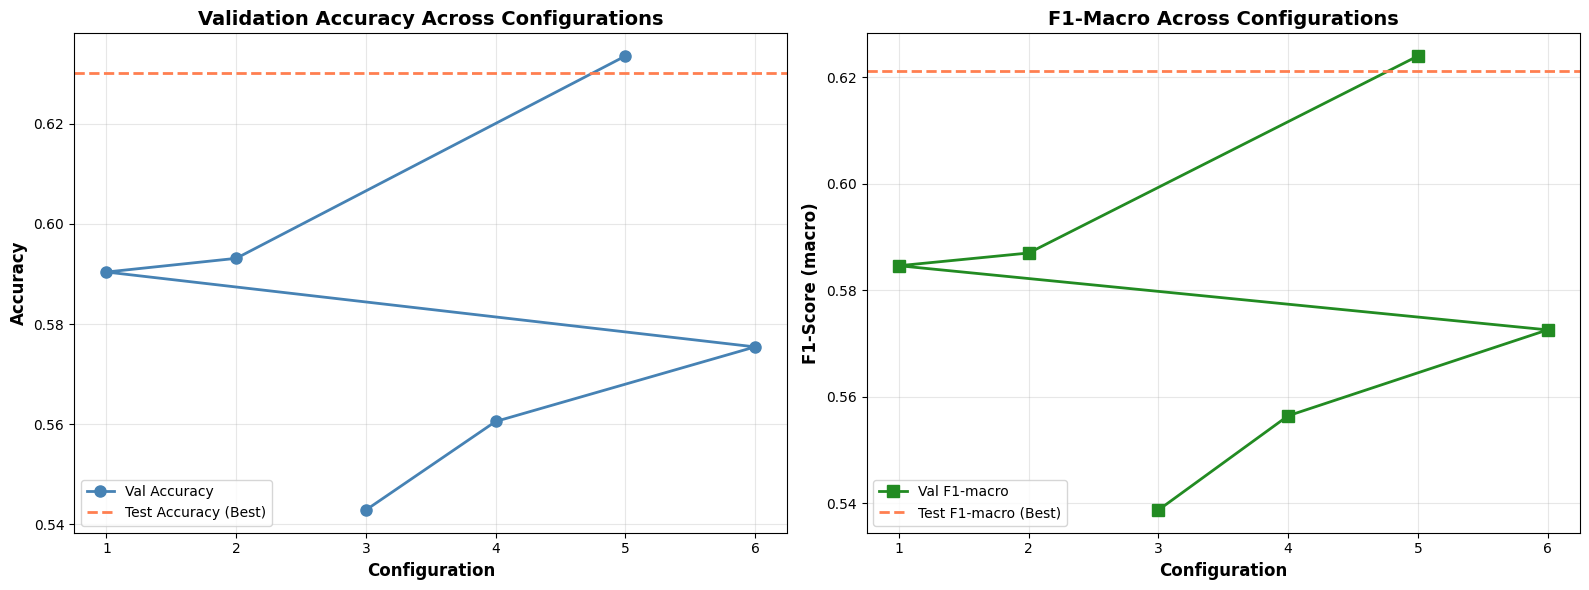


SAVING RESULTS

✅ Random Forest hyperparameter tuning and testing complete!
✅ Best model saved as 'final_rf_model'
✅ Best configuration: {'n_estimators': 150, 'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2'}
✅ Test F1-macro: 0.6213

RANDOM FOREST TUNING AND TESTING COMPLETED!


In [52]:
print("\n" + "="*80)
print("RANDOM FOREST HYPERPARAMETER TUNING")
print("="*80)

import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

rf_param_grid = [
    {
        'n_estimators': 100,
        'max_depth': None,
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        'max_features': 'sqrt'
    },
    {
        'n_estimators': 200,
        'max_depth': None,
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        'max_features': 'sqrt'
    },
    {
        'n_estimators': 100,
        'max_depth': 20,
        'min_samples_split': 5,
        'min_samples_leaf': 2,
        'max_features': 'sqrt'
    },
    {
        'n_estimators': 200,
        'max_depth': 30,
        'min_samples_split': 5,
        'min_samples_leaf': 2,
        'max_features': 'sqrt'
    },
    {
        'n_estimators': 150,
        'max_depth': None,
        'min_samples_split': 10,
        'min_samples_leaf': 4,
        'max_features': 'log2'
    },
    {
        'n_estimators': 300,
        'max_depth': 50,
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        'max_features': 'sqrt'
    }
]

rf_tuning_results = []

print(f"\n Testing {len(rf_param_grid)} different hyperparameter configurations...")
print("="*80)

for idx, params in enumerate(rf_param_grid, 1):
    print(f"\n[{idx}/{len(rf_param_grid)}] Training with parameters:")
    print(f"  n_estimators: {params['n_estimators']}")
    print(f"  max_depth: {params['max_depth']}")
    print(f"  min_samples_split: {params['min_samples_split']}")
    print(f"  min_samples_leaf: {params['min_samples_leaf']}")
    print(f"  max_features: {params['max_features']}")

    start_time = time.time()

    rf_model = RandomForestClassifier(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        min_samples_split=params['min_samples_split'],
        min_samples_leaf=params['min_samples_leaf'],
        max_features=params['max_features'],
        random_state=SEED,
        n_jobs=-1,
        verbose=0
    )

    rf_model.fit(X_train_tfidf, train_labels)

    val_pred = rf_model.predict(X_val_tfidf)

    val_acc = accuracy_score(val_labels, val_pred)
    val_f1_macro = f1_score(val_labels, val_pred, average='macro')
    val_f1_weighted = f1_score(val_labels, val_pred, average='weighted')

    training_time = time.time() - start_time

    rf_tuning_results.append({
        'model': 'RF+TF-IDF',
        'config': idx,
        'params': params,
        'val_acc': val_acc,
        'val_f1_macro': val_f1_macro,
        'val_f1_weighted': val_f1_weighted,
        'time_sec': training_time
    })

    print(f"   Val Accuracy: {val_acc:.4f}")
    print(f"   Val F1-macro: {val_f1_macro:.4f}")
    print(f"  ⏱  Training time: {training_time:.2f}s")

rf_tuning_df = pd.DataFrame(rf_tuning_results)
rf_tuning_df = rf_tuning_df.sort_values('val_f1_macro', ascending=False)

print("\n" + "="*80)
print("RANDOM FOREST TUNING RESULTS")
print("="*80)
print("\nAll Configurations (sorted by F1-macro):")
print(rf_tuning_df[['config', 'val_acc', 'val_f1_macro', 'val_f1_weighted', 'time_sec']].to_string(index=False))

print("\n" + "="*80)
print("BEST RANDOM FOREST CONFIGURATION")
print("="*80)
best_rf_config = rf_tuning_df.iloc[0]
print(f"\nConfiguration
print(f"Parameters: {best_rf_config['params']}")
print(f"Validation Accuracy: {best_rf_config['val_acc']:.4f}")
print(f"Validation F1-macro: {best_rf_config['val_f1_macro']:.4f}")
print(f"Validation F1-weighted: {best_rf_config['val_f1_weighted']:.4f}")
print(f"Training Time: {best_rf_config['time_sec']:.2f}s")

print("\n" + "="*80)
print("FINAL RANDOM FOREST TEST EVALUATION")
print("="*80)

best_params = best_rf_config['params']

print(f"\n Training final Random Forest model with best parameters...")
print(f"Parameters: {best_params}")

final_rf_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    random_state=SEED,
    n_jobs=-1,
    verbose=0
)

start_time = time.time()
final_rf_model.fit(X_train_tfidf, train_labels)
training_time = time.time() - start_time

print(f" Training completed in {training_time:.2f}s")

test_pred = final_rf_model.predict(X_test_tfidf)

test_acc = accuracy_score(test_labels_np, test_pred)
test_f1_macro = f1_score(test_labels_np, test_pred, average='macro')
test_f1_weighted = f1_score(test_labels_np, test_pred, average='weighted')

print("\n" + "="*80)
print("RANDOM FOREST TEST RESULTS (WITH TUNED HYPERPARAMETERS)")
print("="*80)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test F1-Score (macro): {test_f1_macro:.4f}")
print(f"Test F1-Score (weighted): {test_f1_weighted:.4f}")

print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORT")
print("="*80)
from sklearn.metrics import classification_report
print(classification_report(test_labels_np, test_pred, target_names=label_encoder.classes_))

print("\n" + "="*80)
print("CONFUSION MATRIX")
print("="*80)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(test_labels_np, test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Random Forest Confusion Matrix (Best Hyperparameters)',
          fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("TOP 20 MOST IMPORTANT FEATURES")
print("="*80)

feature_names = tfidf_vec.get_feature_names_out()
importances = final_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

print("\nRank | Feature | Importance")
print("-" * 50)
for i in range(min(20, len(indices))):
    print(f"{i+1:4d} | {feature_names[indices[i]]:30s} | {importances[indices[i]]:.6f}")

plt.figure(figsize=(12, 8))
top_n = 20
top_indices = indices[:top_n]
top_features = [feature_names[i] for i in top_indices]
top_importances = importances[top_indices]

plt.barh(range(top_n), top_importances, color='forestgreen', alpha=0.7)
plt.yticks(range(top_n), top_features)
plt.xlabel('Feature Importance', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title('Top 20 Most Important Features (Random Forest)',
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("VALIDATION vs TEST PERFORMANCE COMPARISON")
print("="*80)

comparison_data = {
    'Metric': ['Accuracy', 'F1-macro', 'F1-weighted'],
    'Validation': [
        f"{best_rf_config['val_acc']:.4f}",
        f"{best_rf_config['val_f1_macro']:.4f}",
        f"{best_rf_config['val_f1_weighted']:.4f}"
    ],
    'Test': [
        f"{test_acc:.4f}",
        f"{test_f1_macro:.4f}",
        f"{test_f1_weighted:.4f}"
    ],
    'Difference': [
        f"{(test_acc - best_rf_config['val_acc']):.4f}",
        f"{(test_f1_macro - best_rf_config['val_f1_macro']):.4f}",
        f"{(test_f1_weighted - best_rf_config['val_f1_weighted']):.4f}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

print("\n" + "="*80)
print("PERFORMANCE ACROSS ALL CONFIGURATIONS")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(rf_tuning_df['config'], rf_tuning_df['val_acc'],
             marker='o', linewidth=2, markersize=8, color='steelblue', label='Val Accuracy')
axes[0].axhline(y=test_acc, color='coral', linestyle='--', linewidth=2, label='Test Accuracy (Best)')
axes[0].set_xlabel('Configuration', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0].set_title('Validation Accuracy Across Configurations', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=10)
axes[0].set_xticks(rf_tuning_df['config'])

axes[1].plot(rf_tuning_df['config'], rf_tuning_df['val_f1_macro'],
             marker='s', linewidth=2, markersize=8, color='forestgreen', label='Val F1-macro')
axes[1].axhline(y=test_f1_macro, color='coral', linestyle='--', linewidth=2, label='Test F1-macro (Best)')
axes[1].set_xlabel('Configuration', fontsize=12, fontweight='bold')
axes[1].set_ylabel('F1-Score (macro)', fontsize=12, fontweight='bold')
axes[1].set_title('F1-Macro Across Configurations', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend(fontsize=10)
axes[1].set_xticks(rf_tuning_df['config'])

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("SAVING RESULTS")
print("="*80)

best_rf_results = {
    'model': 'RF+TF-IDF',
    'best_params': best_params,
    'val_acc': best_rf_config['val_acc'],
    'val_f1_macro': best_rf_config['val_f1_macro'],
    'val_f1_weighted': best_rf_config['val_f1_weighted'],
    'test_acc': test_acc,
    'test_f1_macro': test_f1_macro,
    'test_f1_weighted': test_f1_weighted,
    'training_time': training_time
}

print("\n Random Forest hyperparameter tuning and testing complete!")
print(f" Best model saved as 'final_rf_model'")
print(f" Best configuration: {best_params}")
print(f" Test F1-macro: {test_f1_macro:.4f}")

print("\n" + "="*80)
print("RANDOM FOREST TUNING AND TESTING COMPLETED!")
print("="*80)


FINAL EVALUATION ON TEST SET

TF-IDF+DNN - Using Best Hyperparameters from Tuning
Best Parameters: {'hidden': 512, 'dropout': 0.4, 'lr': 0.0005, 'batch': 64}
Expected Val Acc: 0.6854
Expected Val F1: 0.6821

Epoch 1/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.5177 - loss: 1.5246 - val_accuracy: 0.6845 - val_loss: 0.9951
Epoch 2/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7434 - loss: 0.8165 - val_accuracy: 0.6777 - val_loss: 1.0179
Epoch 3/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7972 - loss: 0.6480 - val_accuracy: 0.6678 - val_loss: 1.0988
Epoch 4/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8427 - loss: 0.4980 - val_accuracy: 0.6582 - val_loss: 1.2164


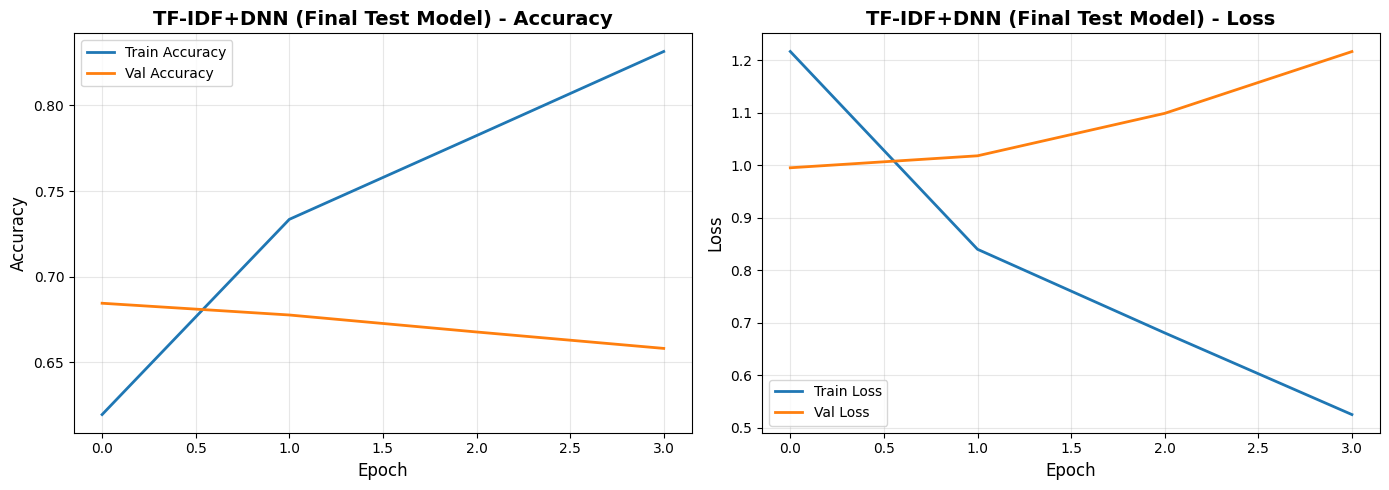


TF-IDF+DNN Test Results (with tuned hyperparameters):
Accuracy: 0.6813
F1-Score (macro): 0.6765
F1-Score (weighted): 0.6765

Classification Report:
                        precision    recall  f1-score   support

    Business & Finance       0.62      0.44      0.52      6000
  Computers & Internet       0.80      0.85      0.82      6000
 Education & Reference       0.52      0.49      0.51      6000
 Entertainment & Music       0.62      0.67      0.64      6000
Family & Relationships       0.68      0.74      0.71      5999
                Health       0.71      0.78      0.74      6000
 Politics & Government       0.71      0.77      0.74      6000
 Science & Mathematics       0.70      0.70      0.70      6000
     Society & Culture       0.60      0.52      0.56      6000
                Sports       0.81      0.85      0.83      6000

              accuracy                           0.68     59999
             macro avg       0.68      0.68      0.68     59999
          weighte

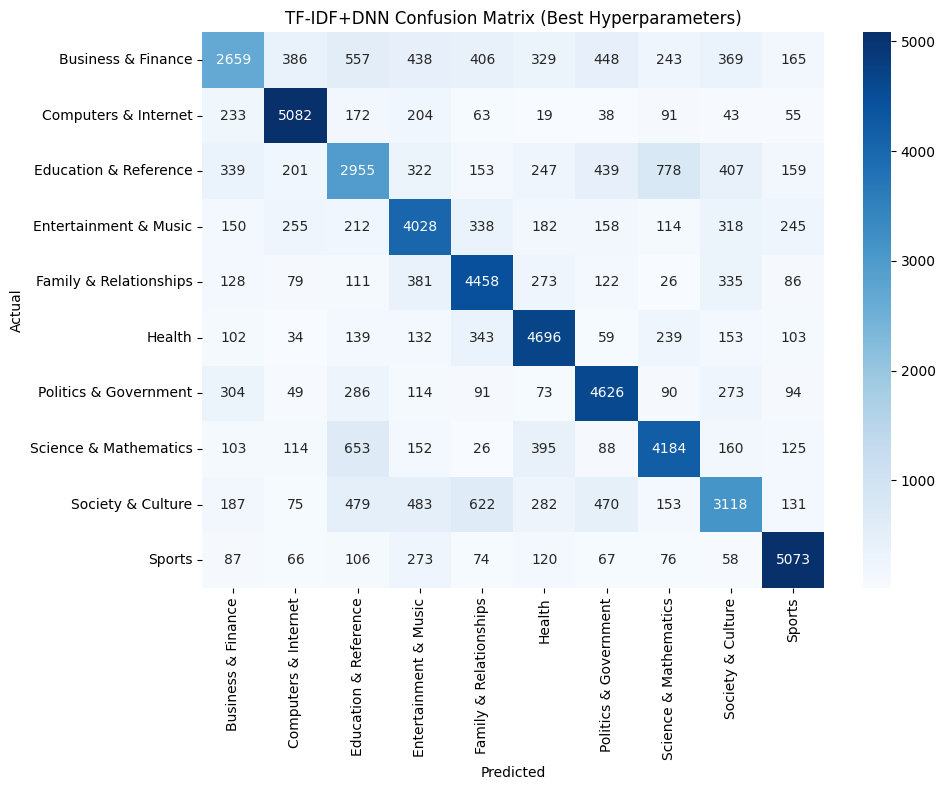


Skipgram+RNN - Using Best Hyperparameters from Tuning
Best Parameters: {'units': 128, 'dropout': 0.3, 'lr': 0.001, 'batch': 64, 'trainable_embed': False}
Expected Val Acc: 0.1064
Expected Val F1: 0.0302
Training Time (from tuning): 208.90s

Epoch 1/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 30s 22ms/step - accuracy: 0.1002 - loss: 2.3355 - val_accuracy: 0.1024 - val_loss: 2.3015
Epoch 2/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.1035 - loss: 2.2985 - val_accuracy: 0.1038 - val_loss: 2.3003
Epoch 3/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.1000 - loss: 2.3003 - val_accuracy: 0.1036 - val_loss: 2.3019
Epoch 4/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.1012 - loss: 2.3031 - val_accuracy: 0.1035 - val_loss: 2.3029
Epoch 5/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.1018 - loss: 2.3064 - val_accuracy: 0.1044 - val_loss: 2.3014
Epoch 6/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.1020 - loss: 2.3025 - val_ac

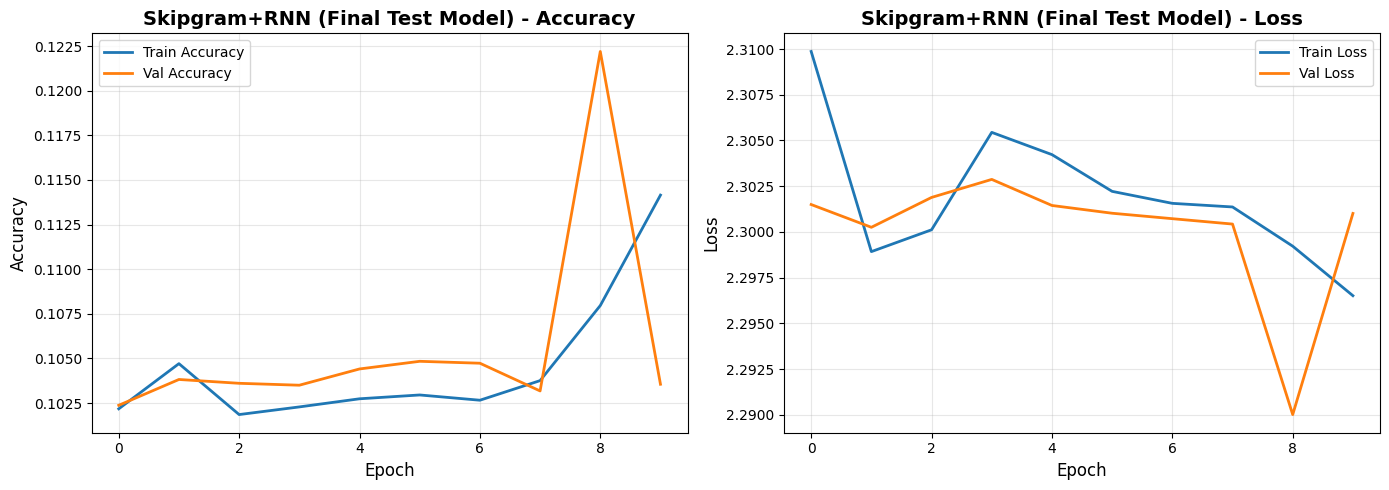


Skipgram+RNN Test Results (with tuned hyperparameters):
Accuracy: 0.1222
F1-Score (macro): 0.0562
F1-Score (weighted): 0.0562

Classification Report:
                        precision    recall  f1-score   support

    Business & Finance       0.00      0.00      0.00      6000
  Computers & Internet       0.11      0.91      0.20      6000
 Education & Reference       0.10      0.01      0.02      6000
 Entertainment & Music       0.00      0.00      0.00      6000
Family & Relationships       0.00      0.00      0.00      5999
                Health       0.18      0.00      0.01      6000
 Politics & Government       0.21      0.01      0.02      6000
 Science & Mathematics       0.13      0.08      0.10      6000
     Society & Culture       0.23      0.21      0.22      6000
                Sports       0.00      0.00      0.00      6000

              accuracy                           0.12     59999
             macro avg       0.10      0.12      0.06     59999
          weigh

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


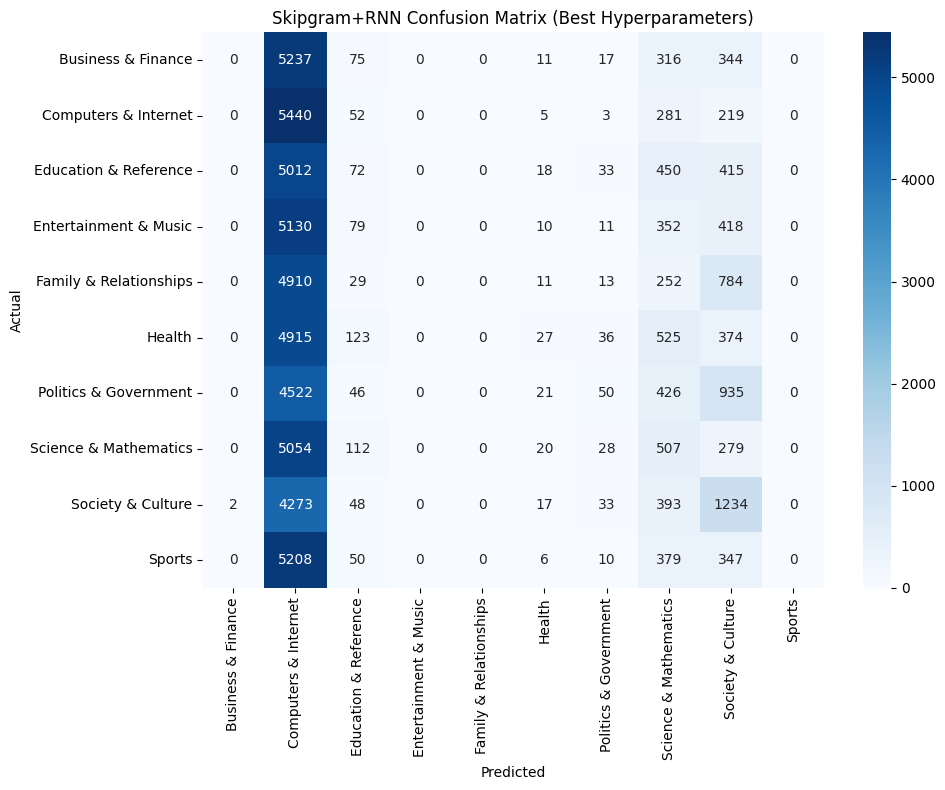


Skipgram+GRU - Using Best Hyperparameters from Tuning
Best Parameters: {'units': 256, 'dropout': 0.4, 'lr': 0.0005, 'batch': 64, 'trainable_embed': False}
Expected Val Acc: 0.7012
Expected Val F1: 0.7005
Training Time (from tuning): 203.21s

Epoch 1/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.1019 - loss: 2.3164 - val_accuracy: 0.1052 - val_loss: 2.2967
Epoch 2/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.1603 - loss: 2.1733 - val_accuracy: 0.6174 - val_loss: 1.1907
Epoch 3/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.6377 - loss: 1.1651 - val_accuracy: 0.6761 - val_loss: 1.0168
Epoch 4/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.6687 - loss: 1.0619 - val_accuracy: 0.6845 - val_loss: 0.9887
Epoch 5/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.6843 - loss: 1.0197 - val_accuracy: 0.6874 - val_loss: 0.9754
Epoch 6/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.6912 - loss: 0.9916 - val_a

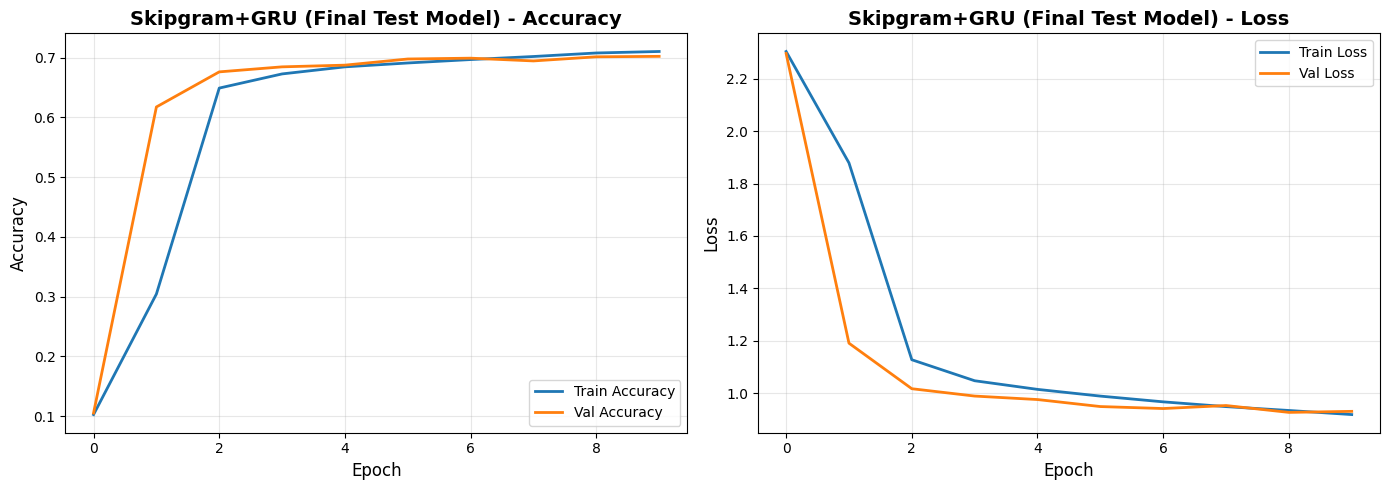


Skipgram+GRU Test Results (with tuned hyperparameters):
Accuracy: 0.7039
F1-Score (macro): 0.6991
F1-Score (weighted): 0.6991

Classification Report:
                        precision    recall  f1-score   support

    Business & Finance       0.64      0.48      0.55      6000
  Computers & Internet       0.85      0.84      0.84      6000
 Education & Reference       0.55      0.50      0.52      6000
 Entertainment & Music       0.67      0.67      0.67      6000
Family & Relationships       0.66      0.79      0.72      5999
                Health       0.72      0.82      0.77      6000
 Politics & Government       0.76      0.77      0.76      6000
 Science & Mathematics       0.68      0.76      0.72      6000
     Society & Culture       0.65      0.54      0.59      6000
                Sports       0.82      0.86      0.84      6000

              accuracy                           0.70     59999
             macro avg       0.70      0.70      0.70     59999
          weigh

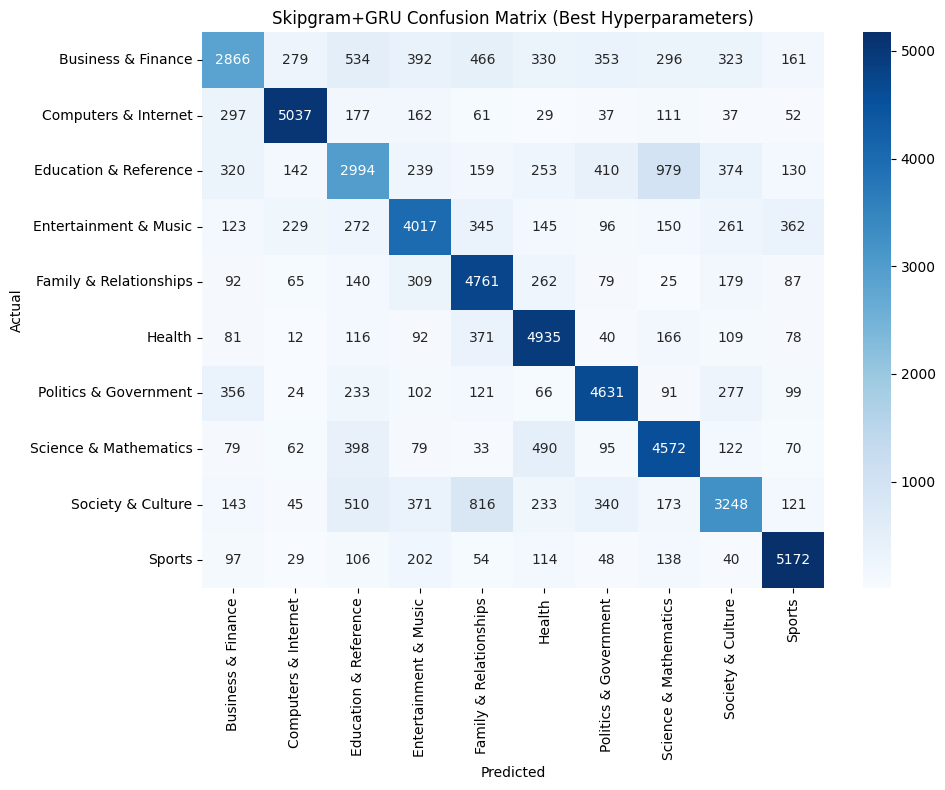


Skipgram+LSTM - Using Best Hyperparameters from Tuning
Best Parameters: {'units': 256, 'dropout': 0.4, 'lr': 0.0005, 'batch': 64, 'trainable_embed': False}
Expected Val Acc: 0.6862
Expected Val F1: 0.6826
Training Time (from tuning): 242.21s

Epoch 1/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - accuracy: 0.1028 - loss: 2.3109 - val_accuracy: 0.1077 - val_loss: 2.2943
Epoch 2/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.1048 - loss: 2.2981 - val_accuracy: 0.1073 - val_loss: 2.2947
Epoch 3/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.1083 - loss: 2.2895 - val_accuracy: 0.1095 - val_loss: 2.2880
Epoch 4/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.1191 - loss: 2.2723 - val_accuracy: 0.2711 - val_loss: 1.9363
Epoch 5/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.3339 - loss: 1.8036 - val_accuracy: 0.6124 - val_loss: 1.2113
Epoch 6/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.6152 - loss: 1.2487 - val_

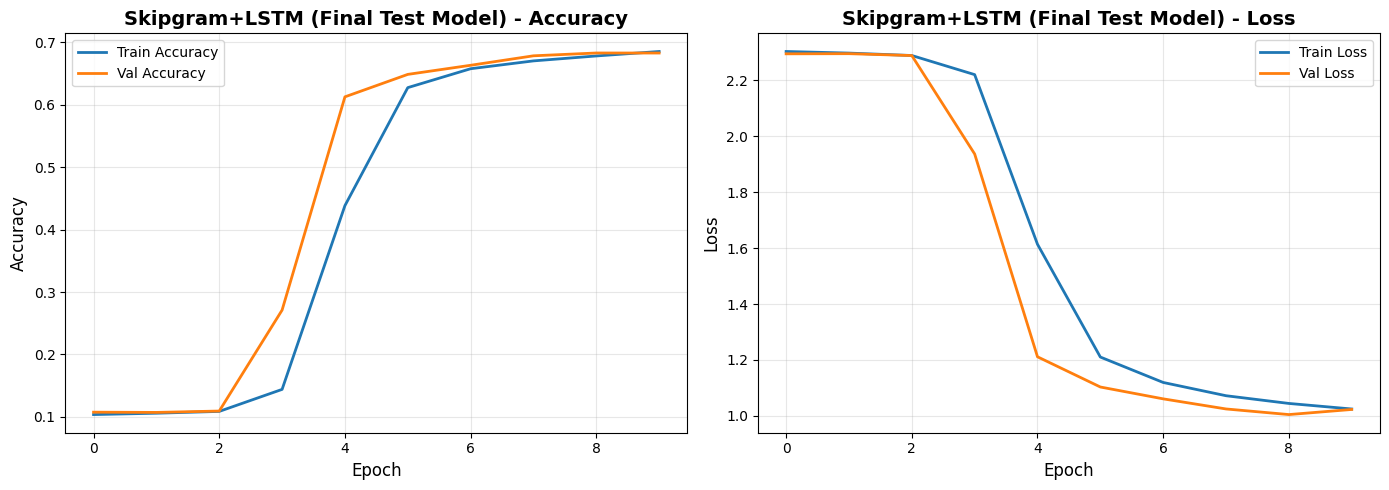


Skipgram+LSTM Test Results (with tuned hyperparameters):
Accuracy: 0.6861
F1-Score (macro): 0.6787
F1-Score (weighted): 0.6787

Classification Report:
                        precision    recall  f1-score   support

    Business & Finance       0.66      0.42      0.51      6000
  Computers & Internet       0.81      0.87      0.84      6000
 Education & Reference       0.57      0.43      0.49      6000
 Entertainment & Music       0.61      0.67      0.64      6000
Family & Relationships       0.64      0.78      0.71      5999
                Health       0.71      0.80      0.75      6000
 Politics & Government       0.69      0.80      0.74      6000
 Science & Mathematics       0.70      0.72      0.71      6000
     Society & Culture       0.59      0.54      0.56      6000
                Sports       0.85      0.82      0.83      6000

              accuracy                           0.69     59999
             macro avg       0.68      0.69      0.68     59999
          weig

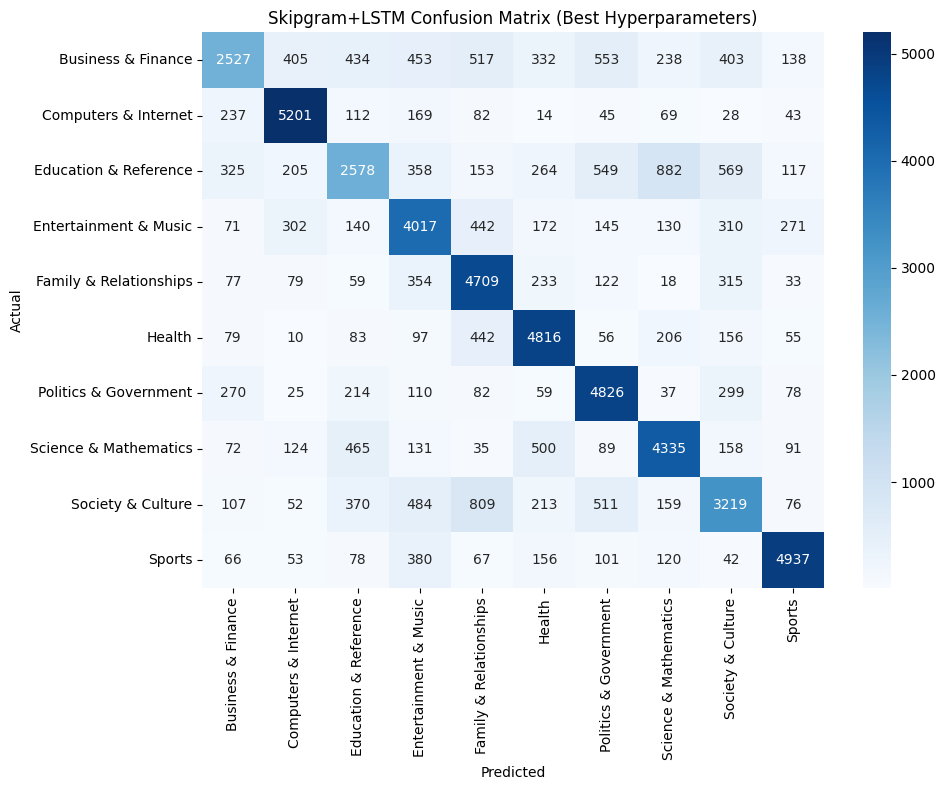


Skipgram+BiRNN - Using Best Hyperparameters from Tuning
Best Parameters: {'units': 256, 'dropout': 0.4, 'lr': 0.0005, 'batch': 64, 'trainable_embed': False}
Expected Val Acc: 0.6532
Expected Val F1: 0.6448
Training Time (from tuning): 305.44s

Epoch 1/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 52s 40ms/step - accuracy: 0.4220 - loss: 1.6849 - val_accuracy: 0.6233 - val_loss: 1.1980
Epoch 2/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 43s 37ms/step - accuracy: 0.6132 - loss: 1.2425 - val_accuracy: 0.6315 - val_loss: 1.1718
Epoch 3/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 43s 37ms/step - accuracy: 0.6272 - loss: 1.1984 - val_accuracy: 0.6233 - val_loss: 1.2176
Epoch 4/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 43s 37ms/step - accuracy: 0.6332 - loss: 1.1827 - val_accuracy: 0.5838 - val_loss: 1.2861
Epoch 5/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 43s 37ms/step - accuracy: 0.6372 - loss: 1.1730 - val_accuracy: 0.6504 - val_loss: 1.1014
Epoch 6/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 43s 37ms/step - accuracy: 0.6504 - loss: 1.1333 - val

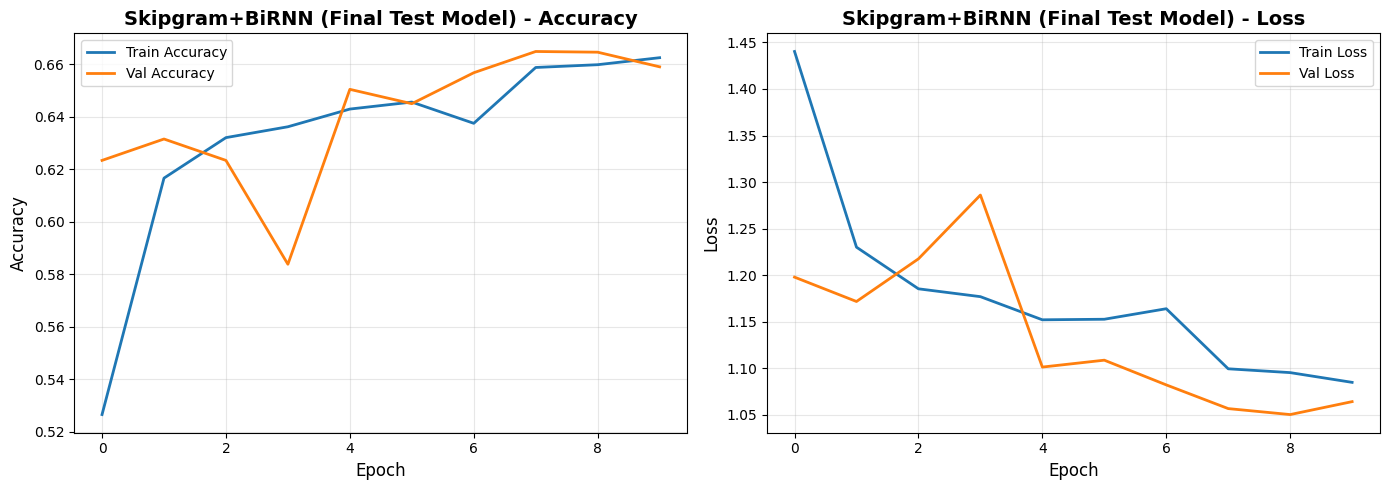


Skipgram+BiRNN Test Results (with tuned hyperparameters):
Accuracy: 0.6683
F1-Score (macro): 0.6625
F1-Score (weighted): 0.6625

Classification Report:
                        precision    recall  f1-score   support

    Business & Finance       0.67      0.41      0.51      6000
  Computers & Internet       0.82      0.84      0.83      6000
 Education & Reference       0.55      0.40      0.46      6000
 Entertainment & Music       0.59      0.66      0.63      6000
Family & Relationships       0.62      0.79      0.70      5999
                Health       0.75      0.77      0.76      6000
 Politics & Government       0.66      0.81      0.73      6000
 Science & Mathematics       0.65      0.74      0.70      6000
     Society & Culture       0.52      0.54      0.53      6000
                Sports       0.87      0.72      0.79      6000

              accuracy                           0.67     59999
             macro avg       0.67      0.67      0.66     59999
          wei

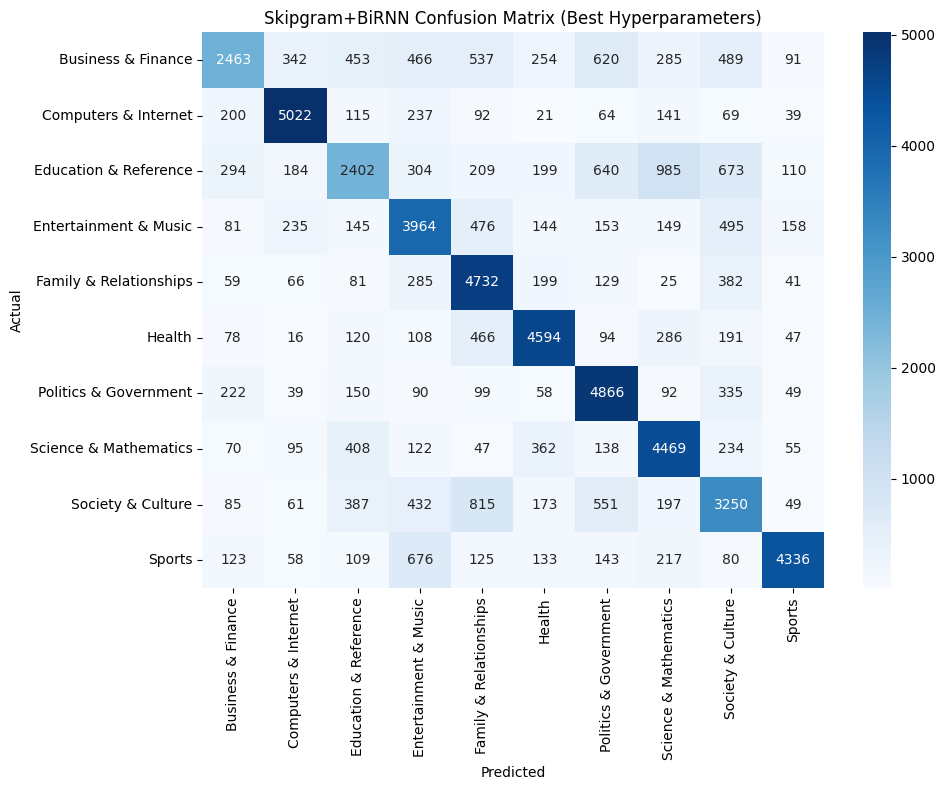


Skipgram+BiGRU - Using Best Hyperparameters from Tuning
Best Parameters: {'units': 128, 'dropout': 0.3, 'lr': 0.001, 'batch': 64, 'trainable_embed': False}
Expected Val Acc: 0.7035
Expected Val F1: 0.6991
Training Time (from tuning): 254.32s

Epoch 1/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 32s 23ms/step - accuracy: 0.5153 - loss: 1.4286 - val_accuracy: 0.6831 - val_loss: 0.9994
Epoch 2/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - accuracy: 0.6783 - loss: 1.0213 - val_accuracy: 0.6900 - val_loss: 0.9609
Epoch 3/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.6894 - loss: 0.9811 - val_accuracy: 0.6914 - val_loss: 0.9545
Epoch 4/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - accuracy: 0.6945 - loss: 0.9594 - val_accuracy: 0.6943 - val_loss: 0.9382
Epoch 5/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.6995 - loss: 0.9383 - val_accuracy: 0.6979 - val_loss: 0.9335
Epoch 6/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.7030 - loss: 0.9280 - val_

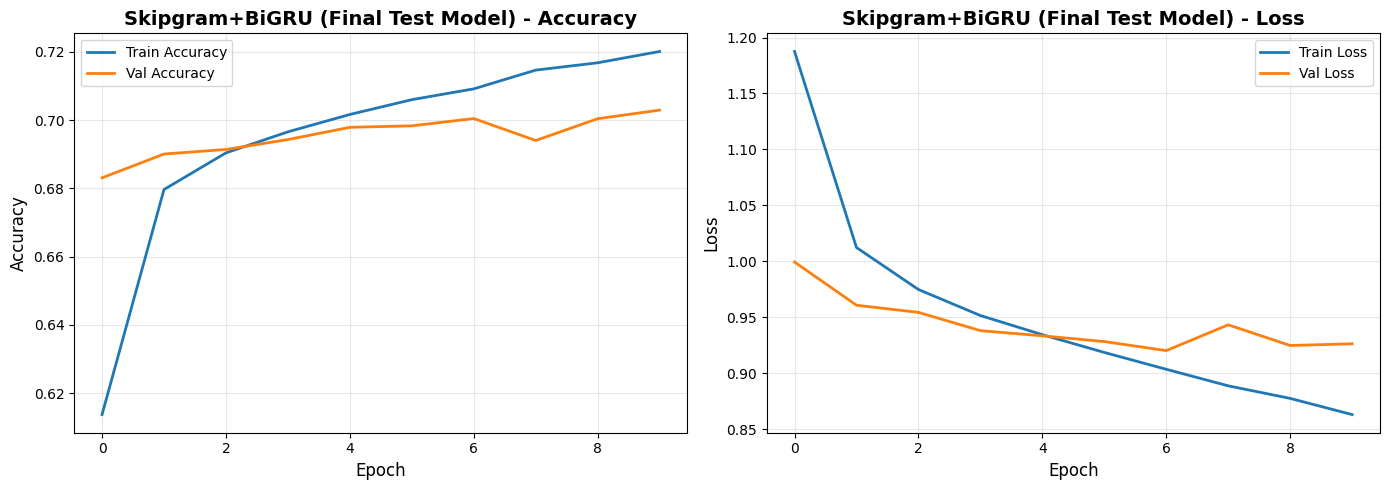


Skipgram+BiGRU Test Results (with tuned hyperparameters):
Accuracy: 0.7057
F1-Score (macro): 0.6997
F1-Score (weighted): 0.6997

Classification Report:
                        precision    recall  f1-score   support

    Business & Finance       0.66      0.46      0.54      6000
  Computers & Internet       0.83      0.86      0.85      6000
 Education & Reference       0.60      0.46      0.52      6000
 Entertainment & Music       0.67      0.69      0.68      6000
Family & Relationships       0.72      0.75      0.73      5999
                Health       0.66      0.86      0.75      6000
 Politics & Government       0.72      0.81      0.76      6000
 Science & Mathematics       0.69      0.75      0.72      6000
     Society & Culture       0.61      0.57      0.59      6000
                Sports       0.86      0.84      0.85      6000

              accuracy                           0.71     59999
             macro avg       0.70      0.71      0.70     59999
          wei

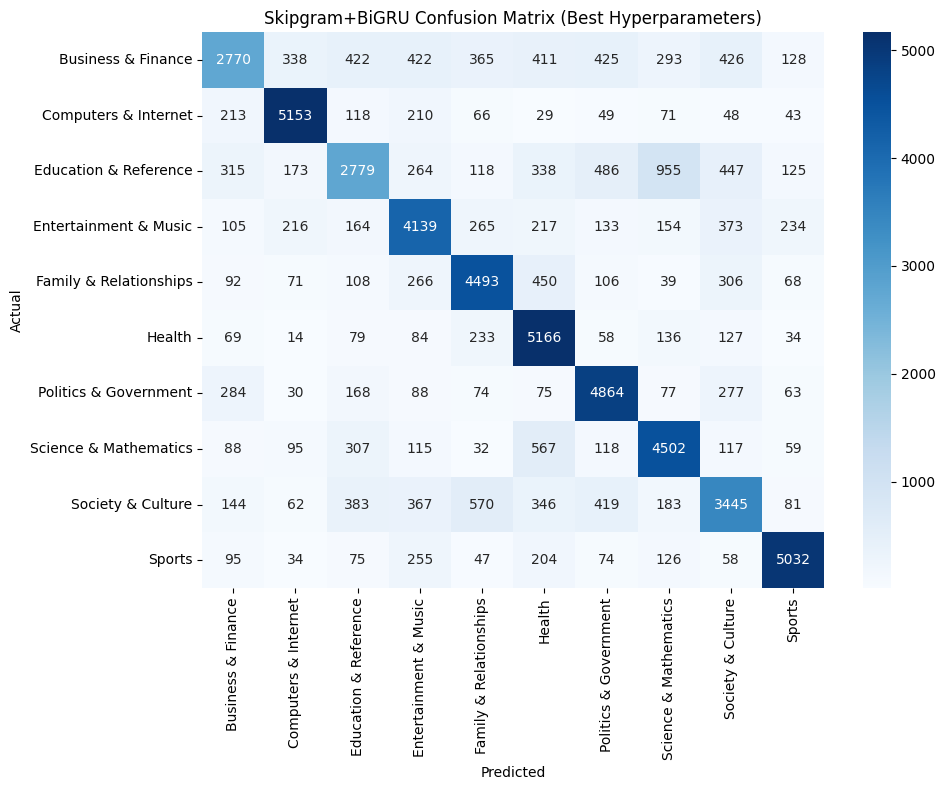


Skipgram+BiLSTM - Using Best Hyperparameters from Tuning
Best Parameters: {'units': 256, 'dropout': 0.4, 'lr': 0.0005, 'batch': 64, 'trainable_embed': False}
Expected Val Acc: 0.7045
Expected Val F1: 0.7009
Training Time (from tuning): 412.34s

Epoch 1/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 47s 36ms/step - accuracy: 0.5064 - loss: 1.4718 - val_accuracy: 0.6674 - val_loss: 1.0317
Epoch 2/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 42s 36ms/step - accuracy: 0.6679 - loss: 1.0573 - val_accuracy: 0.6794 - val_loss: 1.0113
Epoch 3/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.6792 - loss: 1.0156 - val_accuracy: 0.6856 - val_loss: 0.9738
Epoch 4/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.6860 - loss: 0.9881 - val_accuracy: 0.6898 - val_loss: 0.9655
Epoch 5/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.6930 - loss: 0.9663 - val_accuracy: 0.6944 - val_loss: 0.9477
Epoch 6/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.6979 - loss: 0.9473 - va

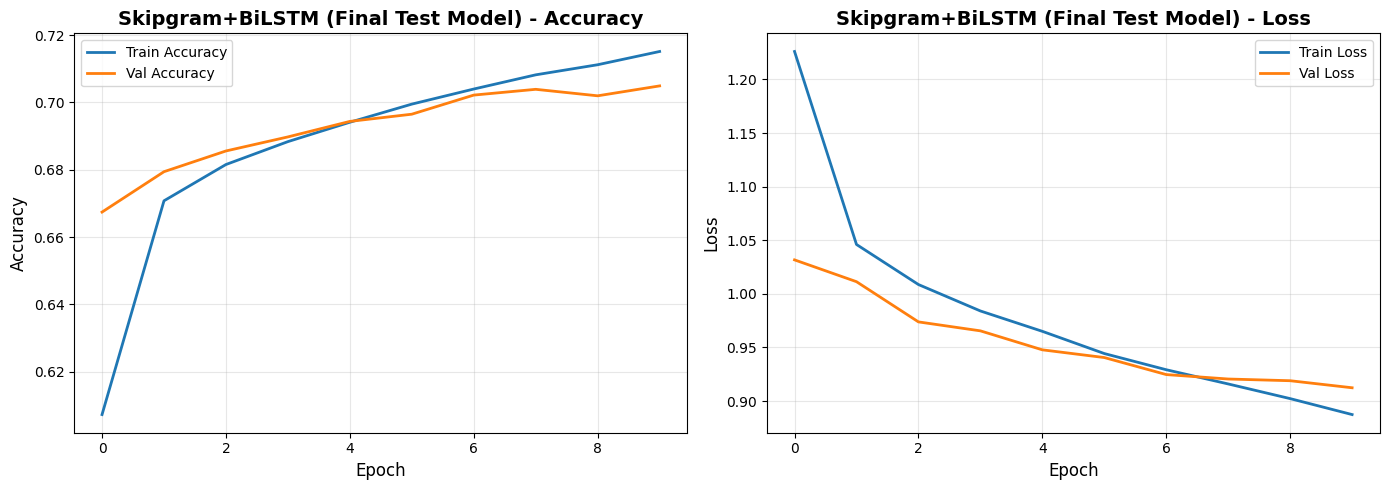


Skipgram+BiLSTM Test Results (with tuned hyperparameters):
Accuracy: 0.7072
F1-Score (macro): 0.7002
F1-Score (weighted): 0.7002

Classification Report:
                        precision    recall  f1-score   support

    Business & Finance       0.68      0.45      0.55      6000
  Computers & Internet       0.81      0.88      0.84      6000
 Education & Reference       0.59      0.48      0.53      6000
 Entertainment & Music       0.65      0.69      0.67      6000
Family & Relationships       0.67      0.80      0.73      5999
                Health       0.75      0.81      0.78      6000
 Politics & Government       0.73      0.80      0.77      6000
 Science & Mathematics       0.70      0.76      0.73      6000
     Society & Culture       0.64      0.54      0.58      6000
                Sports       0.81      0.86      0.83      6000

              accuracy                           0.71     59999
             macro avg       0.70      0.71      0.70     59999
          we

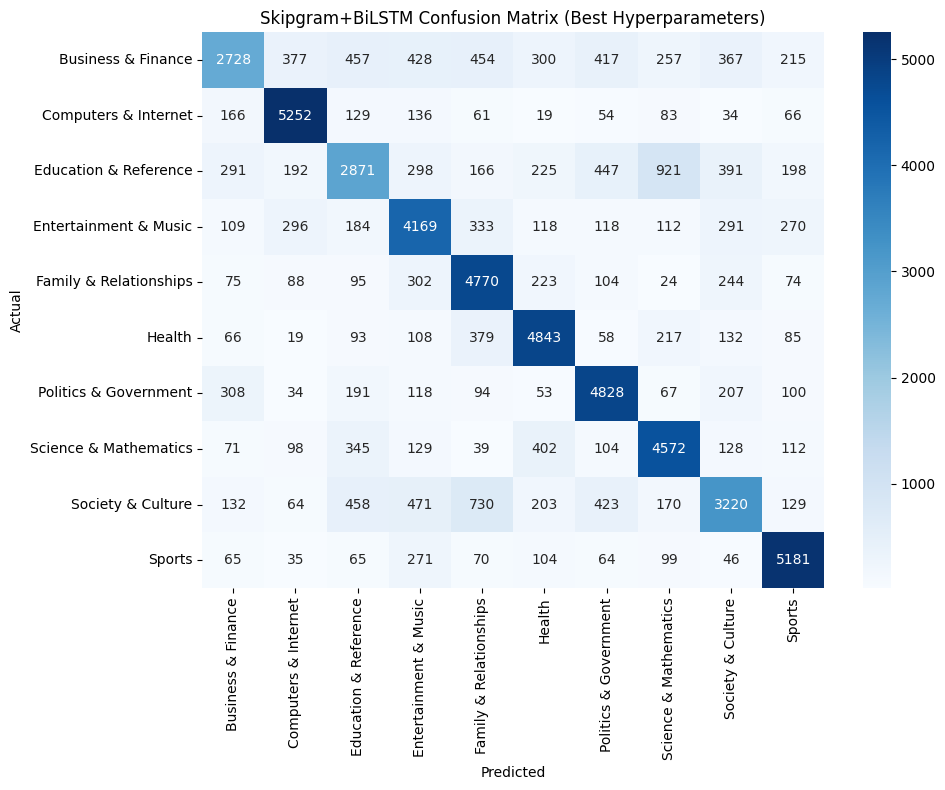


FINAL TEST RESULTS - ALL MODELS (WITH TUNED HYPERPARAMETERS)
          model  test_acc  test_f1_macro  test_f1_weighted
Skipgram+BiLSTM  0.707245       0.700200          0.700200
 Skipgram+BiGRU  0.705728       0.699684          0.699683
   Skipgram+GRU  0.703895       0.699055          0.699054
  Skipgram+LSTM  0.686095       0.678731          0.678731
     TF-IDF+DNN  0.681328       0.676466          0.676466
 Skipgram+BiRNN  0.668311       0.662455          0.662454
   Skipgram+RNN  0.122169       0.056178          0.056179

BEST AND WORST PERFORMING MODELS

🏆 Best Model: Skipgram+BiLSTM
   Test Accuracy: 0.7072
   Test F1-Score (macro): 0.7002
   Best Params: {'units': 256, 'dropout': 0.4, 'lr': 0.0005, 'batch': 64, 'trainable_embed': False}

❌ Worst Model: Skipgram+RNN
   Test Accuracy: 0.1222
   Test F1-Score (macro): 0.0562

COMPARISON: RANDOM FOREST VS BEST NEURAL NETWORK

📊 Random Forest (Baseline):
   Accuracy: 0.6301
   F1-Score (macro): 0.6213

🚀 Best Neural Network (Skipg

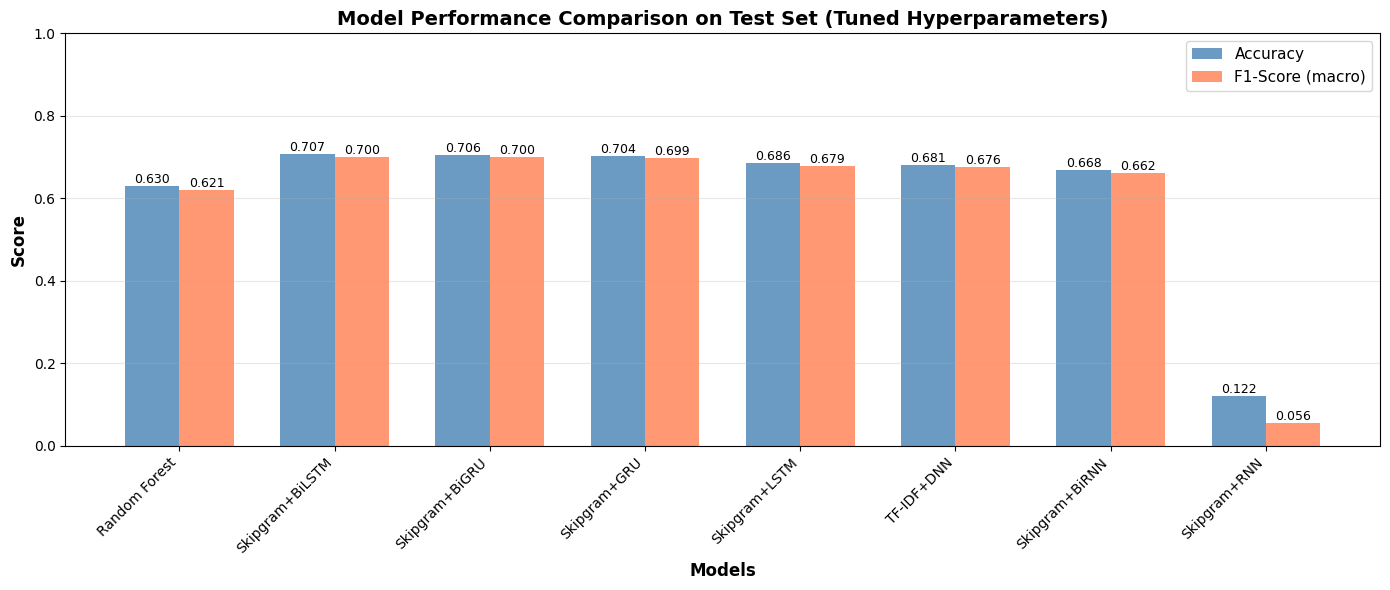


CONFUSION MATRICES - ALL NEURAL NETWORKS


In [62]:
print("\n" + "="*80)
print("FINAL EVALUATION ON TEST SET")
print("="*80)

final_results = []
training_histories = {}

best_tfidf_dnn = tuning_df[tuning_df['model'] == 'TF-IDF+DNN'].iloc[0]
best_params = eval(best_tfidf_dnn['params'])

print(f"\n{'='*60}")
print(f"TF-IDF+DNN - Using Best Hyperparameters from Tuning")
print(f"{'='*60}")
print(f"Best Parameters: {best_params}")
print(f"Expected Val Acc: {best_tfidf_dnn['val_acc']:.4f}")
print(f"Expected Val F1: {best_tfidf_dnn['val_f1_macro']:.4f}")
print(f"{'='*60}\n")

model = build_tfidf_dnn(
    input_dim=input_dim,
    num_classes=num_classes,
    hidden=best_params["hidden"],
    dropout=best_params["dropout"],
    lr=best_params["lr"]
)

steps_per_epoch = int(np.ceil(X_train_tfidf.shape[0] / best_params["batch"]))
val_steps = int(np.ceil(X_val_tfidf.shape[0] / best_params["batch"]))
test_steps = int(np.ceil(X_test_tfidf.shape[0] / best_params["batch"]))

train_gen = sparse_batch_generator(X_train_tfidf, train_labels_np, best_params["batch"], shuffle=True)
val_gen = sparse_batch_generator(X_val_tfidf, val_labels_np, best_params["batch"], shuffle=False)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=steps_per_epoch,
    validation_steps=val_steps,
    epochs=10,
    callbacks=[early_stop],
    verbose=1
)

training_histories['TF-IDF+DNN'] = history
plot_training_history(history, "TF-IDF+DNN (Final Test Model)")

test_preds = []
test_gen = sparse_batch_generator(X_test_tfidf, test_labels_np, best_params["batch"], shuffle=False)

for _ in range(test_steps):
    Xb, yb = next(test_gen)
    probs = model.predict(Xb, verbose=0)
    test_preds.extend(np.argmax(probs, axis=1))

test_preds = np.array(test_preds[:len(test_labels_np)])
metrics = compute_metrics(test_labels_np, test_preds)

final_results.append({
    "model": "TF-IDF+DNN",
    "best_params": str(best_params),
    "test_acc": metrics["acc"],
    "test_f1_macro": metrics["f1_macro"],
    "test_f1_weighted": metrics["f1_weighted"]
})

print(f"\n{'='*60}")
print(f"TF-IDF+DNN Test Results (with tuned hyperparameters):")
print(f"{'='*60}")
print(f"Accuracy: {metrics['acc']:.4f}")
print(f"F1-Score (macro): {metrics['f1_macro']:.4f}")
print(f"F1-Score (weighted): {metrics['f1_weighted']:.4f}")
print("\nClassification Report:")
print(classification_report(test_labels_np, test_preds, target_names=label_encoder.classes_))

cm = confusion_matrix(test_labels_np, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('TF-IDF+DNN Confusion Matrix (Best Hyperparameters)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

tf.keras.backend.clear_session()
del model
gc.collect()

for arch in seq_models:
    model_name = f"Skipgram+{arch}"

    best_model_row = tuning_df[tuning_df['model'] == model_name].iloc[0]
    best_params = eval(best_model_row['params'])

    print(f"\n{'='*60}")
    print(f"{model_name} - Using Best Hyperparameters from Tuning")
    print(f"{'='*60}")
    print(f"Best Parameters: {best_params}")
    print(f"Expected Val Acc: {best_model_row['val_acc']:.4f}")
    print(f"Expected Val F1: {best_model_row['val_f1_macro']:.4f}")
    print(f"Training Time (from tuning): {best_model_row['time_sec']:.2f}s")
    print(f"{'='*60}\n")

    model = build_skipgram_seq(
        model_type=arch,
        vocab_size=VOCAB_SIZE,
        embedding_matrix=embedding_matrix,
        max_len=MAX_LEN,
        num_classes=num_classes,
        units=best_params["units"],
        dropout=best_params["dropout"],
        lr=best_params["lr"],
        trainable_embed=best_params["trainable_embed"]
    )

    train_ds = make_seq_dataset(X_train_pad, train_labels_np, best_params["batch"], shuffle=True)
    val_ds = make_seq_dataset(X_val_pad, val_labels_np, best_params["batch"], shuffle=False)

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10,
        callbacks=[early_stop],
        verbose=1
    )

    training_histories[model_name] = history
    plot_training_history(history, f"{model_name} (Final Test Model)")

    test_probs = model.predict(X_test_pad, verbose=0)
    test_pred = np.argmax(test_probs, axis=1)
    metrics = compute_metrics(test_labels_np, test_pred)

    final_results.append({
        "model": model_name,
        "best_params": str(best_params),
        "test_acc": metrics["acc"],
        "test_f1_macro": metrics["f1_macro"],
        "test_f1_weighted": metrics["f1_weighted"],
        "test_predictions": test_pred.copy()
    })

    print(f"\n{'='*60}")
    print(f"{model_name} Test Results (with tuned hyperparameters):")
    print(f"{'='*60}")
    print(f"Accuracy: {metrics['acc']:.4f}")
    print(f"F1-Score (macro): {metrics['f1_macro']:.4f}")
    print(f"F1-Score (weighted): {metrics['f1_weighted']:.4f}")
    print("\nClassification Report:")
    print(classification_report(test_labels_np, test_pred, target_names=label_encoder.classes_))

    cm = confusion_matrix(test_labels_np, test_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'{model_name} Confusion Matrix (Best Hyperparameters)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    tf.keras.backend.clear_session()
    del model
    gc.collect()

final_df = pd.DataFrame(final_results).sort_values("test_f1_macro", ascending=False)

print("\n" + "="*80)
print("FINAL TEST RESULTS - ALL MODELS (WITH TUNED HYPERPARAMETERS)")
print("="*80)
print(final_df[['model', 'test_acc', 'test_f1_macro', 'test_f1_weighted']].to_string(index=False))

print("\n" + "="*80)
print("BEST AND WORST PERFORMING MODELS")
print("="*80)
print(f"\n Best Model: {final_df.iloc[0]['model']}")
print(f"   Test Accuracy: {final_df.iloc[0]['test_acc']:.4f}")
print(f"   Test F1-Score (macro): {final_df.iloc[0]['test_f1_macro']:.4f}")
print(f"   Best Params: {final_df.iloc[0]['best_params']}")

print(f"\n Worst Model: {final_df.iloc[-1]['model']}")
print(f"   Test Accuracy: {final_df.iloc[-1]['test_acc']:.4f}")
print(f"   Test F1-Score (macro): {final_df.iloc[-1]['test_f1_macro']:.4f}")

print("\n" + "="*80)
print("COMPARISON: RANDOM FOREST VS BEST NEURAL NETWORK")
print("="*80)

rf_test_pred = final_rf_model.predict(X_test_tfidf)
rf_test_acc = accuracy_score(test_labels_np, rf_test_pred)
rf_test_f1 = f1_score(test_labels_np, rf_test_pred, average='macro')

print(f"\n Random Forest (Baseline):")
print(f"   Accuracy: {rf_test_acc:.4f}")
print(f"   F1-Score (macro): {rf_test_f1:.4f}")

print(f"\n Best Neural Network ({final_df.iloc[0]['model']}):")
print(f"   Accuracy: {final_df.iloc[0]['test_acc']:.4f}")
print(f"   F1-Score (macro): {final_df.iloc[0]['test_f1_macro']:.4f}")

if final_df.iloc[0]['test_f1_macro'] > rf_test_f1:
    improvement = ((final_df.iloc[0]['test_f1_macro'] - rf_test_f1) / rf_test_f1) * 100
    print(f"\n Improvement over Random Forest: +{improvement:.2f}%")
else:
    decline = ((rf_test_f1 - final_df.iloc[0]['test_f1_macro']) / rf_test_f1) * 100
    print(f"\n Random Forest performs better by: {decline:.2f}%")

print("\n" + "="*80)
print("MODEL PERFORMANCE VISUALIZATION")
print("="*80)

all_models = ['Random Forest'] + final_df['model'].tolist()
all_acc = [rf_test_acc] + final_df['test_acc'].tolist()
all_f1 = [rf_test_f1] + final_df['test_f1_macro'].tolist()

x = np.arange(len(all_models))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 6))
bars1 = ax.bar(x - width/2, all_acc, width, label='Accuracy', color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, all_f1, width, label='F1-Score (macro)', color='coral', alpha=0.8)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Models', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison on Test Set (Tuned Hyperparameters)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(all_models, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.0])

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("CONFUSION MATRICES - ALL NEURAL NETWORKS")
print("="*80)



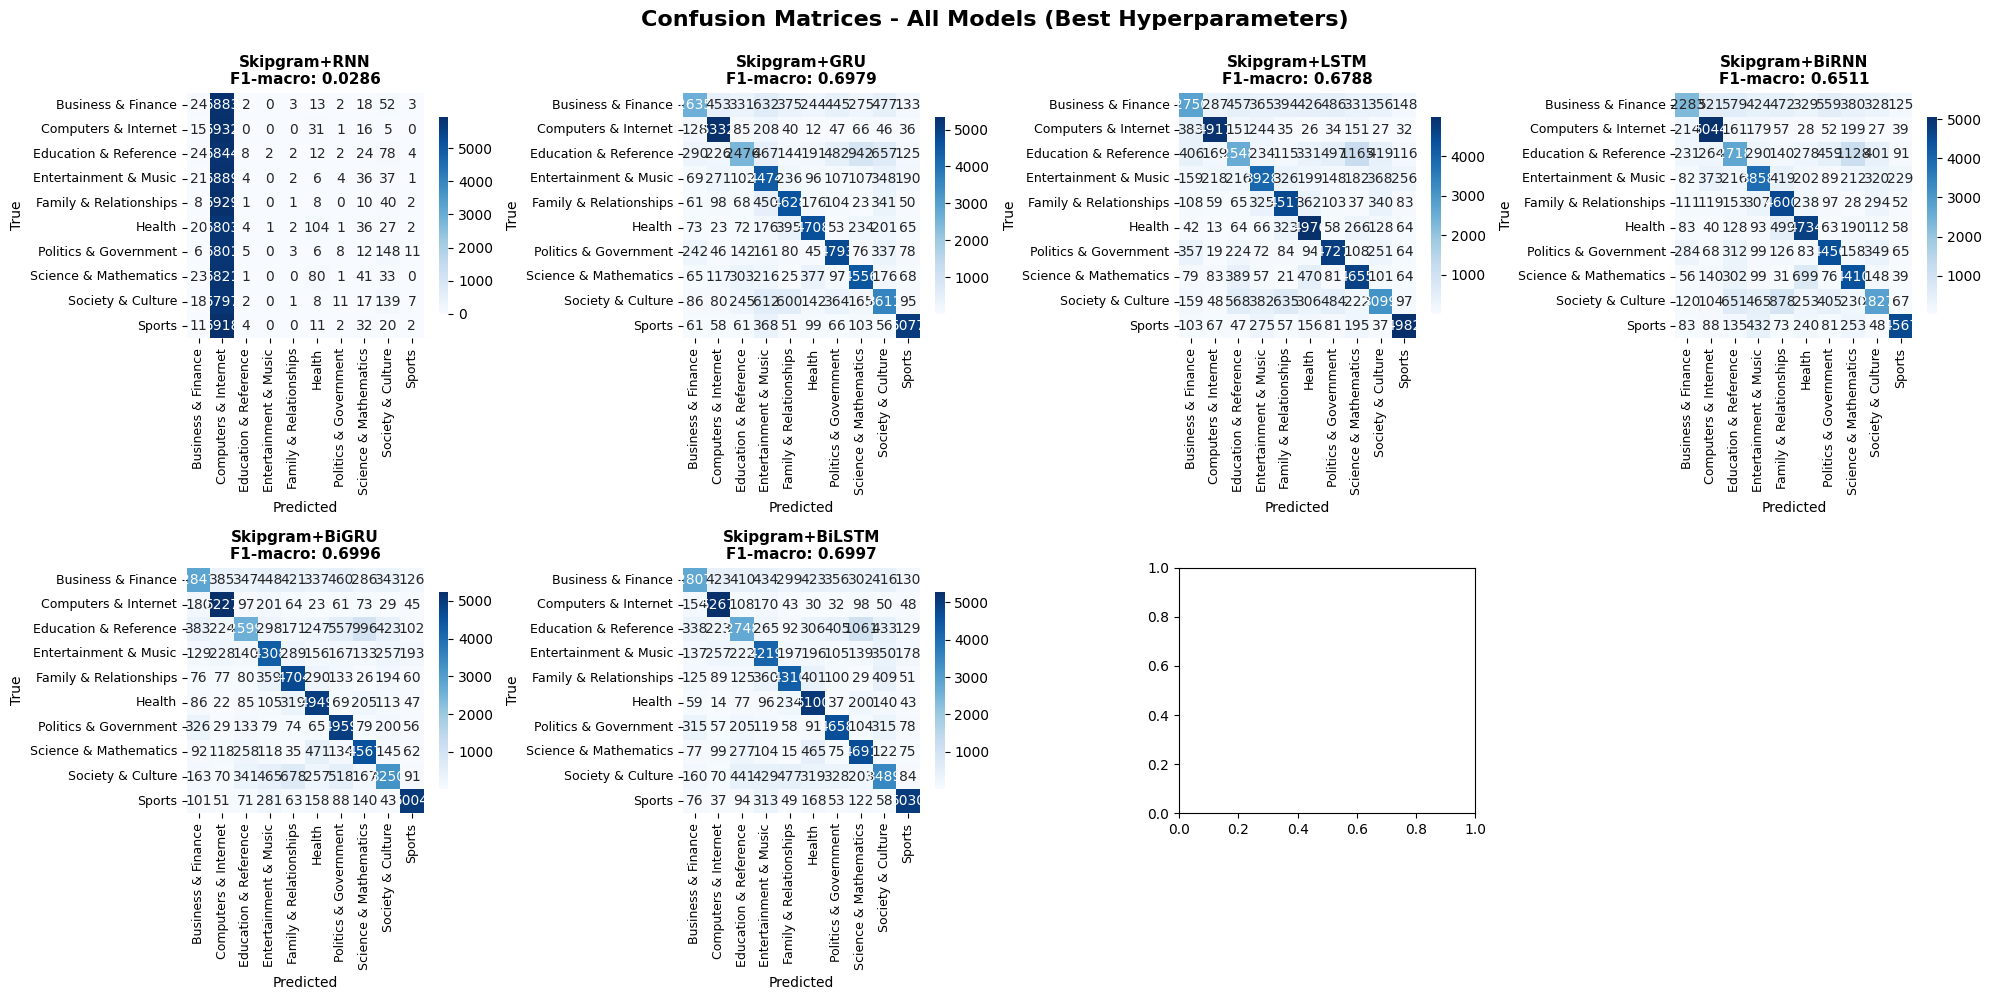


SUMMARY STATISTICS
       Metric  Value
Mean Accuracy 0.6096
 Std Accuracy 0.2059
Mean F1-macro 0.5941
 Std F1-macro 0.2301
 Max Accuracy 0.7069
 Min Accuracy 0.1043

HYPERPARAMETER ANALYSIS - TOP 3 MODELS

Skipgram+BiLSTM:
  Test F1-macro: 0.6997
  Hyperparameters: {'units': 256, 'dropout': 0.4, 'lr': 0.0005, 'batch': 64, 'trainable_embed': False}

Skipgram+BiGRU:
  Test F1-macro: 0.6996
  Hyperparameters: {'units': 128, 'dropout': 0.3, 'lr': 0.001, 'batch': 64, 'trainable_embed': False}

Skipgram+GRU:
  Test F1-macro: 0.6979
  Hyperparameters: {'units': 256, 'dropout': 0.4, 'lr': 0.0005, 'batch': 64, 'trainable_embed': False}

PROJECT COMPLETED!

✅ All models trained with BEST HYPERPARAMETERS from tuning phase
✅ All results have been computed and displayed.

📊 Best performing model: Skipgram+BiLSTM (F1-macro: 0.6997)


In [61]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()
plot_results = [r for r in final_results if 'test_predictions' in r]


for idx, result in enumerate(plot_results):
    if idx < len(axes):
        ax = axes[idx]

        cm = confusion_matrix(test_labels_np, result['test_predictions'])

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                    xticklabels=label_encoder.classes_,
                    yticklabels=label_encoder.classes_,
                    cbar=True, cbar_kws={'shrink': 0.8})
        ax.set_title(f"{result['model']}\nF1-macro: {result['test_f1_macro']:.4f}",
                     fontsize=11, fontweight='bold')
        ax.set_xlabel('Predicted', fontsize=10)
        ax.set_ylabel('True', fontsize=10)
        ax.tick_params(labelsize=9)

for idx in range(len(final_results), len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('Confusion Matrices - All Models (Best Hyperparameters)',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

all_models_df = pd.DataFrame({
    'model': all_models,
    'test_acc': all_acc,
    'test_f1_macro': all_f1
})

summary_stats = {
    "Metric": ["Mean Accuracy", "Std Accuracy", "Mean F1-macro", "Std F1-macro", "Max Accuracy", "Min Accuracy"],
    "Value": [
        f"{all_models_df['test_acc'].mean():.4f}",
        f"{all_models_df['test_acc'].std():.4f}",
        f"{all_models_df['test_f1_macro'].mean():.4f}",
        f"{all_models_df['test_f1_macro'].std():.4f}",
        f"{all_models_df['test_acc'].max():.4f}",
        f"{all_models_df['test_acc'].min():.4f}"
    ]
}
summary_df = pd.DataFrame(summary_stats)
print(summary_df.to_string(index=False))

print("\n" + "="*80)
print("HYPERPARAMETER ANALYSIS - TOP 3 MODELS")
print("="*80)

top_3 = final_df.head(3)
for idx, row in top_3.iterrows():
    print(f"\n{row['model']}:")
    print(f"  Test F1-macro: {row['test_f1_macro']:.4f}")
    print(f"  Hyperparameters: {row['best_params']}")

print("\n" + "="*80)
print("PROJECT COMPLETED!")
print("="*80)
print("\n All models trained with BEST HYPERPARAMETERS from tuning phase")
print(" All results have been computed and displayed.")
print(f"\n Best performing model: {final_df.iloc[0]['model']} (F1-macro: {final_df.iloc[0]['test_f1_macro']:.4f})")
print("="*80)

In [53]:
print('helloworld')

helloworld



GENERATING F1-WEIGHTED SCORE COMPARISON

📊 F1-Weighted Scores (sorted):
          model  f1_weighted
 Skipgram+BiGRU     0.701164
Skipgram+BiLSTM     0.695999
   Skipgram+GRU     0.694446
  Skipgram+LSTM     0.683150
     TF-IDF+DNN     0.678637
 Skipgram+BiRNN     0.663573
    RF + TF-IDF     0.621268
   Skipgram+RNN     0.029125


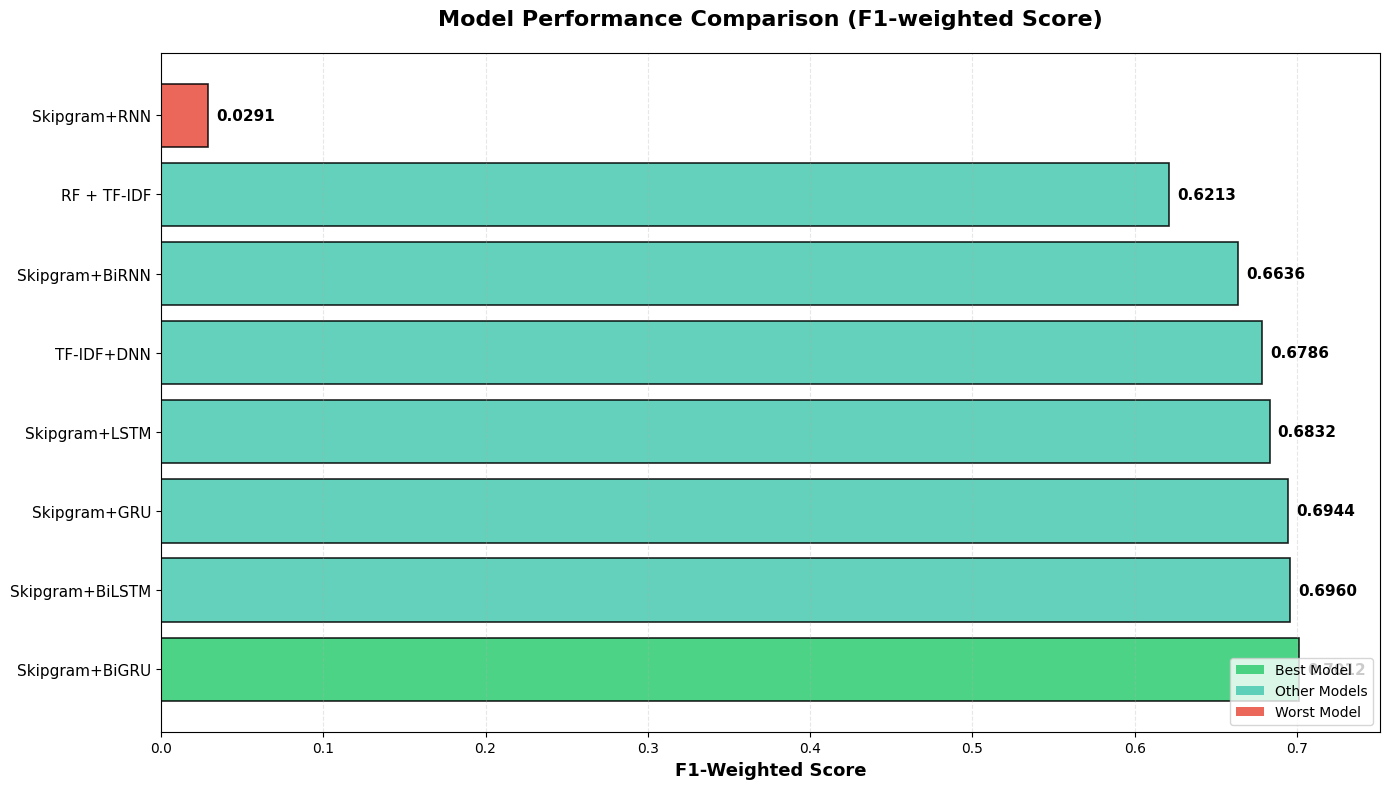


F1-WEIGHTED SCORE STATISTICS

🏆 Best Model: Skipgram+BiGRU
   F1-Weighted: 0.7012

❌ Worst Model: Skipgram+RNN
   F1-Weighted: 0.0291

📊 Statistics:
   Mean F1-Weighted: 0.5959
   Std F1-Weighted: 0.2304
   Range: 0.6720



In [54]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


print("\n" + "="*80)
print("GENERATING F1-WEIGHTED SCORE COMPARISON")
print("="*80)

all_model_results = []

all_model_results.append({
    'model': 'RF + TF-IDF',
    'f1_weighted': test_f1_weighted if 'test_f1_weighted' in locals() else best_rf_results['test_f1_weighted']
})

tfidf_dnn_result = [r for r in final_results if r['model'] == 'TF-IDF+DNN']
if tfidf_dnn_result:
    all_model_results.append({
        'model': 'TF-IDF+DNN',
        'f1_weighted': tfidf_dnn_result[0]['test_f1_weighted']
    })

skipgram_models = ['Skipgram+RNN', 'Skipgram+GRU', 'Skipgram+LSTM',
                   'Skipgram+BiRNN', 'Skipgram+BiGRU', 'Skipgram+BiLSTM']

for model_name in skipgram_models:
    model_result = [r for r in final_results if r['model'] == model_name]
    if model_result:
        all_model_results.append({
            'model': model_name,
            'f1_weighted': model_result[0]['test_f1_weighted']
        })

results_df = pd.DataFrame(all_model_results)
results_df = results_df.sort_values('f1_weighted', ascending=False)

print("\n F1-Weighted Scores (sorted):")
print(results_df.to_string(index=False))


plt.figure(figsize=(14, 8))

colors = []
for i, score in enumerate(results_df['f1_weighted']):
    if i == 0:
        colors.append('
    elif i == len(results_df) - 1:
        colors.append('
    else:
        colors.append('

bars = plt.barh(range(len(results_df)), results_df['f1_weighted'],
                color=colors, alpha=0.85, edgecolor='black', linewidth=1.2)

for i, (bar, value) in enumerate(zip(bars, results_df['f1_weighted'])):
    plt.text(value + 0.005, i, f'{value:.4f}',
             va='center', fontsize=11, fontweight='bold')

plt.yticks(range(len(results_df)), results_df['model'], fontsize=11)
plt.xlabel('F1-Weighted Score', fontsize=13, fontweight='bold')
plt.title('Model Performance Comparison (F1-weighted Score)',
          fontsize=16, fontweight='bold', pad=20)
plt.xlim(0, max(results_df['f1_weighted']) + 0.05)
plt.grid(axis='x', alpha=0.3, linestyle='--')

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='
    Patch(facecolor='
    Patch(facecolor='
]
plt.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()


print("\n" + "="*80)
print("F1-WEIGHTED SCORE STATISTICS")
print("="*80)

print(f"\n Best Model: {results_df.iloc[0]['model']}")
print(f"   F1-Weighted: {results_df.iloc[0]['f1_weighted']:.4f}")

print(f"\n Worst Model: {results_df.iloc[-1]['model']}")
print(f"   F1-Weighted: {results_df.iloc[-1]['f1_weighted']:.4f}")

print(f"\n Statistics:")
print(f"   Mean F1-Weighted: {results_df['f1_weighted'].mean():.4f}")
print(f"   Std F1-Weighted: {results_df['f1_weighted'].std():.4f}")
print(f"   Range: {results_df['f1_weighted'].max() - results_df['f1_weighted'].min():.4f}")

print("\n" + "="*80)